In [2]:
import argparse
# from collections import OrderedDict
import copy
import cupy as cp
import faiss
import matplotlib.pyplot as plt
%matplotlib inline
# from multiprocessing import Process,Manager
import numpy as np
import os
import pandas as pd
import pickle
from scipy import sparse
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tensorboardX import SummaryWriter
from tqdm import tqdm

from models import *
import data
from mymetric import calc_metric

plt.rcParams.update({
    "font.size" : 18,
    "text.usetex": True,
    "font.family": "Helvetica",
})

# Set Configs

In [3]:
##  Set the random seed manually for reproductibility.
seed = 1
torch.manual_seed(seed)

In [4]:
# device= torch.device("cuda")
device = torch.device("cpu")

In [5]:
ALGO_NAME="RecVAE"
DATASET_NAME="msd"

In [6]:
# Load Data
loader = data.DataLoader('dataset/{}'.format(DATASET_NAME))

n_items = loader.load_n_items()
train_data = loader.load_data('train')
vad_data_tr, vad_data_te = loader.load_data('validation')
test_data_tr, test_data_te = loader.load_data('test')

N = train_data.shape[0]
idxlist = list(range(N))

print("# of items:{}".format(n_items))

# of items:149158


In [7]:
# Build the model
input_dim = n_items
hidden_dim = 600
latent_dim = 200
model = RecVAE(hidden_dim, latent_dim, input_dim).to(device)

print(f"Model Structure:{model}\n")
# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

optimizer_encoder = optim.Adam(model.encoder.parameters(), lr=1e-4, weight_decay=0.00)
optimizer_decoder = optim.Adam(model.decoder.parameters(), lr=1e-4, weight_decay=0.00)
# criterion = models.loss_function

Model Structure:RecVAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=149158, out_features=600, bias=True)
    (ln1): LayerNorm((600,), eps=0.1, elementwise_affine=True)
    (fc2): Linear(in_features=600, out_features=600, bias=True)
    (ln2): LayerNorm((600,), eps=0.1, elementwise_affine=True)
    (fc3): Linear(in_features=600, out_features=600, bias=True)
    (ln3): LayerNorm((600,), eps=0.1, elementwise_affine=True)
    (fc4): Linear(in_features=600, out_features=600, bias=True)
    (ln4): LayerNorm((600,), eps=0.1, elementwise_affine=True)
    (fc5): Linear(in_features=600, out_features=600, bias=True)
    (ln5): LayerNorm((600,), eps=0.1, elementwise_affine=True)
    (fc_mu): Linear(in_features=600, out_features=200, bias=True)
    (fc_logvar): Linear(in_features=600, out_features=200, bias=True)
  )
  (prior): CompositePrior(
    (encoder_old): Encoder(
      (fc1): Linear(in_features=149158, out_features=600, bias=True)
      (ln1): LayerNorm((600,), eps=0.1, elementwise_

In [8]:
# TensorboardX Writer
writer= SummaryWriter()

In [9]:
# Train

In [10]:
BATCH_SIZE = 500
TOTAL_ANNEAL_STEPS = 200000
ANNEAL_CAP = 0.2
LOG_INTERVAL = 100
EPOCHS = 100
# EPOCHS = 200
SAVE_DIR = 'saved_model/{}/{}'.format(ALGO_NAME,DATASET_NAME)
SAVE_PATH = '{}/model_ep{}_cap{}_step{}.pt'.format(SAVE_DIR,EPOCHS,ANNEAL_CAP,TOTAL_ANNEAL_STEPS)

os.makedirs(SAVE_DIR, exist_ok=True)

In [11]:
def sparse2torch_sparse(data):
    """
    Convert scipy sparse matrix to torch sparse tensor with L2 Normalization
    This is much faster than naive use of torch.FloatTensor(data.toarray())
    https://discuss.pytorch.org/t/sparse-tensor-use-cases/22047/2
    """
    samples = data.shape[0]
    features = data.shape[1]
    coo_data = data.tocoo()
    indices = torch.LongTensor([coo_data.row, coo_data.col])
    row_norms_inv = 1 / np.sqrt(data.sum(1))
    row2val = {i : row_norms_inv[i].item() for i in range(samples)}
    values = np.array([row2val[r] for r in coo_data.row])
    t = torch.sparse.FloatTensor(indices, torch.from_numpy(values).float(), [samples, features])
    return t

In [12]:
def naive_sparse2tensor(data):
    return torch.FloatTensor(data.toarray())

In [13]:
def train(model, opts, train_data, dropout_rate):
    # Turn on training mode
    model.train()
    train_loss = 0.0
    start_time = time.time()
    global update_count

    np.random.shuffle(idxlist)
    
    for batch_idx, start_idx in enumerate(range(0, N, BATCH_SIZE)):
        end_idx = min(start_idx + BATCH_SIZE, N)
        data = train_data[idxlist[start_idx:end_idx]]
        data = naive_sparse2tensor(data).to(device)
        
        # data = sparse2torch_sparse(data).to(device)

        # if TOTAL_ANNEAL_STEPS > 0:
        #     anneal = min(ANNEAL_CAP, 
        #                     1. * update_count / TOTAL_ANNEAL_STEPS)
        # else:
        #     anneal = ANNEAL_CAP

        for optimizer in opts:
            optimizer.zero_grad()
        
        _, loss = model(data,beta=ANNEAL_CAP, gamma=None, dropout_rate=dropout_rate)
        loss.backward()
        
        train_loss += loss.item()
        for optimizer in opts:
            optimizer.step()

        update_count += 1

        if batch_idx % LOG_INTERVAL == 0 and batch_idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:4d}/{:4d} batches | ms/batch {:4.2f} | '
                    'loss {:4.2f}'.format(
                        epoch, batch_idx, len(range(0, N, BATCH_SIZE)),
                        elapsed * 1000 / LOG_INTERVAL,
                        train_loss / LOG_INTERVAL))
            
            # Log loss to tensorboard
            n_iter = (epoch - 1) * len(range(0, N, BATCH_SIZE)) + batch_idx
            writer.add_scalars('data/loss', {'train': train_loss / LOG_INTERVAL}, n_iter)

            start_time = time.time()
            train_loss = 0.0

In [14]:
def evaluate(model, data_tr, data_te):
    # Turn on evaluation mode
    model.eval()
    total_loss = 0.0
    global update_count
    e_idxlist = list(range(data_tr.shape[0]))
    e_N = data_tr.shape[0]
    
    with torch.no_grad():
        for start_idx in range(0, e_N, BATCH_SIZE):
            end_idx = min(start_idx + BATCH_SIZE, N)
            data = data_tr[e_idxlist[start_idx:end_idx]]
            heldout_data = data_te[e_idxlist[start_idx:end_idx]]
    
            # cno : avoid users who have no clicks in heldout_data
            u_idxlist_wo_any_iteracts = [i for i, x in enumerate(heldout_data.toarray().sum(axis=1)) if x >0]
            data = data[u_idxlist_wo_any_iteracts]
            heldout_data = heldout_data[u_idxlist_wo_any_iteracts]
            
            data_tensor = naive_sparse2tensor(data).to(device)

            # if TOTAL_ANNEAL_STEPS > 0:
            #     anneal = min(ANNEAL_CAP, 
            #                    1. * update_count / TOTAL_ANNEAL_STEPS)
            # else:
            #     anneal = ANNEAL_CAP

            # recon_batch, mu, logvar = model(data_tensor)

            # loss = criterion(recon_batch, data_tensor, mu, logvar, anneal)
            _, loss = model(data_tensor, beta=ANNEAL_CAP, gamma=None, dropout_rate=0)
            total_loss += loss.item()

#             # Exclude examples from training set
#             recon_batch = recon_batch.cpu().numpy()
#             recon_batch[data.nonzero()] = -np.inf

#             n100 = metric.NDCG_binary_at_k_batch(recon_batch, heldout_data, 100)
#             r20 = metric.Recall_at_k_batch(recon_batch, heldout_data, 20)
#             r50 = metric.Recall_at_k_batch(recon_batch, heldout_data, 50)
 
    total_loss /= len(range(0, e_N, BATCH_SIZE))

    return total_loss

In [15]:
# best_loss = np.inf
# update_count = 0

# # At any point you can hit Ctrl + C to break out of training early.
# try:
#     for epoch in range(1, EPOCHS + 1):
#         epoch_start_time = time.time()
#         train(model, opts=[optimizer_encoder], train_data=train_data, dropout_rate=0.5)
#         model.update_prior()
#         train(model, opts=[optimizer_decoder], train_data=train_data, dropout_rate=0)
        
#         val_loss = evaluate(model, vad_data_tr, vad_data_te)
        
#         print('-' * 89)
#         print('| end of epoch {:3d} | time: {:4.2f}s | valid loss {:4.2f}'.format(
#                     epoch, time.time() - epoch_start_time, val_loss))
#         print('-' * 89)

#         n_iter = epoch * len(range(0, N, BATCH_SIZE))
#         writer.add_scalars('data/loss', {'valid': val_loss}, n_iter)

#         # Save the model if the n100 is the best we've seen so far.
#         if val_loss < best_loss:
#             with open(SAVE_PATH, 'wb') as f:
#                 torch.save(model, f)
#             best_loss = val_loss

# except KeyboardInterrupt:
#     print('-' * 89)
#     print('Exiting from training early')

# print(update_count)

In [16]:
# Load the best saved model.
# device = torch.device("cpu")
MODEL_PATH = SAVE_PATH
with open(SAVE_PATH, 'rb') as f:
    model = torch.load(f).to(device)

In [17]:
# index items by using weights in the encoding of VAE-model

In [18]:
stdict = model.state_dict()
print(stdict.keys())

odict_keys(['encoder.fc1.weight', 'encoder.fc1.bias', 'encoder.ln1.weight', 'encoder.ln1.bias', 'encoder.fc2.weight', 'encoder.fc2.bias', 'encoder.ln2.weight', 'encoder.ln2.bias', 'encoder.fc3.weight', 'encoder.fc3.bias', 'encoder.ln3.weight', 'encoder.ln3.bias', 'encoder.fc4.weight', 'encoder.fc4.bias', 'encoder.ln4.weight', 'encoder.ln4.bias', 'encoder.fc5.weight', 'encoder.fc5.bias', 'encoder.ln5.weight', 'encoder.ln5.bias', 'encoder.fc_mu.weight', 'encoder.fc_mu.bias', 'encoder.fc_logvar.weight', 'encoder.fc_logvar.bias', 'prior.mu_prior', 'prior.logvar_prior', 'prior.logvar_uniform_prior', 'prior.encoder_old.fc1.weight', 'prior.encoder_old.fc1.bias', 'prior.encoder_old.ln1.weight', 'prior.encoder_old.ln1.bias', 'prior.encoder_old.fc2.weight', 'prior.encoder_old.fc2.bias', 'prior.encoder_old.ln2.weight', 'prior.encoder_old.ln2.bias', 'prior.encoder_old.fc3.weight', 'prior.encoder_old.fc3.bias', 'prior.encoder_old.ln3.weight', 'prior.encoder_old.ln3.bias', 'prior.encoder_old.fc4.wei

In [19]:
# B(Az+b)+b' = BAz + Bb + b' = np.column_stack((BA,Bb+b'))*np.append(z,1)

In [20]:
# P0 = stdict['p_layers.0.weight']
# p0_bias = stdict['p_layers.0.bias']
P1 = stdict['decoder.weight']
p1_bias = stdict['decoder.bias']
# print(P0.shape)
# print(p0_bias.shape)
print(P1.shape)
print(p1_bias.shape)

torch.Size([149158, 200])
torch.Size([149158])


In [21]:
# np.matmul(P1,np.tanh((np.matmul(P0,z)+P0_bias)))+P1_bias

In [22]:
# B(tanh(Az+b))+b' = Bz'+b' = ([B,b'](z',1))
P1_dash = torch.column_stack((P1,p1_bias))
print(P1_dash.shape)

torch.Size([149158, 201])


In [23]:
print(device)

cpu


In [24]:
# import faiss
# # use a single GPU
# res = faiss.StandardGpuResources()
# # # use a multi GPUs
# # ngpus = faiss.get_num_gpus()

# # build a flat (CPU) index
# d = P1_dash.shape[1]
# index_flat = faiss.IndexFlatIP(d)

# if device == "cuda":
#     # make it into a gpu index
#     index_flat = faiss.index_cpu_to_gpu(res, 0, index_flat)
#     # # make it into a gpu index(multi GPUs)
#     # index_flat = faiss.index_cpu_to_all_gpus(  # build the index
#     #     cpu_index
#     # )

# # indexing
# index_flat.add(P1_dash.cpu())
# print(index_flat.ntotal)

In [25]:
# nlist = 100
# quantizer = faiss.IndexFlatIP(d)
# index_ivf = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)
# gpu_index_ivf = faiss.index_cpu_to_gpu(res, 0, index_ivf)
# gpu_index_ivf.train(P1_dash.cpu())
# gpu_index_ivf.add(P1_dash.cpu())

# gpu_index_ivf.nprobe = 3

In [26]:
d = P1_dash.shape[1]
n_neighbor = 10
index_hnsw = faiss.IndexHNSWFlat(d, n_neighbor, faiss.METRIC_INNER_PRODUCT)
if device == "cuda":
    index_hnsw = faiss.index_cpu_to_gpu(res, 0, index_hnsw)
index_hnsw.add(P1_dash.cpu())

index_hnsw.nprobe = 3

In [27]:
# P0 = torch.FloatTensor(P0).to(device)
# P0_bias = torch.FloatTensor(P0_bias).to(device)

In [28]:
# update_count = 

## evaluate multi-VAE, Gumbel-VAE, Stochastic-VAE

In [71]:
beta = 0.2
# beta = 1
# beta_dash = 0.2

def gumbel_inverse(x):
    return -beta*np.log(-np.log(x))

def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mu)

def evaluate_stochastic(data_tr, data_te, n_sampling=1, K=20):
    # Turn on evaluation mode
    model.eval()
    total_loss = 0.0
    global update_count
    e_idxlist = list(range(data_tr.shape[0]))
    e_N = data_tr.shape[0]
    
    metrics = {"ndcg@{}".format(K):[[] for _ in range(n_sampling)],
               # "ndcg@100":[[] for _ in range(n_sampling)],
               "recall@{}".format(K):[[] for _ in range(n_sampling)],
               # "recall@50":[[] for _ in range(n_sampling)],
               "precision@{}".format(K):[[] for _ in range(n_sampling)],
               # "precision@50":[[] for _ in range(n_sampling)],
               "hit_rate@{}".format(K) : [[] for _ in range(n_sampling)],
               # "hit_rate@100" : [[] for _ in range(n_sampling)],
               "prediction_time": [[] for _ in range(n_sampling)],
              }
    
    metrics_dic = {
        "multi-VAE":copy.deepcopy(metrics),
        "multi-VAE-Faiss":copy.deepcopy(metrics),
        "multi-VAE-Faiss-IVF":copy.deepcopy(metrics),
        "multi-VAE-Gumbel":copy.deepcopy(metrics),
        # "multi-VAE-Gumbel-low-beta":copy.deepcopy(metrics),
        "multi-VAE-Stochastic":copy.deepcopy(metrics),
        "multi-VAE-Stochastic-Faiss":copy.deepcopy(metrics),
        "multi-VAE-Stochastic-Faiss-IVF":copy.deepcopy(metrics),
                }
    
    with torch.no_grad():
        with tqdm(range(0, e_N, BATCH_SIZE)) as pbar:
        # for start_idx in tqdm(range(0, e_N, BATCH_SIZE)):
            for start_idx in pbar:
                pbar.set_description("[test]")
                  
                end_idx = min(start_idx + BATCH_SIZE, N)
                data = data_tr[e_idxlist[start_idx:end_idx]]
                heldout_data = data_te[e_idxlist[start_idx:end_idx]]

                u_idxlist_wo_any_iteracts = [i for i, x in enumerate(heldout_data.toarray().sum(axis=1)) if x >0]
                data = data[u_idxlist_wo_any_iteracts]
                heldout_data = heldout_data[u_idxlist_wo_any_iteracts]

                data_tensor = naive_sparse2tensor(data).to(device)
                
                n_batch_user = data.shape[0]
                non_zero_indices = data.nonzero()

                # if TOTAL_ANNEAL_STEPS > 0:
                #     anneal = min(ANNEAL_CAP, 
                #                    1. * update_count / TOTAL_ANNEAL_STEPS)
                # else:
                #     anneal = ANNEAL_CAP
                
                non_zero_indices = np.split(data.indices, data.indptr)

                # encoding
                start = time.perf_counter()
                mu, logvar = model.encode(data_tensor)
                t_encode = time.perf_counter() - start
                
                # decoding
                start = time.perf_counter()
                recon_batch = model.decode(mu)  
                t_decode = time.perf_counter() - start
                
                recon_batch_clone = recon_batch.clone()
                
                start = time.perf_counter()
                recon_batch = recon_batch.cpu()
                recon_batch = recon_batch.numpy()
                # recon_batch[data.nonzero()] = -np.inf
                t_to_cpu = time.perf_counter() - start

                # loss = criterion(recon_batch, data_tensor, mu, logvar, anneal)
                # total_loss += loss.item()
                # recon_batch = recon_batch.cpu().numpy()
                
                # https://stackoverflow.com/questions/59338537/summarize-non-zero-values-in-a-scipy-matrix-by-axis
                n_already_intaract_item = data.indptr[1:] - data.indptr[:-1]
                max_n_already_intaract_item = int(np.max(n_already_intaract_item))

                for l in range(n_sampling):
                    torch.manual_seed(l)
                    
                    # bluring z
                    start = time.perf_counter()
                    z_blurred = reparameterize(mu, logvar)
                    t_blurred = time.perf_counter() - start
                    
                    # Stochastic multi-VAE
                    start = time.perf_counter()
                    recon_batch_blurred = model.decode(z_blurred)
                    recon_batch_blurred = recon_batch_blurred.cpu()
                    recon_batch_blurred = recon_batch_blurred.numpy()
                    # recon_batch_blurred[non_zero_indices] = -np.inf
                    t_decode_blurred = time.perf_counter() - start
                    
                    start = time.perf_counter()
                    topk_indexes = metric.get_idx_topk(recon_batch_blurred, max_n_already_intaract_item+K)
                    t_get_idx_topk = time.perf_counter() - start
                    
                    recon_batch_dummy = np.ones((n_batch_user,n_items)) * (-np.inf)
                    np.put_along_axis(recon_batch_dummy, topk_indexes, np.reciprocal(np.array(range(1,max_n_already_intaract_item+K+1), dtype=float)), axis=1)
                    # np.put_along_axis(recon_batch_dummy, topk_indexes, np.reciprocal(topk_dists), axis=1)
                    recon_batch_dummy[data.nonzero()] = -np.inf

                    metrics_dic["multi-VAE-Stochastic"]["ndcg@{}".format(K)][l].append(metric.NDCG_binary_at_k_batch(recon_batch_dummy, heldout_data, K))
                    # metrics_dic["multi-VAE-Stochastic"]["ndcg@100"][l].append(metric.NDCG_binary_at_k_batch(recon_batch_blurred, heldout_data, 100))
                    metrics_dic["multi-VAE-Stochastic"]["recall@{}".format(K)][l].append(metric.Recall_at_k_batch(recon_batch_dummy, heldout_data, K))
                    # metrics_dic["multi-VAE-Stochastic"]["recall@50"][l].append(metric.Recall_at_k_batch(recon_batch_blurred, heldout_data, 50))
                    metrics_dic["multi-VAE-Stochastic"]["precision@{}".format(K)][l].append(metric.Precision_at_k_batch(recon_batch_dummy, heldout_data, K))
                    # metrics_dic["multi-VAE-Stochastic"]["precision@50"][l].append(metric.Precision_at_k_batch(recon_batch_blurred, heldout_data, 50))
                    metrics_dic["multi-VAE-Stochastic"]["hit_rate@{}".format(K)][l].append(metric.HitRate_at_k_batch(recon_batch_dummy, heldout_data, K))
                    # metrics_dic["multi-VAE-Stochastic"]["hit_rate@100"][l].append(metric.HitRate_at_k_batch(recon_batch_blurred, heldout_data, 100))
                    metrics_dic["multi-VAE-Stochastic"]["prediction_time"][l].append((t_encode + t_blurred + t_decode_blurred + t_get_idx_topk)/n_batch_user)
                    
                    
                    # Stochastic multi-VAE with Faiss NNS
                    start = time.perf_counter()
                    z_dash_blurred = torch.tanh(torch.add(torch.matmul(z_blurred,P0.T),p0_bias))
                    z_dash_blurred_wi_constant = torch.column_stack((z_dash_blurred,torch.ones(n_batch_user, device=device)))
                    topk_scores, topk_indexes = gpu_index_flat.search(z_dash_blurred_wi_constant.cpu(), max_n_already_intaract_item+K) # perform searching on GPU
                    # topk_indexes = list(map(lambda i: [ele for ele in topk_indexes[i] if ele not in non_zero_indices[1][non_zero_indices[0] == i]][:20], range(n_batch_user)))
                    t_k_nns = time.perf_counter() - start
                    
                    # create dummy recon_batch which include the corresponded score to top-k items
                    recon_batch_dummy = np.ones((n_batch_user,n_items)) * (-np.inf)
                    np.put_along_axis(recon_batch_dummy, topk_indexes, topk_scores, axis=1)
                    # np.put_along_axis(recon_batch_dummy, topk_indexes, np.reciprocal(topk_dists), axis=1)
                    recon_batch_dummy[data.nonzero()] = -np.inf

                    # metrics_dic["multi-VAE-Stochastic-Faiss"]["ndcg@20"][l].append(metric.NDCG_binary_at_k_batch_by_topk_indexes(topk_indexes, heldout_data, n_batch_user, 20))
                    metrics_dic["multi-VAE-Stochastic-Faiss"]["ndcg@{}".format(K)][l].append(metric.NDCG_binary_at_k_batch(recon_batch_dummy, heldout_data, K))
                    # metrics_dic["multi-VAE-Stochastic-Faiss"]["ndcg@100"][l].append(metric.NDCG_binary_at_k_batch(recon_batch_dummy, heldout_data, 100))
                    metrics_dic["multi-VAE-Stochastic-Faiss"]["recall@{}".format(K)][l].append(metric.Recall_at_k_batch(recon_batch_dummy, heldout_data, K))
                    # metrics_dic["multi-VAE-Stochastic-Faiss"]["recall@50"][l].append(metric.Recall_at_k_batch(recon_batch_dummy, heldout_data, 50))
                    metrics_dic["multi-VAE-Stochastic-Faiss"]["precision@{}".format(K)][l].append(metric.Precision_at_k_batch(recon_batch_dummy, heldout_data, K))
                    # metrics_dic["multi-VAE-Stochastic-Faiss"]["precision@50"][l].append(metric.Precision_at_k_batch(recon_batch_dummy, heldout_data, 50))
                    metrics_dic["multi-VAE-Stochastic-Faiss"]["hit_rate@{}".format(K)][l].append(metric.HitRate_at_k_batch(recon_batch_dummy, heldout_data, K))
                    # metrics_dic["multi-VAE-Stochastic-Faiss"]["hit_rate@100"][l].append(metric.HitRate_at_k_batch(recon_batch_dummy, heldout_data, 100))
                    metrics_dic["multi-VAE-Stochastic-Faiss"]["prediction_time"][l].append((t_encode + t_blurred + t_k_nns)/n_batch_user)
                    
                    
                    # Stochastic multi-VAE with Faiss NNS(IVF)
                    start = time.perf_counter()
                    z_dash_blurred = torch.tanh(torch.add(torch.matmul(z_blurred,P0.T),p0_bias))
                    z_dash_blurred_wi_constant = torch.column_stack((z_dash_blurred,torch.ones(n_batch_user, device=device)))
                    topk_scores, topk_indexes = gpu_index_ivf.search(z_dash_blurred_wi_constant.cpu(), max_n_already_intaract_item+K) # perform searching on GPU
                    # topk_indexes = list(map(lambda i: [ele for ele in topk_indexes[i] if ele not in non_zero_indices[1][non_zero_indices[0] == i]][:20], range(n_batch_user)))
                    t_k_nns = time.perf_counter() - start
                    
                    # create dummy recon_batch which include the corresponded score to top-k items
                    recon_batch_dummy = np.ones((n_batch_user,n_items)) * (-np.inf)
                    np.put_along_axis(recon_batch_dummy, topk_indexes, topk_scores, axis=1)
                    # np.put_along_axis(recon_batch_dummy, topk_indexes, np.reciprocal(topk_dists), axis=1)
                    recon_batch_dummy[data.nonzero()] = -np.inf

                    # metrics_dic["multi-VAE-Stochastic-Faiss"]["ndcg@20"][l].append(metric.NDCG_binary_at_k_batch_by_topk_indexes(topk_indexes, heldout_data, n_batch_user, 20))
                    metrics_dic["multi-VAE-Stochastic-Faiss-IVF"]["ndcg@{}".format(K)][l].append(metric.NDCG_binary_at_k_batch(recon_batch_dummy, heldout_data, K))
                    # metrics_dic["multi-VAE-Stochastic-Faiss"]["ndcg@100"][l].append(metric.NDCG_binary_at_k_batch(recon_batch_dummy, heldout_data, 100))
                    metrics_dic["multi-VAE-Stochastic-Faiss-IVF"]["recall@{}".format(K)][l].append(metric.Recall_at_k_batch(recon_batch_dummy, heldout_data, K))
                    # metrics_dic["multi-VAE-Stochastic-Faiss"]["recall@50"][l].append(metric.Recall_at_k_batch(recon_batch_dummy, heldout_data, 50))
                    metrics_dic["multi-VAE-Stochastic-Faiss-IVF"]["precision@{}".format(K)][l].append(metric.Precision_at_k_batch(recon_batch_dummy, heldout_data, K))
                    # metrics_dic["multi-VAE-Stochastic-Faiss"]["precision@50"][l].append(metric.Precision_at_k_batch(recon_batch_dummy, heldout_data, 50))
                    metrics_dic["multi-VAE-Stochastic-Faiss-IVF"]["hit_rate@{}".format(K)][l].append(metric.HitRate_at_k_batch(recon_batch_dummy, heldout_data, K))
                    # metrics_dic["multi-VAE-Stochastic-Faiss"]["hit_rate@100"][l].append(metric.HitRate_at_k_batch(recon_batch_dummy, heldout_data, 100))
                    metrics_dic["multi-VAE-Stochastic-Faiss-IVF"]["prediction_time"][l].append((t_encode + t_blurred + t_k_nns)/n_batch_user)
                    
                    # multi-VAE + Gumbel Max Sampling
                    start = time.perf_counter() 
                    # recon_batch_gumbel_sampled = recon_batch + np.vectorize(gumbel_inverse)(np.random.uniform(size=recon_batch.shape))
                    # https://pytorch.org/docs/stable/_modules/torch/nn/functional.html#gumbel_softmax
                    # recon_batch_gumbel_sampled = recon_batch - torch.empty_like(recon_batch, memory_format=torch.legacy_contiguous_format).exponential_().log()
                    recon_batch_gumbel_sampled = recon_batch_clone - beta * (-torch.rand(recon_batch_clone.shape, device=device).log()).log()
                    recon_batch_gumbel_sampled = recon_batch_gumbel_sampled.cpu()
                    recon_batch_gumbel_sampled = recon_batch_gumbel_sampled.numpy()
                    # recon_batch_gumbel_sampled[non_zero_indices] = -np.inf
                    t_gumbel_sampling = time.perf_counter() - start
                    
                    start = time.perf_counter()
                    topk_indexes = metric.get_idx_topk(recon_batch_gumbel_sampled, max_n_already_intaract_item+K)
                    t_get_idx_topk = time.perf_counter() - start
                    
                    recon_batch_dummy = np.ones((n_batch_user,n_items)) * (-np.inf)
                    np.put_along_axis(recon_batch_dummy, topk_indexes, np.reciprocal(np.array(range(1,max_n_already_intaract_item+K+1), dtype=float)), axis=1)
                    # np.put_along_axis(recon_batch_dummy, topk_indexes, np.array(range(1,21), dtype=float), axis=1)
                    recon_batch_dummy[data.nonzero()] = -np.inf
                    
                    metrics_dic["multi-VAE-Gumbel"]["ndcg@{}".format(K)][l].append(metric.NDCG_binary_at_k_batch(recon_batch_dummy, heldout_data, K))
                    # metrics_dic["multi-VAE-Gumbel"]["ndcg@100"][l].append(metric.NDCG_binary_at_k_batch(recon_batch_gumbel_sampled, heldout_data, 100))
                    metrics_dic["multi-VAE-Gumbel"]["recall@{}".format(K)][l].append(metric.Recall_at_k_batch(recon_batch_dummy, heldout_data, K))
                    # metrics_dic["multi-VAE-Gumbel"]["recall@50"][l].append(metric.Recall_at_k_batch(recon_batch_gumbel_sampled, heldout_data, 50))
                    metrics_dic["multi-VAE-Gumbel"]["precision@{}".format(K)][l].append(metric.Precision_at_k_batch(recon_batch_dummy, heldout_data, K))
                    # metrics_dic["multi-VAE-Gumbel"]["precision@50"][l].append(metric.Precision_at_k_batch(recon_batch_gumbel_sampled, heldout_data, 50))
                    metrics_dic["multi-VAE-Gumbel"]["hit_rate@{}".format(K)][l].append(metric.HitRate_at_k_batch(recon_batch_dummy, heldout_data, K))
                    # metrics_dic["multi-VAE-Gumbel"]["hit_rate@100"][l].append(metric.HitRate_at_k_batch(recon_batch_gumbel_sampled, heldout_data, 100))
                    metrics_dic["multi-VAE-Gumbel"]["prediction_time"][l].append((t_encode + t_decode + t_gumbel_sampling + t_get_idx_topk)/n_batch_user)
                    
                    # multi-VAE + Faiss
                    start = time.perf_counter()
                    z_dash = torch.tanh(torch.add(torch.matmul(mu,P0.T),p0_bias))
                    z_dash_wi_constant = torch.column_stack((z_dash, torch.ones(n_batch_user, device=device)))
                    topk_scores, topk_indexes = gpu_index_flat.search(z_dash_wi_constant.cpu(), max_n_already_intaract_item+K) # perform searching on GPU
                    # topk_indexes = list(map(lambda i: [ele for ele in topk_indexes[i] if ele not in non_zero_indices[1][non_zero_indices[0] == i]][:20], range(n_batch_user)))
                    t_k_nns = time.perf_counter() - start
                    
                    # create dummy recon_batch which include the corresponded score to top-k items
                    recon_batch_dummy = np.ones((n_batch_user,n_items)) * (-np.inf)
                    np.put_along_axis(recon_batch_dummy, topk_indexes, topk_scores, axis=1)
                    # np.put_along_axis(recon_batch_dummy, topk_indexes, np.reciprocal(topk_dists), axis=1)
                    recon_batch_dummy[data.nonzero()] = -np.inf
                    
                    metrics_dic["multi-VAE-Faiss"]["ndcg@{}".format(K)][l].append(metric.NDCG_binary_at_k_batch(recon_batch_dummy, heldout_data, K))
                    # metrics_dic["multi-VAE-Gumbel"]["ndcg@100"][l].append(metric.NDCG_binary_at_k_batch(recon_batch_gumbel_sampled, heldout_data, 100))
                    metrics_dic["multi-VAE-Faiss"]["recall@{}".format(K)][l].append(metric.Recall_at_k_batch(recon_batch_dummy, heldout_data, K))
                    # metrics_dic["multi-VAE-Gumbel"]["recall@50"][l].append(metric.Recall_at_k_batch(recon_batch_gumbel_sampled, heldout_data, 50))
                    metrics_dic["multi-VAE-Faiss"]["precision@{}".format(K)][l].append(metric.Precision_at_k_batch(recon_batch_dummy, heldout_data, K))
                    # metrics_dic["multi-VAE-Gumbel"]["precision@50"][l].append(metric.Precision_at_k_batch(recon_batch_gumbel_sampled, heldout_data, 50))
                    metrics_dic["multi-VAE-Faiss"]["hit_rate@{}".format(K)][l].append(metric.HitRate_at_k_batch(recon_batch_dummy, heldout_data, K))
                    # metrics_dic["multi-VAE-Gumbel"]["hit_rate@100"][l].append(metric.HitRate_at_k_batch(recon_batch_gumbel_sampled, heldout_data, 100))
                    metrics_dic["multi-VAE-Faiss"]["prediction_time"][l].append((t_encode + t_k_nns)/n_batch_user)
                    
                    # multi-VAE + Faiss(IVF)
                    start = time.perf_counter()
                    z_dash = torch.tanh(torch.add(torch.matmul(mu,P0.T),p0_bias))
                    z_dash_wi_constant = torch.column_stack((z_dash, torch.ones(n_batch_user, device=device)))
                    topk_scores, topk_indexes = gpu_index_ivf.search(z_dash_wi_constant.cpu(), max_n_already_intaract_item+K) # perform searching on GPU
                    # topk_indexes = list(map(lambda i: [ele for ele in topk_indexes[i] if ele not in non_zero_indices[1][non_zero_indices[0] == i]][:20], range(n_batch_user)))
                    t_k_nns = time.perf_counter() - start
                    
                    # create dummy recon_batch which include the corresponded score to top-k items
                    recon_batch_dummy = np.ones((n_batch_user,n_items)) * (-np.inf)
                    np.put_along_axis(recon_batch_dummy, topk_indexes, topk_scores, axis=1)
                    # np.put_along_axis(recon_batch_dummy, topk_indexes, np.reciprocal(topk_dists), axis=1)
                    recon_batch_dummy[data.nonzero()] = -np.inf
                    
                    metrics_dic["multi-VAE-Faiss-IVF"]["ndcg@{}".format(K)][l].append(metric.NDCG_binary_at_k_batch(recon_batch_dummy, heldout_data, K))
                    # metrics_dic["multi-VAE-Gumbel"]["ndcg@100"][l].append(metric.NDCG_binary_at_k_batch(recon_batch_gumbel_sampled, heldout_data, 100))
                    metrics_dic["multi-VAE-Faiss-IVF"]["recall@{}".format(K)][l].append(metric.Recall_at_k_batch(recon_batch_dummy, heldout_data, K))
                    # metrics_dic["multi-VAE-Gumbel"]["recall@50"][l].append(metric.Recall_at_k_batch(recon_batch_gumbel_sampled, heldout_data, 50))
                    metrics_dic["multi-VAE-Faiss-IVF"]["precision@{}".format(K)][l].append(metric.Precision_at_k_batch(recon_batch_dummy, heldout_data, K))
                    # metrics_dic["multi-VAE-Gumbel"]["precision@50"][l].append(metric.Precision_at_k_batch(recon_batch_gumbel_sampled, heldout_data, 50))
                    metrics_dic["multi-VAE-Faiss-IVF"]["hit_rate@{}".format(K)][l].append(metric.HitRate_at_k_batch(recon_batch_dummy, heldout_data, K))
                    # metrics_dic["multi-VAE-Gumbel"]["hit_rate@100"][l].append(metric.HitRate_at_k_batch(recon_batch_gumbel_sampled, heldout_data, 100))
                    metrics_dic["multi-VAE-Faiss-IVF"]["prediction_time"][l].append((t_encode + t_k_nns)/n_batch_user)
                    
                    # multi-VAE
                    start = time.perf_counter()
                    topk_indexes = metric.get_idx_topk(recon_batch, max_n_already_intaract_item+K)
                    t_get_idx_topk = time.perf_counter() - start
                    
                    recon_batch_dummy = np.ones((n_batch_user,n_items)) * (-np.inf)
                    np.put_along_axis(recon_batch_dummy, topk_indexes, np.reciprocal(np.array(range(1,max_n_already_intaract_item+K+1), dtype=float)), axis=1)
                    # np.put_along_axis(recon_batch_dummy, topk_indexes, np.array(range(1,21), dtype=float), axis=1)
                    recon_batch_dummy[data.nonzero()] = -np.inf
                    
                    metrics_dic["multi-VAE"]["ndcg@{}".format(K)][l].append(metric.NDCG_binary_at_k_batch(recon_batch_dummy, heldout_data, K))
                    # metrics_dic["multi-VAE"]["ndcg@100"][l].append(metric.NDCG_binary_at_k_batch(recon_batch, heldout_data, 100))
                    metrics_dic["multi-VAE"]["recall@{}".format(K)][l].append(metric.Recall_at_k_batch(recon_batch_dummy, heldout_data, K))
                    # metrics_dic["multi-VAE"]["recall@50"][l].append(metric.Recall_at_k_batch(recon_batch, heldout_data, 50))
                    metrics_dic["multi-VAE"]["precision@{}".format(K)][l].append(metric.Precision_at_k_batch(recon_batch_dummy, heldout_data, K))
                    # metrics_dic["multi-VAE"]["precision@50"][l].append(metric.Precision_at_k_batch(recon_batch, heldout_data, 50))
                    metrics_dic["multi-VAE"]["hit_rate@{}".format(K)][l].append(metric.HitRate_at_k_batch(recon_batch_dummy, heldout_data, K))
                    # metrics_dic["multi-VAE"]["hit_rate@100"][l].append(metric.HitRate_at_k_batch(recon_batch, heldout_data, 100))
                    metrics_dic["multi-VAE"]["prediction_time"][l].append((t_encode + t_decode + t_to_cpu + t_get_idx_topk)/n_batch_user)
                    
    
    # total_loss /= len(range(0, e_N, BATCH_SIZE))
    
    for method_name, metrics in metrics_dic.items():
        for metric_name, metric_list in metrics.items():
            if metric_name == "prediction_time":
                continue
            for l in range(n_sampling):
                metric_list[l] = np.concatenate(metric_list[l])

    return total_loss, metrics_dic

In [88]:
# Run on test data.
total_loss, metrics_dic = evaluate_stochastic(test_data_tr, test_data_te, n_sampling=100, K = 20)

method_names = list(metrics_dic.keys())
metric_names = list(metrics_dic[method_names[0]].keys())

results_all = []
for method_name, metrics in metrics_dic.items():
    results = []
    for metric_name, metric_list in metrics.items():
        if metric_name == "prediction_time":
            results.append("{:6f}({:6f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
        else:
        # # results.append(np.mean(metrics_dic[method_name][metric_name]))
            results.append("{:4.4f}({:4.4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
print("All")
results_all

[test]: 100%|██████████| 20/20 [2:07:07<00:00, 381.36s/it]  


All


,ndcg@20,recall@20,precision@20,hit_rate@20,prediction_time
multi-VAE,0.3390(0.0224),0.3656(0.0277),0.1759(0.0152),0.8777(0.0328),0.000276(0.000003)
multi-VAE-Faiss,0.3390(0.0224),0.3656(0.0277),0.1759(0.0152),0.8777(0.0328),0.000034(0.000001)
multi-VAE-Faiss-IVF,0.3273(0.0226),0.3467(0.0277),0.1672(0.0150),0.8620(0.0345),0.000028(0.000000)
multi-VAE-Gumbel,0.3078(0.0210),0.3506(0.0276),0.1634(0.0138),0.8722(0.0334),0.000265(0.000003)
multi-VAE-Stochastic,0.2948(0.0211),0.3269(0.0267),0.1591(0.0143),0.8534(0.0354),0.000272(0.000003)
multi-VAE-Stochastic-Faiss,0.2948(0.0211),0.3269(0.0267),0.1591(0.0143),0.8534(0.0354),0.000035(0.000001)
multi-VAE-Stochastic-Faiss-IVF,0.2893(0.0213),0.3142(0.0266),0.1538(0.0142),0.8413(0.0365),0.000029(0.000000)


In [91]:
results_top20per = []
for method_name, metrics in metrics_dic.items():
    results = []
    for metric_name, metric_list in metrics.items():
        if metric_name == "prediction_time":
            results.append("{:6f}({:6f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
        else:
            results.append("{:4.4f}({:4.4f})".format(np.mean(np.quantile(metric_list, 0.8, axis=0)), np.std(np.quantile(metric_list, 0.8, axis=0)/np.sqrt(len(np.quantile(metric_list, 0.8, axis=0))))))
    results_top20per.append(results)
results_top20per = pd.DataFrame(results_top20per, columns=metric_names, index=method_names)
print("Top 20%")
results_top20per

Top 20%


,ndcg@20,recall@20,precision@20,hit_rate@20,prediction_time
multi-VAE,0.3390(0.0023),0.3656(0.0028),0.1759(0.0015),0.8777(0.0033),0.000276(0.000003)
multi-VAE-Faiss,0.3390(0.0023),0.3656(0.0028),0.1759(0.0015),0.8777(0.0033),0.000034(0.000001)
multi-VAE-Faiss-IVF,0.3273(0.0023),0.3467(0.0028),0.1672(0.0015),0.8620(0.0035),0.000028(0.000000)
multi-VAE-Gumbel,0.3657(0.0022),0.3927(0.0028),0.1852(0.0015),0.8999(0.0030),0.000265(0.000003)
multi-VAE-Stochastic,0.3651(0.0022),0.3956(0.0028),0.1865(0.0015),0.9097(0.0029),0.000272(0.000003)
multi-VAE-Stochastic-Faiss,0.3651(0.0022),0.3956(0.0028),0.1865(0.0015),0.9097(0.0029),0.000035(0.000001)
multi-VAE-Stochastic-Faiss-IVF,0.3551(0.0022),0.3777(0.0028),0.1786(0.0015),0.8948(0.0031),0.000029(0.000000)


In [92]:
results_bottom20per = []
for method_name, metrics in metrics_dic.items():
    results = []
    for metric_name, metric_list in metrics.items():
        if metric_name == "prediction_time":
            results.append("{:6f}({:6f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
        else:
            results.append("{:4.4f}({:4.4f})".format(np.mean(np.quantile(metric_list, 0.2, axis=0)), np.std(np.quantile(metric_list, 0.2, axis=0)/np.sqrt(len(np.quantile(metric_list, 0.2, axis=0))))))
    results_bottom20per.append(results)
results_bottom20per = pd.DataFrame(results_bottom20per, columns=metric_names, index=method_names)
print("Bottom 20%")
results_bottom20per

Bottom 20%


,ndcg@20,recall@20,precision@20,hit_rate@20,prediction_time
multi-VAE,0.3390(0.0023),0.3656(0.0028),0.1759(0.0015),0.8777(0.0033),0.000276(0.000003)
multi-VAE-Faiss,0.3390(0.0023),0.3656(0.0028),0.1759(0.0015),0.8777(0.0033),0.000034(0.000001)
multi-VAE-Faiss-IVF,0.3273(0.0023),0.3467(0.0028),0.1672(0.0015),0.8620(0.0035),0.000028(0.000000)
multi-VAE-Gumbel,0.2470(0.0018),0.3065(0.0027),0.1410(0.0012),0.8453(0.0037),0.000265(0.000003)
multi-VAE-Stochastic,0.2214(0.0017),0.2560(0.0024),0.1313(0.0013),0.8022(0.0040),0.000272(0.000003)
multi-VAE-Stochastic-Faiss,0.2214(0.0017),0.2560(0.0024),0.1313(0.0013),0.8022(0.0040),0.000035(0.000001)
multi-VAE-Stochastic-Faiss-IVF,0.2208(0.0018),0.2494(0.0024),0.1287(0.0013),0.7928(0.0041),0.000029(0.000000)


In [95]:
# Run on test data.
total_loss, metrics_dic = evaluate_stochastic(test_data_tr, test_data_te, n_sampling=100, K = 5)

method_names = list(metrics_dic.keys())
metric_names = list(metrics_dic[method_names[0]].keys())

results_all = []
for method_name, metrics in metrics_dic.items():
    results = []
    for metric_name, metric_list in metrics.items():
        if metric_name == "prediction_time":
            results.append("{:6f}({:6f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
        else:
        # # results.append(np.mean(metrics_dic[method_name][metric_name]))
            results.append("{:4.4f}({:4.4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
print("All")
results_all

[test]: 100%|██████████| 20/20 [2:11:47<00:00, 395.35s/it]  


All


,ndcg@5,recall@5,precision@5,hit_rate@5,prediction_time
multi-VAE,0.3224(0.0282),0.1694(0.0207),0.2798(0.0252),0.7127(0.0452),0.000275(0.000003)
multi-VAE-Faiss,0.3224(0.0282),0.1694(0.0207),0.2798(0.0252),0.7127(0.0452),0.000034(0.000001)
multi-VAE-Faiss-IVF,0.3197(0.0285),0.1648(0.0206),0.2756(0.0254),0.6992(0.0459),0.000028(0.000000)
multi-VAE-Gumbel,0.2739(0.0257),0.1507(0.0197),0.2415(0.0227),0.6757(0.0468),0.000268(0.000003)
multi-VAE-Stochastic,0.2694(0.0262),0.1404(0.0188),0.2384(0.0234),0.6550(0.0475),0.000275(0.000003)
multi-VAE-Stochastic-Faiss,0.2694(0.0262),0.1404(0.0188),0.2384(0.0234),0.6550(0.0475),0.000035(0.000001)
multi-VAE-Stochastic-Faiss-IVF,0.2736(0.0268),0.1386(0.0186),0.2405(0.0239),0.6505(0.0477),0.000029(0.000000)


## count the number of picking each item

In [97]:
from scipy.sparse import coo_matrix
from collections import Counter

beta = 0.2
# beta = 1
# beta_dash = 0.2

def gumbel_inverse(x):
    return -beta*np.log(-np.log(x))

def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mu)

def evaluate_stochastic_sampling_in_sequence(data_tr, data_te, n_sampling=1, K=20):
    # Turn on evaluation mode
    model.eval()
    total_loss = 0.0
    global update_count
    e_idxlist = list(range(data_tr.shape[0]))
    e_N = data_tr.shape[0]
    
    # metrics = {"ndcg@{}".format(K):[[] for _ in range(n_sampling)],
    #            # "ndcg@100":[[] for _ in range(n_sampling)],
    #            "recall@{}".format(K):[[] for _ in range(n_sampling)],
    #            # "recall@50":[[] for _ in range(n_sampling)],
    #            "precision@{}".format(K):[[] for _ in range(n_sampling)],
    #            # "precision@50":[[] for _ in range(n_sampling)],
    #            "hit_rate@{}".format(K) : [[] for _ in range(n_sampling)],
    #            # "hit_rate@100" : [[] for _ in range(n_sampling)],
    #            "prediction_time": [[] for _ in range(n_sampling)],
    #           }
    
    metrics = {"ndcg@{}".format(K):[],
               # "ndcg@100":[[] for _ in range(n_sampling)],
               "recall@{}".format(K):[],
               # "recall@50":[[] for _ in range(n_sampling)],
               "precision@{}".format(K):[],
               # "precision@50":[[] for _ in range(n_sampling)],
               "hit_rate@{}".format(K) : [],
               # "hit_rate@100" : [[] for _ in range(n_sampling)],
               "prediction_time": [],
              }
    
    metrics_dic = {
        "multi-VAE":copy.deepcopy(metrics),
        # "multi-VAE-Faiss":copy.deepcopy(metrics),
        # "multi-VAE-Faiss-IVF":copy.deepcopy(metrics),
        # "multi-VAE-Gumbel":copy.deepcopy(metrics),
        # "multi-VAE-Gumbel-k":copy.deepcopy(metrics),
        # "multi-VAE-Gumbel-low-beta":copy.deepcopy(metrics),
        "multi-VAE-Stochastic":copy.deepcopy(metrics),
        # "multi-VAE-Stochastic-k":copy.deepcopy(metrics),
        # "multi-VAE-Stochastic-Faiss":copy.deepcopy(metrics),
        # "multi-VAE-Stochastic-Faiss-k":copy.deepcopy(metrics),
        # "multi-VAE-Stochastic-Faiss-IVF":copy.deepcopy(metrics),
                }
    n_intaracts = []
    
    with torch.no_grad():
        with tqdm(range(0, e_N, BATCH_SIZE)) as pbar:
        # for start_idx in tqdm(range(0, e_N, BATCH_SIZE)):
            for start_idx in pbar:
                pbar.set_description("[test]")
                  
                end_idx = min(start_idx + BATCH_SIZE, N)
                data = data_tr[e_idxlist[start_idx:end_idx]]
                heldout_data = data_te[e_idxlist[start_idx:end_idx]]

                u_idxlist_wo_any_iteracts = [i for i, x in enumerate(heldout_data.toarray().sum(axis=1)) if x >0]
                data = data[u_idxlist_wo_any_iteracts]
                heldout_data = heldout_data[u_idxlist_wo_any_iteracts]
                
                n_batch_user = data.shape[0]
                # non_zero_indices = np.split(data.indices, data.indptr)
                # https://stackoverflow.com/questions/59338537/summarize-non-zero-values-in-a-scipy-matrix-by-axis
                n_already_intaract_item = data.indptr[1:] - data.indptr[:-1]
                max_n_already_intaract_item = int(np.max(n_already_intaract_item))
                n_intaracts.extend(n_already_intaract_item)
                
                topk_indexes_tmp = np.empty((n_batch_user,0),dtype=int)

                data_tensor = naive_sparse2tensor(data).to(device)

                # encoding
                start = time.perf_counter()
                mu, logvar = model.encode(data_tensor)
                t_encode = time.perf_counter() - start
                
                # multi-VAE
                ## decoding
                start = time.perf_counter()
                recon_batch = model.decode(mu)  
                t_decode = time.perf_counter() - start
                
                start = time.perf_counter()
                recon_batch = recon_batch.cpu()
                recon_batch = recon_batch.numpy()
                recon_batch[data.nonzero()] = -np.inf
                t_to_cpu = time.perf_counter() - start
    
                start = time.perf_counter()
                topk_indexes = metric.get_idx_topk(recon_batch, K)
                t_get_idx_topk = time.perf_counter() - start

                recon_batch_dummy = np.ones((n_batch_user,n_items)) * (-np.inf)
                np.put_along_axis(recon_batch_dummy, topk_indexes, np.reciprocal(np.array(range(1,K+1), dtype=float)), axis=1)

                metrics_dic["multi-VAE"]["ndcg@{}".format(K)].append(metric.NDCG_binary_at_k_batch(recon_batch_dummy, heldout_data, K))
                metrics_dic["multi-VAE"]["recall@{}".format(K)].append(metric.Recall_at_k_batch(recon_batch_dummy, heldout_data, K))
                metrics_dic["multi-VAE"]["precision@{}".format(K)].append(metric.Precision_at_k_batch(recon_batch_dummy, heldout_data, K))
                metrics_dic["multi-VAE"]["hit_rate@{}".format(K)].append(metric.HitRate_at_k_batch(recon_batch_dummy, heldout_data, K))
                metrics_dic["multi-VAE"]["prediction_time"].append((t_encode + t_decode + t_to_cpu + t_get_idx_topk)/n_batch_user)
                
                t_blurred = 0
                t_decode_blurred = 0
                t_get_idx_topk = 0
                
                for l in range(n_sampling):
                    torch.manual_seed(l)

                    # bluring z
                    start = time.perf_counter()
                    z_blurred = reparameterize(mu, logvar)
                    t_blurred += time.perf_counter() - start

                    # Stochastic multi-VAE
                    start = time.perf_counter()
                    recon_batch_blurred = model.decode(z_blurred)
                    
                    recon_batch_blurred = recon_batch_blurred.cpu()
                    recon_batch_blurred = recon_batch_blurred.numpy()
                    recon_batch_blurred[data.nonzero()] = -np.inf
                    t_decode_blurred += time.perf_counter() - start

                    start = time.perf_counter()
                    top_indexes_tmp = metric.get_idx_topk(recon_batch_blurred, K)
                    t_get_idx_topk += time.perf_counter() - start
                    
                    topk_indexes_tmp = np.concatenate((topk_indexes_tmp, top_indexes_tmp), axis=1)
                    
                topk_indexes = np.empty((n_batch_user,K),dtype=int)
                for i, row in enumerate(topk_indexes_tmp):
                    # 各行の要素の出現回数を計算します。
                    counter = Counter(row)
                    # 最も頻繁に出現する20の要素を取得します。
                    topk_indexes[i] = [item[0] for item in counter.most_common(K)]

                recon_batch_dummy = np.ones((n_batch_user,n_items)) * (-np.inf)
                np.put_along_axis(recon_batch_dummy, topk_indexes, np.reciprocal(np.array(range(1,K+1), dtype=float)), axis=1)

                metrics_dic["multi-VAE-Stochastic"]["ndcg@{}".format(K)].append(metric.NDCG_binary_at_k_batch(recon_batch_dummy, heldout_data, K))
                # metrics_dic["multi-VAE-Stochastic"]["ndcg@100"][l].append(metric.NDCG_binary_at_k_batch(recon_batch_blurred, heldout_data, 100))
                metrics_dic["multi-VAE-Stochastic"]["recall@{}".format(K)].append(metric.Recall_at_k_batch(recon_batch_dummy, heldout_data, K))
                # metrics_dic["multi-VAE-Stochastic"]["recall@50"][l].append(metric.Recall_at_k_batch(recon_batch_blurred, heldout_data, 50))
                metrics_dic["multi-VAE-Stochastic"]["precision@{}".format(K)].append(metric.Precision_at_k_batch(recon_batch_dummy, heldout_data, K))
                # metrics_dic["multi-VAE-Stochastic"]["precision@50"][l].append(metric.Precision_at_k_batch(recon_batch_blurred, heldout_data, 50))
                metrics_dic["multi-VAE-Stochastic"]["hit_rate@{}".format(K)].append(metric.HitRate_at_k_batch(recon_batch_dummy, heldout_data, K))
                # metrics_dic["multi-VAE-Stochastic"]["hit_rate@100"][l].append(metric.HitRate_at_k_batch(recon_batch_blurred, heldout_data, 100))
                metrics_dic["multi-VAE-Stochastic"]["prediction_time"].append((t_encode + t_blurred + t_decode_blurred + t_get_idx_topk)/n_batch_user)

#                     # multi-VAE + Gumbel Max Sampling
#                     start = time.perf_counter() 
#                     # recon_batch_gumbel_sampled = recon_batch + np.vectorize(gumbel_inverse)(np.random.uniform(size=recon_batch.shape))
#                     # https://pytorch.org/docs/stable/_modules/torch/nn/functional.html#gumbel_softmax
#                     # recon_batch_gumbel_sampled = recon_batch - torch.empty_like(recon_batch, memory_format=torch.legacy_contiguous_format).exponential_().log()
#                     recon_batch_gumbel_sampled = recon_batch_clone - beta * (-torch.rand(recon_batch_clone.shape, device=device).log()).log()
#                     recon_batch_gumbel_sampled = recon_batch_gumbel_sampled.cpu()
#                     recon_batch_gumbel_sampled = recon_batch_gumbel_sampled.numpy()
#                     # recon_batch_gumbel_sampled[non_zero_indices] = -np.inf
#                     t_gumbel_sampling = time.perf_counter() - start

#                     start = time.perf_counter()
#                     topk_indexes = metric.get_idx_topk(recon_batch_gumbel_sampled, max_n_already_intaract_item+k)
#                     t_get_idx_topk = time.perf_counter() - start

#                     recon_batch_dummy = np.ones((n_batch_user,n_items)) * (-np.inf)
#                     np.put_along_axis(recon_batch_dummy, topk_indexes, np.reciprocal(np.array(range(1,max_n_already_intaract_item+k+1), dtype=float)), axis=1)
#                     # np.put_along_axis(recon_batch_dummy, topk_indexes, np.array(range(1,21), dtype=float), axis=1)
#                     recon_batch_dummy[data.nonzero()] = -np.inf

#                     metrics_dic["multi-VAE-Gumbel"]["ndcg@{}".format(k)][l].append(metric.NDCG_binary_at_k_batch(recon_batch_dummy, heldout_data, K))
#                     # metrics_dic["multi-VAE-Gumbel"]["ndcg@100"][l].append(metric.NDCG_binary_at_k_batch(recon_batch_gumbel_sampled, heldout_data, 100))
#                     metrics_dic["multi-VAE-Gumbel"]["recall@{}".format(k)][l].append(metric.Recall_at_k_batch(recon_batch_dummy, heldout_data, K))
#                     # metrics_dic["multi-VAE-Gumbel"]["recall@50"][l].append(metric.Recall_at_k_batch(recon_batch_gumbel_sampled, heldout_data, 50))
#                     metrics_dic["multi-VAE-Gumbel"]["precision@{}".format(k)][l].append(metric.Precision_at_k_batch(recon_batch_dummy, heldout_data, K))
#                     # metrics_dic["multi-VAE-Gumbel"]["precision@50"][l].append(metric.Precision_at_k_batch(recon_batch_gumbel_sampled, heldout_data, 50))
#                     metrics_dic["multi-VAE-Gumbel"]["hit_rate@{}".format(k)][l].append(metric.HitRate_at_k_batch(recon_batch_dummy, heldout_data, K))
#                     # metrics_dic["multi-VAE-Gumbel"]["hit_rate@100"][l].append(metric.HitRate_at_k_batch(recon_batch_gumbel_sampled, heldout_data, 100))
#                     metrics_dic["multi-VAE-Gumbel"]["prediction_time"][l].append((t_encode + t_decode + t_gumbel_sampling + t_get_idx_topk)/n_batch_user)



    
    # total_loss /= len(range(0, e_N, BATCH_SIZE))
    
    # for method_name, metrics in metrics_dic.items():
    #     for metric_name, metric_list in metrics.items():
    #         if metric_name == "prediction_time":
    #             continue
    #         for l in range(n_sampling):
    #             metric_list[l] = np.concatenate(metric_list[l])

    return total_loss, metrics_dic, n_intaracts

In [98]:
total_loss, metrics_dic, n_intaracts = evaluate_stochastic_sampling_in_sequence(test_data_tr, test_data_te, n_sampling=100, K=5)

method_names = list(metrics_dic.keys())
metric_names = list(metrics_dic[method_names[0]].keys())

results_all = []
for method_name, metrics in metrics_dic.items():
    results = []
    for metric_name, metric_list in metrics.items():
        metric_list = np.array(metric_list[0])
        if metric_name == "prediction_time":
            results.append("{:6f}({:6f})".format(metric_list, 0))
            # results.append("{:6f}({:6f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
        else:
            # metric_list_low_intaracts= metric_list[:,np.array(n_intaracts)<10]
            # results.append("{:4.4f}({:4.4f})".format(np.mean(metric_list_low_intaracts), np.std(metric_list_low_intaracts)/np.sqrt(len(metric_list_low_intaracts))))
            results.append("{:6f}({:6f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
print("All")
results_all

[test]: 100%|██████████| 20/20 [04:08<00:00, 12.42s/it]

All


,ndcg@5,recall@5,precision@5,hit_rate@5,prediction_time
multi-VAE,0.318941(0.012611),0.156177(0.008741),0.276673(0.011290),0.693712(0.020760),0.000207(0.000000)
multi-VAE-Stochastic,0.319142(0.012631),0.157393(0.008642),0.275051(0.011399),0.697769(0.020682),0.021873(0.000000)


In [84]:
total_loss, metrics_dic, n_intaracts = evaluate_stochastic_sampling_in_sequence(test_data_tr, test_data_te, n_sampling=100, K=20)

method_names = list(metrics_dic.keys())
metric_names = list(metrics_dic[method_names[0]].keys())

results_all = []
for method_name, metrics in metrics_dic.items():
    results = []
    for metric_name, metric_list in metrics.items():
        metric_list = np.array(metric_list[0])
        if metric_name == "prediction_time":
            results.append("{:6f}({:6f})".format(metric_list, 0))
            # results.append("{:6f}({:6f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
        else:
            # metric_list_low_intaracts= metric_list[:,np.array(n_intaracts)<10]
            # results.append("{:4.4f}({:4.4f})".format(np.mean(metric_list_low_intaracts), np.std(metric_list_low_intaracts)/np.sqrt(len(metric_list_low_intaracts))))
            results.append("{:6f}({:6f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
print("All")
results_all

[test]: 100%|██████████| 20/20 [03:41<00:00, 11.05s/it]

0.00020434325145327054
0.02016054326857291
All


,ndcg@20,recall@20,precision@20,hit_rate@20,prediction_time
multi-VAE,0.326864(0.009922),0.347064(0.012004),0.171602(0.006668),0.862069(0.015530),0.000204(0.000000)
multi-VAE-Stochastic,0.323531(0.009790),0.344863(0.011777),0.172211(0.006758),0.870183(0.015137),0.020161(0.000000)


## use expectation of output-prob

In [161]:
from scipy.sparse import coo_matrix
from collections import Counter

beta = 0.2
# beta = 1
# beta_dash = 0.2

def gumbel_inverse(x):
    return -beta*np.log(-np.log(x))

def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mu)

def evaluate_stochastic_sampling_in_sequence(data_tr, data_te, n_sampling=1, K=20):
    # Turn on evaluation mode
    model.eval()
    total_loss = 0.0
    global update_count
    e_idxlist = list(range(data_tr.shape[0]))
    e_N = data_tr.shape[0]
    
    # metrics = {"ndcg@{}".format(K):[[] for _ in range(n_sampling)],
    #            # "ndcg@100":[[] for _ in range(n_sampling)],
    #            "recall@{}".format(K):[[] for _ in range(n_sampling)],
    #            # "recall@50":[[] for _ in range(n_sampling)],
    #            "precision@{}".format(K):[[] for _ in range(n_sampling)],
    #            # "precision@50":[[] for _ in range(n_sampling)],
    #            "hit_rate@{}".format(K) : [[] for _ in range(n_sampling)],
    #            # "hit_rate@100" : [[] for _ in range(n_sampling)],
    #            "prediction_time": [[] for _ in range(n_sampling)],
    #           }
    
    metrics = {"ndcg@{}".format(K):[],
               # "ndcg@100":[[] for _ in range(n_sampling)],
               "recall@{}".format(K):[],
               # "recall@50":[[] for _ in range(n_sampling)],
               "precision@{}".format(K):[],
               # "precision@50":[[] for _ in range(n_sampling)],
               "hit_rate@{}".format(K) : [],
               # "hit_rate@100" : [[] for _ in range(n_sampling)],
               "prediction_time": [],
              }
    
    metrics_dic = {
        "multi-VAE":copy.deepcopy(metrics),
        "multi-VAE-NNS-comp":copy.deepcopy(metrics),
        # "multi-VAE-Faiss-IVF":copy.deepcopy(metrics),
        # "multi-VAE-Gumbel":copy.deepcopy(metrics),
        # "multi-VAE-Gumbel-k":copy.deepcopy(metrics),
        # "multi-VAE-Gumbel-low-beta":copy.deepcopy(metrics),
        "multi-VAE-Stochastic":copy.deepcopy(metrics),
        # "multi-VAE-Stochastic-k":copy.deepcopy(metrics),
        "multi-VAE-Stochastic-NNS-comp":copy.deepcopy(metrics),
        # "multi-VAE-Stochastic-Faiss-k":copy.deepcopy(metrics),
        # "multi-VAE-Stochastic-Faiss-IVF":copy.deepcopy(metrics),
                }
    n_intaracts = []
    n_test_users = 0
    
    with torch.no_grad():
        with tqdm(range(0, e_N, BATCH_SIZE)) as pbar:
        # for start_idx in tqdm(range(0, e_N, BATCH_SIZE)):
            for start_idx in pbar:
                pbar.set_description("[test]")
                  
                end_idx = min(start_idx + BATCH_SIZE, N)
                data = data_tr[e_idxlist[start_idx:end_idx]]
                heldout_data = data_te[e_idxlist[start_idx:end_idx]]

                u_idxlist_wo_any_iteracts = [i for i, x in enumerate(heldout_data.toarray().sum(axis=1)) if x >0]
                data = data[u_idxlist_wo_any_iteracts]
                heldout_data = heldout_data[u_idxlist_wo_any_iteracts]
                
                n_batch_user = data.shape[0]
                n_test_users += n_batch_user
                # non_zero_indices = np.split(data.indices, data.indptr)
                # https://stackoverflow.com/questions/59338537/summarize-non-zero-values-in-a-scipy-matrix-by-axis
                n_already_intaract_item = data.indptr[1:] - data.indptr[:-1]
                max_n_already_intaract_item = int(np.max(n_already_intaract_item))
                n_intaracts.extend(n_already_intaract_item)
                
                topk_indexes_tmp = np.empty((n_batch_user,0),dtype=int)

                data_tensor = naive_sparse2tensor(data).to(device)

                # encoding
                start = time.perf_counter()
                mu, logvar = model.encode(data_tensor)
                t_encode = time.perf_counter() - start
                
                # multi-VAE
                ## decoding
                start = time.perf_counter()
                recon_batch = model.decode(mu)  
                t_decode = time.perf_counter() - start
                
                start = time.perf_counter()
                recon_batch = recon_batch.cpu()
                recon_batch = recon_batch.numpy()
                recon_batch[data.nonzero()] = -np.inf
                topk_indexes = metric.get_idx_topk(recon_batch, K)
                t_get_idx_topk = time.perf_counter() - start
                
                metrics_dic["multi-VAE"]["ndcg@{}".format(K)].append(metric.NDCG_binary_at_k_batch(recon_batch, heldout_data, K))
                metrics_dic["multi-VAE"]["recall@{}".format(K)].append(metric.Recall_at_k_batch(recon_batch, heldout_data, K))
                metrics_dic["multi-VAE"]["precision@{}".format(K)].append(metric.Precision_at_k_batch(recon_batch, heldout_data, K))
                metrics_dic["multi-VAE"]["hit_rate@{}".format(K)].append(metric.HitRate_at_k_batch(recon_batch, heldout_data, K))
                metrics_dic["multi-VAE"]["prediction_time"].append(t_encode + t_decode + t_get_idx_topk)
    
                # multi-VAE + Faiss
                start = time.perf_counter()
                z_dash = torch.tanh(torch.add(torch.matmul(mu,P0.T),p0_bias))
                z_dash_wi_constant = torch.column_stack((z_dash, torch.ones(n_batch_user, device=device)))
                topk_scores, topk_indexes = gpu_index_flat.search(z_dash_wi_constant.cpu(), max_n_already_intaract_item+K) # perform searching on GPU
                # t_get_idx_topk = time.perf_counter() - start

                ## create dummy recon_batch which include the corresponded score to top-k items
                recon_batch_dummy = np.ones((n_batch_user,n_items)) * (-np.inf)
                np.put_along_axis(recon_batch_dummy, topk_indexes, topk_scores, axis=1)
                # np.put_along_axis(recon_batch_dummy, topk_indexes, np.reciprocal(topk_dists), axis=1)
                recon_batch_dummy[data.nonzero()] = -np.inf
                t_get_idx_topk = time.perf_counter() - start

                metrics_dic["multi-VAE-NNS-comp"]["ndcg@{}".format(K)].append(metric.NDCG_binary_at_k_batch(recon_batch_dummy, heldout_data, K))
                metrics_dic["multi-VAE-NNS-comp"]["recall@{}".format(K)].append(metric.Recall_at_k_batch(recon_batch_dummy, heldout_data, K))
                metrics_dic["multi-VAE-NNS-comp"]["precision@{}".format(K)].append(metric.Precision_at_k_batch(recon_batch_dummy, heldout_data, K))
                metrics_dic["multi-VAE-NNS-comp"]["hit_rate@{}".format(K)].append(metric.HitRate_at_k_batch(recon_batch_dummy, heldout_data, K))
                metrics_dic["multi-VAE-NNS-comp"]["prediction_time"].append(t_encode + t_get_idx_topk)
                
                t_blurred = 0
                t_decode_blurred = 0
                t_get_idx_topk = 0
                
                recon_batch_blurred = None
                for l in range(n_sampling):
                    torch.manual_seed(l)

                    # bluring z
                    start = time.perf_counter()
                    z_blurred = reparameterize(mu, logvar)
                    t_blurred += time.perf_counter() - start

                    # Stochastic multi-VAE
                    start = time.perf_counter()
                    if l == 0:
                        recon_batch_blurred = model.decode(z_blurred)
                    else:
                        recon_batch_blurred += model.decode(z_blurred)
                    t_decode_blurred += time.perf_counter() - start
                   
                start = time.perf_counter()
                recon_batch_blurred = recon_batch_blurred.cpu()
                recon_batch_blurred = recon_batch_blurred.numpy()
                recon_batch_blurred[data.nonzero()] = -np.inf
                topk_indexes = metric.get_idx_topk(recon_batch_blurred, K)
                t_get_idx_topk = time.perf_counter() - start

#                 recon_batch_dummy = np.ones((n_batch_user,n_items)) * (-np.inf)
#                 np.put_along_axis(recon_batch_dummy, topk_indexes, np.reciprocal(np.array(range(1,K+1), dtype=float)), axis=1)

                metrics_dic["multi-VAE-Stochastic"]["ndcg@{}".format(K)].append(metric.NDCG_binary_at_k_batch(recon_batch_blurred, heldout_data, K))
                metrics_dic["multi-VAE-Stochastic"]["recall@{}".format(K)].append(metric.Recall_at_k_batch(recon_batch_blurred, heldout_data, K))
                metrics_dic["multi-VAE-Stochastic"]["precision@{}".format(K)].append(metric.Precision_at_k_batch(recon_batch_blurred, heldout_data, K))
                metrics_dic["multi-VAE-Stochastic"]["hit_rate@{}".format(K)].append(metric.HitRate_at_k_batch(recon_batch_blurred, heldout_data, K))
                metrics_dic["multi-VAE-Stochastic"]["prediction_time"].append(t_encode + t_blurred + t_decode_blurred + t_get_idx_topk)
                
                # metrics_dic["multi-VAE-Stochastic"]["ndcg@{}".format(K)].append(metric.NDCG_binary_at_k_batch(recon_batch_dummy, heldout_data, K))
                # metrics_dic["multi-VAE-Stochastic"]["recall@{}".format(K)].append(metric.Recall_at_k_batch(recon_batch_dummy, heldout_data, K))
                # metrics_dic["multi-VAE-Stochastic"]["precision@{}".format(K)].append(metric.Precision_at_k_batch(recon_batch_dummy, heldout_data, K))
                # metrics_dic["multi-VAE-Stochastic"]["hit_rate@{}".format(K)].append(metric.HitRate_at_k_batch(recon_batch_dummy, heldout_data, K))
                # metrics_dic["multi-VAE-Stochastic"]["prediction_time"].append((t_encode + t_blurred + t_decode_blurred + t_get_idx_topk)/n_batch_user)
                
                t_blurred = 0
                t_decode_blurred = 0
                t_get_idx_topk = 0
                
                z_dash = None
                for l in range(n_sampling):
                    torch.manual_seed(l)

                    # bluring z
                    start = time.perf_counter()
                    z_blurred = reparameterize(mu, logvar)
                    if l == 0:
                        z_dash = torch.tanh(torch.add(torch.matmul(z_blurred,P0.T),p0_bias))
                    else:
                        z_dash += torch.tanh(torch.add(torch.matmul(z_blurred,P0.T),p0_bias))
                    t_blurred += time.perf_counter() - start
                    
                start = time.perf_counter()
                z_dash_wi_constant = torch.column_stack((z_dash, n_sampling * torch.ones(n_batch_user, device=device)))
                topk_scores, topk_indexes = gpu_index_flat.search(z_dash_wi_constant.cpu(), max_n_already_intaract_item+K) # perform searching on GPU

                recon_batch_dummy = np.ones((n_batch_user,n_items)) * (-np.inf)
                np.put_along_axis(recon_batch_dummy, topk_indexes, np.reciprocal(np.array(range(1,max_n_already_intaract_item+K+1), dtype=float)), axis=1)
                recon_batch_dummy[data.nonzero()] = -np.inf
                t_get_idx_topk = time.perf_counter() - start

                metrics_dic["multi-VAE-Stochastic-NNS-comp"]["ndcg@{}".format(K)].append(metric.NDCG_binary_at_k_batch(recon_batch_dummy, heldout_data, K))
                metrics_dic["multi-VAE-Stochastic-NNS-comp"]["recall@{}".format(K)].append(metric.Recall_at_k_batch(recon_batch_dummy, heldout_data, K))
                metrics_dic["multi-VAE-Stochastic-NNS-comp"]["precision@{}".format(K)].append(metric.Precision_at_k_batch(recon_batch_dummy, heldout_data, K))
                metrics_dic["multi-VAE-Stochastic-NNS-comp"]["hit_rate@{}".format(K)].append(metric.HitRate_at_k_batch(recon_batch_dummy, heldout_data, K))
                metrics_dic["multi-VAE-Stochastic-NNS-comp"]["prediction_time"].append(t_encode + t_blurred + t_get_idx_topk)

    return total_loss, metrics_dic, n_intaracts, n_test_users

In [162]:
total_loss, metrics_dic, n_intaracts, n_test_users = evaluate_stochastic_sampling_in_sequence(test_data_tr, test_data_te, n_sampling=100, K=20)

method_names = list(metrics_dic.keys())
metric_names = list(metrics_dic[method_names[0]].keys())

results_all = []
for method_name, metrics in metrics_dic.items():
    results = []
    for metric_name, metric_list in metrics.items():
        metric_list = np.array(metric_list[0])
        if metric_name == "prediction_time":
            results.append("{:8f}({:8f})".format(np.sum(metric_list)/n_test_users, 0))
            # results.append("{:6f}({:6f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
        else:
            # metric_list_low_intaracts= metric_list[:,np.array(n_intaracts)<10]
            # results.append("{:4.4f}({:4.4f})".format(np.mean(metric_list_low_intaracts), np.std(metric_list_low_intaracts)/np.sqrt(len(metric_list_low_intaracts))))
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
print("All")
results_all

[test]: 100%|██████████| 20/20 [00:46<00:00,  2.30s/it]

All


,ndcg@20,recall@20,precision@20,hit_rate@20,prediction_time
multi-VAE,0.326864(0.009922),0.347064(0.012004),0.171602(0.006668),0.862069(0.015530),0.000010(0.000000)
multi-VAE-NNS-comp,0.326864(0.009922),0.347064(0.012004),0.171602(0.006668),0.862069(0.015530),0.000005(0.000000)
multi-VAE-Stochastic,0.329367(0.009876),0.345688(0.011897),0.173631(0.006851),0.862069(0.015530),0.000052(0.000000)
multi-VAE-Stochastic-NNS-comp,0.329367(0.009876),0.345688(0.011897),0.173631(0.006851),0.862069(0.015530),0.000005(0.000000)


In [163]:
total_loss, metrics_dic, n_intaracts, n_test_users = evaluate_stochastic_sampling_in_sequence(test_data_tr, test_data_te, n_sampling=100, K=100)

method_names = list(metrics_dic.keys())
metric_names = list(metrics_dic[method_names[0]].keys())

results_all = []
for method_name, metrics in metrics_dic.items():
    results = []
    for metric_name, metric_list in metrics.items():
        metric_list = np.array(metric_list[0])
        if metric_name == "prediction_time":
            results.append("{:8f}({:8f})".format(np.sum(metric_list)/n_test_users, 0))
        else:
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
print("All")
results_all

[test]: 100%|██████████| 20/20 [00:46<00:00,  2.34s/it]

All


,ndcg@100,recall@100,precision@100,hit_rate@100,prediction_time
multi-VAE,0.419465(0.009482),0.649212(0.011862),0.075943(0.003356),0.965517(0.008218),0.000010(0.000000)
multi-VAE-NNS-comp,0.419465(0.009482),0.649212(0.011862),0.075943(0.003356),0.965517(0.008218),0.000005(0.000000)
multi-VAE-Stochastic,0.419673(0.009416),0.645408(0.011898),0.075659(0.003366),0.965517(0.008218),0.000049(0.000000)
multi-VAE-Stochastic-NNS-comp,0.419670(0.009416),0.645408(0.011898),0.075659(0.003366),0.965517(0.008218),0.000006(0.000000)


In [164]:
total_loss, metrics_dic, n_intaracts, n_test_users = evaluate_stochastic_sampling_in_sequence(test_data_tr, test_data_te, n_sampling=100, K=5)

method_names = list(metrics_dic.keys())
metric_names = list(metrics_dic[method_names[0]].keys())

results_all = []
for method_name, metrics in metrics_dic.items():
    results = []
    for metric_name, metric_list in metrics.items():
        metric_list = np.array(metric_list[0])
        if metric_name == "prediction_time":
            results.append("{:8f}({:8f})".format(np.sum(metric_list)/n_test_users, 0))
        else:
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
print("All")
results_all

[test]: 100%|██████████| 20/20 [00:50<00:00,  2.52s/it]

All


,ndcg@5,recall@5,precision@5,hit_rate@5,prediction_time
multi-VAE,0.318941(0.012611),0.156177(0.008741),0.276673(0.011290),0.693712(0.020760),0.000011(0.000000)
multi-VAE-NNS-comp,0.318941(0.012611),0.156177(0.008741),0.276673(0.011290),0.693712(0.020760),0.000004(0.000000)
multi-VAE-Stochastic,0.325013(0.012681),0.158743(0.008710),0.281542(0.011424),0.707911(0.020480),0.000051(0.000000)
multi-VAE-Stochastic-NNS-comp,0.325013(0.012681),0.158743(0.008710),0.281542(0.011424),0.707911(0.020480),0.000005(0.000000)


In [165]:
total_loss, metrics_dic, n_intaracts, n_test_users = evaluate_stochastic_sampling_in_sequence(test_data_tr, test_data_te, n_sampling=5, K=5)

method_names = list(metrics_dic.keys())
metric_names = list(metrics_dic[method_names[0]].keys())

results_all = []
for method_name, metrics in metrics_dic.items():
    results = []
    for metric_name, metric_list in metrics.items():
        metric_list = np.array(metric_list[0])
        if metric_name == "prediction_time":
            results.append("{:8f}({:8f})".format(np.sum(metric_list)/n_test_users, 0))
        else:
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
print("All")
results_all

[test]: 100%|██████████| 20/20 [00:41<00:00,  2.07s/it]

All


,ndcg@5,recall@5,precision@5,hit_rate@5,prediction_time
multi-VAE,0.318941(0.012611),0.156177(0.008741),0.276673(0.011290),0.693712(0.020760),0.000011(0.000000)
multi-VAE-NNS-comp,0.318941(0.012611),0.156177(0.008741),0.276673(0.011290),0.693712(0.020760),0.000004(0.000000)
multi-VAE-Stochastic,0.310461(0.012334),0.155208(0.008648),0.273428(0.011173),0.699797(0.020643),0.000013(0.000000)
multi-VAE-Stochastic-NNS-comp,0.310461(0.012334),0.155208(0.008648),0.273428(0.011173),0.699797(0.020643),0.000005(0.000000)


In [168]:
total_loss, metrics_dic, n_intaracts, n_test_users = evaluate_stochastic_sampling_in_sequence(test_data_tr, test_data_te, n_sampling=1000, K=5)

method_names = list(metrics_dic.keys())
metric_names = list(metrics_dic[method_names[0]].keys())

results_all = []
for method_name, metrics in metrics_dic.items():
    results = []
    for metric_name, metric_list in metrics.items():
        metric_list = np.array(metric_list[0])
        if metric_name == "prediction_time":
            results.append("{:8f}({:8f})".format(np.sum(metric_list)/n_test_users, 0))
        else:
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
print("All")
results_all

[test]: 100%|██████████| 20/20 [02:01<00:00,  6.06s/it]

All


,ndcg@5,recall@5,precision@5,hit_rate@5,prediction_time
multi-VAE,0.318941(0.012611),0.156177(0.008741),0.276673(0.011290),0.693712(0.020760),0.000012(0.000000)
multi-VAE-NNS-comp,0.318941(0.012611),0.156177(0.008741),0.276673(0.011290),0.693712(0.020760),0.000005(0.000000)
multi-VAE-Stochastic,0.320520(0.012729),0.156672(0.008791),0.278296(0.011499),0.695740(0.020722),0.000389(0.000000)
multi-VAE-Stochastic-NNS-comp,0.320520(0.012729),0.156672(0.008791),0.278296(0.011499),0.695740(0.020722),0.000015(0.000000)


In [167]:
total_loss, metrics_dic, n_intaracts, n_test_users = evaluate_stochastic_sampling_in_sequence(test_data_tr, test_data_te, n_sampling=5, K=100)

method_names = list(metrics_dic.keys())
metric_names = list(metrics_dic[method_names[0]].keys())

results_all = []
for method_name, metrics in metrics_dic.items():
    results = []
    for metric_name, metric_list in metrics.items():
        metric_list = np.array(metric_list[0])
        if metric_name == "prediction_time":
            results.append("{:8f}({:8f})".format(np.sum(metric_list)/n_test_users, 0))
        else:
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
print("All")
results_all

[test]: 100%|██████████| 20/20 [00:40<00:00,  2.05s/it]

All


,ndcg@100,recall@100,precision@100,hit_rate@100,prediction_time
multi-VAE,0.419465(0.009482),0.649212(0.011862),0.075943(0.003356),0.965517(0.008218),0.000012(0.000000)
multi-VAE-NNS-comp,0.419465(0.009482),0.649212(0.011862),0.075943(0.003356),0.965517(0.008218),0.000005(0.000000)
multi-VAE-Stochastic,0.406398(0.009253),0.634656(0.012087),0.074503(0.003318),0.955375(0.009299),0.000013(0.000000)
multi-VAE-Stochastic-NNS-comp,0.406398(0.009253),0.634656(0.012087),0.074503(0.003318),0.955375(0.009299),0.000006(0.000000)


## sampling for an item at each position of ranking （だめ）

In [209]:
from scipy.sparse import coo_matrix
import cupy as cp

beta = 0.2
# beta = 1
# beta_dash = 0.2

def gumbel_inverse(x):
    return -beta*np.log(-np.log(x))

def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mu)

def evaluate_expectation_for_each_pos(data_tr, data_te, n_sampling=1, K=20):
    # Turn on evaluation mode
    model.eval()
    total_loss = 0.0
    global update_count
    e_idxlist = list(range(data_tr.shape[0]))
    e_N = data_tr.shape[0]
    
    # metrics = {"ndcg@{}".format(K):[[] for _ in range(n_sampling)],
    #            # "ndcg@100":[[] for _ in range(n_sampling)],
    #            "recall@{}".format(K):[[] for _ in range(n_sampling)],
    #            # "recall@50":[[] for _ in range(n_sampling)],
    #            "precision@{}".format(K):[[] for _ in range(n_sampling)],
    #            # "precision@50":[[] for _ in range(n_sampling)],
    #            "hit_rate@{}".format(K) : [[] for _ in range(n_sampling)],
    #            # "hit_rate@100" : [[] for _ in range(n_sampling)],
    #            "prediction_time": [[] for _ in range(n_sampling)],
    #           }
    
    metrics = {"ndcg@{}".format(K):[],
               # "ndcg@100":[[] for _ in range(n_sampling)],
               "recall@{}".format(K):[],
               # "recall@50":[[] for _ in range(n_sampling)],
               "precision@{}".format(K):[],
               # "precision@50":[[] for _ in range(n_sampling)],
               "hit_rate@{}".format(K) : [],
               # "hit_rate@100" : [[] for _ in range(n_sampling)],
               "prediction_time": [],
              }
    
    metrics_dic = {
        "multi-VAE":copy.deepcopy(metrics),
        "multi-VAE-each-pos":copy.deepcopy(metrics),
        # "multi-VAE-NNS-comp":copy.deepcopy(metrics),
        # "multi-VAE-Faiss-IVF":copy.deepcopy(metrics),
        # "multi-VAE-Gumbel":copy.deepcopy(metrics),
        # "multi-VAE-Gumbel-k":copy.deepcopy(metrics),
        # "multi-VAE-Gumbel-low-beta":copy.deepcopy(metrics),
        "multi-VAE-Stochastic":copy.deepcopy(metrics),
        "multi-VAE-Stochastic-each-pos":copy.deepcopy(metrics),
        # "multi-VAE-Stochastic-k":copy.deepcopy(metrics),
        "multi-VAE-Stochastic-NNS-comp":copy.deepcopy(metrics),
        # "multi-VAE-Stochastic-Faiss-k":copy.deepcopy(metrics),
        # "multi-VAE-Stochastic-Faiss-IVF":copy.deepcopy(metrics),
                }
    n_intaracts = []
    n_test_users = 0
    
    with torch.no_grad():
        with tqdm(range(0, e_N, BATCH_SIZE)) as pbar:
        # for start_idx in tqdm(range(0, e_N, BATCH_SIZE)):
            for start_idx in pbar:
                pbar.set_description("[test]")
                  
                end_idx = min(start_idx + BATCH_SIZE, N)
                data = data_tr[e_idxlist[start_idx:end_idx]]
                heldout_data = data_te[e_idxlist[start_idx:end_idx]]

                u_idxlist_wo_any_iteracts = [i for i, x in enumerate(heldout_data.toarray().sum(axis=1)) if x >0]
                data = data[u_idxlist_wo_any_iteracts]
                heldout_data = heldout_data[u_idxlist_wo_any_iteracts]
                
                n_batch_user = data.shape[0]
                n_test_users += n_batch_user
                # non_zero_indices = np.split(data.indices, data.indptr)
                # https://stackoverflow.com/questions/59338537/summarize-non-zero-values-in-a-scipy-matrix-by-axis
                n_already_intaract_item = data.indptr[1:] - data.indptr[:-1]
                max_n_already_intaract_item = int(np.max(n_already_intaract_item))
                n_intaracts.extend(n_already_intaract_item)
                
                topk_indexes_tmp = np.empty((n_batch_user,0),dtype=int)

                data_tensor = naive_sparse2tensor(data).to(device)
                
                data_tensor_multi_vae = data_tensor.clone()
                data_tensor_stochastic_vae = data_tensor.clone()

                # encoding
                start = time.perf_counter()
                mu, logvar = model.encode(data_tensor)
                t_encode = time.perf_counter() - start
                
                # multi-VAE
                ## decoding
                start = time.perf_counter()
                recon_batch = model.decode(mu)  
                t_decode = time.perf_counter() - start
                
                start = time.perf_counter()
                recon_batch = recon_batch.cpu()
                recon_batch = recon_batch.numpy()
                recon_batch[data.nonzero()] = -np.inf
                topk_indexes = metric.get_idx_topk(recon_batch, K)
                t_get_idx_topk = time.perf_counter() - start
                
                metrics_dic["multi-VAE"]["ndcg@{}".format(K)].append(metric.NDCG_binary_at_k_batch(recon_batch, heldout_data, K))
                metrics_dic["multi-VAE"]["recall@{}".format(K)].append(metric.Recall_at_k_batch(recon_batch, heldout_data, K))
                metrics_dic["multi-VAE"]["precision@{}".format(K)].append(metric.Precision_at_k_batch(recon_batch, heldout_data, K))
                metrics_dic["multi-VAE"]["hit_rate@{}".format(K)].append(metric.HitRate_at_k_batch(recon_batch, heldout_data, K))
                metrics_dic["multi-VAE"]["prediction_time"].append(t_encode + t_decode + t_get_idx_topk)
    
#                 # multi-VAE + Faiss
#                 start = time.perf_counter()
#                 z_dash = torch.tanh(torch.add(torch.matmul(mu,P0.T),p0_bias))
#                 z_dash_wi_constant = torch.column_stack((z_dash, torch.ones(n_batch_user, device=device)))
#                 topk_scores, topk_indexes = gpu_index_flat.search(z_dash_wi_constant.cpu(), max_n_already_intaract_item+K) # perform searching on GPU
#                 # t_get_idx_topk = time.perf_counter() - start

#                 ## create dummy recon_batch which include the corresponded score to top-k items
#                 recon_batch_dummy = np.ones((n_batch_user,n_items)) * (-np.inf)
#                 np.put_along_axis(recon_batch_dummy, topk_indexes, topk_scores, axis=1)
#                 # np.put_along_axis(recon_batch_dummy, topk_indexes, np.reciprocal(topk_dists), axis=1)
#                 recon_batch_dummy[data.nonzero()] = -np.inf
#                 t_get_idx_topk = time.perf_counter() - start

#                 metrics_dic["multi-VAE-NNS-comp"]["ndcg@{}".format(K)].append(metric.NDCG_binary_at_k_batch(recon_batch_dummy, heldout_data, K))
#                 metrics_dic["multi-VAE-NNS-comp"]["recall@{}".format(K)].append(metric.Recall_at_k_batch(recon_batch_dummy, heldout_data, K))
#                 metrics_dic["multi-VAE-NNS-comp"]["precision@{}".format(K)].append(metric.Precision_at_k_batch(recon_batch_dummy, heldout_data, K))
#                 metrics_dic["multi-VAE-NNS-comp"]["hit_rate@{}".format(K)].append(metric.HitRate_at_k_batch(recon_batch_dummy, heldout_data, K))
#                 metrics_dic["multi-VAE-NNS-comp"]["prediction_time"].append(t_encode + t_get_idx_topk)
                
                t_blurred = 0
                t_decode_blurred = 0
                t_get_idx_topk = 0
                
                recon_batch_blurred = None
                for l in range(n_sampling):
                    torch.manual_seed(l)

                    # bluring z
                    start = time.perf_counter()
                    z_blurred = reparameterize(mu, logvar)
                    t_blurred += time.perf_counter() - start

                    # Stochastic multi-VAE
                    start = time.perf_counter()
                    if l == 0:
                        recon_batch_blurred = model.decode(z_blurred)
                    else:
                        recon_batch_blurred += model.decode(z_blurred)
                    t_decode_blurred += time.perf_counter() - start
                   
                start = time.perf_counter()
                recon_batch_blurred[data_tensor.nonzero(as_tuple=True)] = -np.inf
                recon_batch_blurred = recon_batch_blurred.cpu().numpy()
                topk_indexes = metric.get_idx_topk(recon_batch_blurred, K)
                t_get_idx_topk = time.perf_counter() - start

#                 recon_batch_dummy = np.ones((n_batch_user,n_items)) * (-np.inf)
#                 np.put_along_axis(recon_batch_dummy, topk_indexes, np.reciprocal(np.array(range(1,K+1), dtype=float)), axis=1)

                metrics_dic["multi-VAE-Stochastic"]["ndcg@{}".format(K)].append(metric.NDCG_binary_at_k_batch(recon_batch_blurred, heldout_data, K))
                metrics_dic["multi-VAE-Stochastic"]["recall@{}".format(K)].append(metric.Recall_at_k_batch(recon_batch_blurred, heldout_data, K))
                metrics_dic["multi-VAE-Stochastic"]["precision@{}".format(K)].append(metric.Precision_at_k_batch(recon_batch_blurred, heldout_data, K))
                metrics_dic["multi-VAE-Stochastic"]["hit_rate@{}".format(K)].append(metric.HitRate_at_k_batch(recon_batch_blurred, heldout_data, K))
                metrics_dic["multi-VAE-Stochastic"]["prediction_time"].append(t_encode + t_blurred + t_decode_blurred + t_get_idx_topk)
                
                t_blurred = 0
                t_decode_blurred = 0
                t_get_idx_topk = 0
                
                topk_indexes = []
                recon_batch_blurred = None
                for k in range(K):
                    # encoding
                    mu_stochastic_vae, logvar_stochastic_vae = model.encode(data_tensor_stochastic_vae)
                
                    for l in range(n_sampling):
                        torch.manual_seed(l)

                        # bluring z
                        start = time.perf_counter()
                        z_blurred = reparameterize(mu_stochastic_vae, logvar_stochastic_vae)
                        t_blurred += time.perf_counter() - start

                        # Stochastic multi-VAE
                        start = time.perf_counter()
                        if k == 0:
                            if l == 0:
                                recon_batch_blurred = model.decode(z_blurred)
                            else:
                                recon_batch_blurred += model.decode(z_blurred)
                        else:
                            recon_batch_blurred -= model.decode(z_blurred)
                        t_decode_blurred += time.perf_counter() - start
                   
                    start = time.perf_counter()
                    recon_batch_blurred[data_tensor_stochastic_vae.nonzero(as_tuple=True)] = -np.inf
                    # recon_batch_blurred = recon_batch_blurred.cpu()
                    # recon_batch_blurred = recon_batch_blurred.numpy()
                    top_indexes = metric.get_idx_topk(recon_batch_blurred.cpu().numpy(), 1)
                    if k == 0:
                        topk_indexes = top_indexes
                    else:
                        topk_indexes = np.concatenate((topk_indexes, top_indexes), axis=1)
                    
                    top_indexes = cp.array(top_indexes.flatten())
                    new_indices = torch.tensor(cp.array([cp.arange(n_batch_user), top_indexes])).to(device)
                    new_values = torch.tensor(cp.ones_like(top_indexes, dtype=cp.float32), dtype=torch.float32).to(device)
                    data_tensor_stochastic_vae = data_tensor + torch.sparse_coo_tensor(new_indices, new_values, data_tensor.shape)
                    t_get_idx_topk += time.perf_counter() - start

                recon_batch_dummy = np.ones((n_batch_user,n_items)) * (-np.inf)
                np.put_along_axis(recon_batch_dummy, topk_indexes, np.reciprocal(np.array(range(1,K+1), dtype=float)), axis=1)

                metrics_dic["multi-VAE-Stochastic-each-pos"]["ndcg@{}".format(K)].append(metric.NDCG_binary_at_k_batch(recon_batch_dummy, heldout_data, K))
                metrics_dic["multi-VAE-Stochastic-each-pos"]["recall@{}".format(K)].append(metric.Recall_at_k_batch(recon_batch_dummy, heldout_data, K))
                metrics_dic["multi-VAE-Stochastic-each-pos"]["precision@{}".format(K)].append(metric.Precision_at_k_batch(recon_batch_dummy, heldout_data, K))
                metrics_dic["multi-VAE-Stochastic-each-pos"]["hit_rate@{}".format(K)].append(metric.HitRate_at_k_batch(recon_batch_dummy, heldout_data, K))
                metrics_dic["multi-VAE-Stochastic-each-pos"]["prediction_time"].append(t_encode + t_blurred + t_decode_blurred + t_get_idx_topk)
                
                t_blurred = 0
                t_decode_blurred = 0
                t_get_idx_topk = 0
                
                z_dash = None
                for l in range(n_sampling):
                    torch.manual_seed(l)

                    # bluring z
                    start = time.perf_counter()
                    z_blurred = reparameterize(mu, logvar)
                    if l == 0:
                        z_dash = torch.tanh(torch.add(torch.matmul(z_blurred,P0.T),p0_bias))
                    else:
                        z_dash += torch.tanh(torch.add(torch.matmul(z_blurred,P0.T),p0_bias))
                    t_blurred += time.perf_counter() - start
                    
                start = time.perf_counter()
                z_dash_wi_constant = torch.column_stack((z_dash, n_sampling * torch.ones(n_batch_user, device=device)))
                topk_scores, topk_indexes = gpu_index_flat.search(z_dash_wi_constant.cpu(), max_n_already_intaract_item+K) # perform searching on GPU

                recon_batch_dummy = np.ones((n_batch_user,n_items)) * (-np.inf)
                np.put_along_axis(recon_batch_dummy, topk_indexes, np.reciprocal(np.array(range(1,max_n_already_intaract_item+K+1), dtype=float)), axis=1)
                recon_batch_dummy[data.nonzero()] = -np.inf
                t_get_idx_topk = time.perf_counter() - start

                metrics_dic["multi-VAE-Stochastic-NNS-comp"]["ndcg@{}".format(K)].append(metric.NDCG_binary_at_k_batch(recon_batch_dummy, heldout_data, K))
                metrics_dic["multi-VAE-Stochastic-NNS-comp"]["recall@{}".format(K)].append(metric.Recall_at_k_batch(recon_batch_dummy, heldout_data, K))
                metrics_dic["multi-VAE-Stochastic-NNS-comp"]["precision@{}".format(K)].append(metric.Precision_at_k_batch(recon_batch_dummy, heldout_data, K))
                metrics_dic["multi-VAE-Stochastic-NNS-comp"]["hit_rate@{}".format(K)].append(metric.HitRate_at_k_batch(recon_batch_dummy, heldout_data, K))
                metrics_dic["multi-VAE-Stochastic-NNS-comp"]["prediction_time"].append(t_encode + t_blurred + t_get_idx_topk)
                
                topk_indexes = []
                start = time.perf_counter()
                for k in range(K):
                    # encoding
                    mu_vae, logvar_vae = model.encode(data_tensor_multi_vae)
                    if k == 0:
                        recon_batch = model.decode(mu_vae)
                    else:
                        recon_batch -= model.decode(mu_vae)                    
                    recon_batch[data_tensor_multi_vae.nonzero(as_tuple=True)] = -np.inf
                    top_indexes = metric.get_idx_topk(recon_batch.cpu().numpy(), 1)
                    if k == 0:
                        topk_indexes = top_indexes
                    else:
                        topk_indexes = np.concatenate((topk_indexes, top_indexes), axis=1)
                    top_indexes = cp.array(top_indexes.flatten())
                    
                    new_indices = torch.tensor(cp.array([cp.arange(n_batch_user), top_indexes])).to(device)
                    new_values = torch.tensor(cp.ones_like(top_indexes, dtype=cp.float32), dtype=torch.float32).to(device)
                    data_tensor_multi_vae = data_tensor + torch.sparse_coo_tensor(new_indices, new_values, data_tensor.shape)
                recon_batch_dummy = np.ones((n_batch_user,n_items)) * (-np.inf)
                np.put_along_axis(recon_batch_dummy, topk_indexes, np.reciprocal(np.array(range(1,K+1), dtype=float)), axis=1)
                recon_batch_dummy[data.nonzero()] = -np.inf
                t_get_idx_topk = time.perf_counter() - start
                
                metrics_dic["multi-VAE-each-pos"]["ndcg@{}".format(K)].append(metric.NDCG_binary_at_k_batch(recon_batch_dummy, heldout_data, K))
                metrics_dic["multi-VAE-each-pos"]["recall@{}".format(K)].append(metric.Recall_at_k_batch(recon_batch_dummy, heldout_data, K))
                metrics_dic["multi-VAE-each-pos"]["precision@{}".format(K)].append(metric.Precision_at_k_batch(recon_batch_dummy, heldout_data, K))
                metrics_dic["multi-VAE-each-pos"]["hit_rate@{}".format(K)].append(metric.HitRate_at_k_batch(recon_batch_dummy, heldout_data, K))
                metrics_dic["multi-VAE-each-pos"]["prediction_time"].append(t_get_idx_topk)

    return total_loss, metrics_dic, n_intaracts, n_test_users

In [210]:
total_loss, metrics_dic, n_intaracts, n_test_users = evaluate_expectation_for_each_pos(test_data_tr, test_data_te, n_sampling=10, K=5)

method_names = list(metrics_dic.keys())
metric_names = list(metrics_dic[method_names[0]].keys())

results_all = []
for method_name, metrics in metrics_dic.items():
    results = []
    for metric_name, metric_list in metrics.items():
        metric_list = np.array(metric_list[0])
        if metric_name == "prediction_time":
            results.append("{:8f}({:8f})".format(np.sum(metric_list)/n_test_users, 0))
            # results.append("{:6f}({:6f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
        else:
            # metric_list_low_intaracts= metric_list[:,np.array(n_intaracts)<10]
            # results.append("{:4.4f}({:4.4f})".format(np.mean(metric_list_low_intaracts), np.std(metric_list_low_intaracts)/np.sqrt(len(metric_list_low_intaracts))))
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
print("All")
results_all

[test]: 100%|██████████| 20/20 [01:26<00:00,  4.33s/it]

All


,ndcg@5,recall@5,precision@5,hit_rate@5,prediction_time
multi-VAE,0.318941(0.012611),0.156177(0.008741),0.276673(0.011290),0.693712(0.020760),0.000012(0.000000)
multi-VAE-each-pos,0.136763(0.008340),0.049214(0.004808),0.074239(0.004352),0.371197(0.021759),0.000078(0.000000)
multi-VAE-Stochastic,0.321698(0.012600),0.159894(0.008738),0.280730(0.011465),0.705882(0.020521),0.000017(0.000000)
multi-VAE-Stochastic-each-pos,0.136083(0.008158),0.046905(0.004364),0.074645(0.004357),0.373225(0.021783),0.000097(0.000000)
multi-VAE-Stochastic-NNS-comp,0.321698(0.012600),0.159894(0.008738),0.280730(0.011465),0.705882(0.020521),0.000005(0.000000)


In [202]:
results_all

,ndcg@5,recall@5,precision@5,hit_rate@5,prediction_time
multi-VAE,0.318941(0.012611),0.156177(0.008741),0.276673(0.011290),0.693712(0.020760),0.000013(0.000000)
multi-VAE-each-pos,0.201874(0.009730),0.084699(0.006229),0.138742(0.006526),0.537525(0.022455),0.000054(0.000000)
multi-VAE-Stochastic,0.325013(0.012681),0.158743(0.008710),0.281542(0.011424),0.707911(0.020480),0.000055(0.000000)
multi-VAE-Stochastic-each-pos,0.138466(0.008256),0.048361(0.004525),0.075456(0.004366),0.377282(0.021830),0.000241(0.000000)
multi-VAE-Stochastic-NNS-comp,0.325013(0.012681),0.158743(0.008710),0.281542(0.011424),0.707911(0.020480),0.000006(0.000000)


## multiple rec

In [38]:
from scipy.sparse import coo_matrix
from collections import Counter
import cupy as cp

def gumbel_inverse(x):
    return -beta*np.log(-np.log(x))


def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mu)


def my_predict(alg_name, model, data_tensor, **op_dic):
    model.eval()
    recon_batch = None
    match alg_name:
        case 'multi-VAE':
            recon_batch = op_dic.get('multi_VAE_recon_batch')
            if recon_batch is None:
                recon_batch, _, _ = model(data_tensor)
        case 'multi-VAE-Expectation':
            recon_batch = op_dic.get('multi_VAE_EXP_recon_batch')
            if recon_batch is None:
                for l in range(op_dic['n_sampling']):
                    # torch.manual_seed(l+10000*kwargs['i_rec'])
                    torch.manual_seed(l)
                    mu, logvar = model.encode(data_tensor)
                    z = reparameterize(mu, logvar)
                    if l == 0:
                        recon_batch = model.decode(z)
                    else:
                        recon_batch += model.decode(z)
        case 'multi-VAE-Stochastic':
            torch.manual_seed(op_dic['i_rec'])
            mu, logvar = model.encode(data_tensor)
            z = reparameterize(mu, logvar)
            recon_batch = model.decode(z)
        case 'multi-VAE-Gumbel':
            recon_batch = op_dic.get('multi_VAE_recon_batch')
            if recon_batch is None:
                recon_batch, mu, logvar = model(data_tensor)
            torch.manual_seed(op_dic['i_rec'])
            recon_batch = recon_batch - op_dic['params']['beta'] * (-torch.rand(recon_batch.shape, device=device).log()).log()
        case 'multi-VAE-Expectation-Softmax':
            recon_batch = op_dic.get('multi_VAE_EXP_Softmax_recon_batch')
            if recon_batch is None:
                for l in range(op_dic['n_sampling']):
                    # torch.manual_seed(l+10000*kwargs['i_rec'])
                    torch.manual_seed(l)
                    mu, logvar = model.encode(data_tensor)
                    z = reparameterize(mu, logvar)
                    if l == 0:
                        recon_batch = F.softmax(model.decode(z),1)
                    else:
                        recon_batch += F.softmax(model.decode(z),1)
        case 'multi-VAE-Expectation-Gumbel':
            recon_batch = op_dic.get('multi_VAE_EXP_recon_batch')
            if recon_batch is None:
                for l in range(op_dic['n_sampling']):
                    # torch.manual_seed(l+10000*kwargs['i_rec'])
                    torch.manual_seed(l)
                    mu, logvar = model.encode(data_tensor)
                    z = reparameterize(mu, logvar)
                    if l == 0:
                        recon_batch = model.decode(z)
                    else:
                        recon_batch += model.decode(z)
            torch.manual_seed(op_dic['i_rec'])
            recon_batch = recon_batch - op_dic['params']['beta'] * (-torch.rand(recon_batch.shape, device=device).log()).log() * op_dic['n_sampling']
        case 'multi-VAE-Stochastic-Gumbel':
            torch.manual_seed(op_dic['i_rec'])
            mu, logvar = model.encode(data_tensor)
            z = reparameterize(mu, logvar)
            recon_batch = model.decode(z)
            recon_batch = recon_batch - op_dic['params']['beta'] * (-torch.rand(recon_batch.shape, device=device).log()).log()
        case 'MostPopular':
            recon_batch = torch.sum(data_tensor, dim=0).repeat(data_tensor.shape[0],1)
        case 'Random':
            torch.manual_seed(op_dic['i_rec'])
            recon_batch = torch.rand(data_tensor.shape, device=device)
        case _:
            print("undefined alg name:{}".format(alg_name))
            return recon_batch
    
    ## remove pre-clicked items from candidates
    recon_batch[data_tensor.nonzero(as_tuple=True)] = -np.inf
    if op_dic['params'].get('f_avoid_already_recommended_items', False):
        if op_dic['i_rec'] != 0:
            recon_batch[(torch.arange(op_dic['pre_topk'].shape[0]).repeat_interleave(op_dic['pre_topk'].shape[1]), op_dic['pre_topk'].flatten())] = -np.inf
    
    return recon_batch

        
def my_evaluate(topk, heldout_batch, metric_name):
    topk_indices = topk.indices #.cpu().numpy()
    n_batch_users = heldout_batch.shape[0]
    n_items = heldout_batch.shape[1]
    k = topk_indices.shape[1]
    
    match metric_name:
        case "ndcg":
            tp = 1 / torch.log2(torch.arange(2, k + 2).float().to('cuda'))
            binary_relevance = torch.gather(heldout_batch, 1, topk_indices, sparse_grad=True)
            DCG = (binary_relevance * tp).sum(dim=1)
            IDCG = (torch.sort(heldout_batch, dim=1, descending=True)[0][:,:k] * tp).sum(dim=1)
            return (DCG / IDCG).cpu().numpy()

        case "recall":
            binary_relevance = torch.gather(heldout_batch, 1, topk_indices, sparse_grad=True)
            true_binary = (heldout_batch > 0)#.toarray()
            recall = binary_relevance.sum(axis=1) / true_binary.sum(axis=1)
            
            return recall.cpu().numpy()
            
        case "precision":
            binary_relevance = torch.gather(heldout_batch, 1, topk_indices, sparse_grad=True)
            precision = binary_relevance.sum(axis=1) / k
            
            return precision.cpu().numpy()
            
        case "hit_rate":   
            binary_relevance = torch.gather(heldout_batch, 1, topk_indices, sparse_grad=True)
            hits = np.where(binary_relevance.sum(axis=1).cpu().numpy() > 0, 1 ,0)
            
            return hits
        
        case _:
            print("undefined metric name:{}".format(metric_name))
            return None
            

def evaluate_multi_rec(data_tr, data_te, n_sampling=1, n_rec=1, K=20):
    # Turn on evaluation mode
    model.eval()
    total_loss = 0.0
    global update_count
    e_idxlist = list(range(data_tr.shape[0]))
    e_N = data_tr.shape[0]
    
    metrics_dic = {"ndcg@{}".format(K):[[] for _ in range(n_rec)],
               "recall@{}".format(K):[[] for _ in range(n_rec)],
               "precision@{}".format(K):[[] for _ in range(n_rec)],
               "hit_rate@{}".format(K): [[] for _ in range(n_rec)],
               # "prediction_time": [[] for _ in range(n_rec)],
               "multi_rec_recall@{}".format(K):[],
              }
    
    methods_dic = {
        "Random":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"Random","params":{}},
        "MP":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"MostPopular","params":{}},
        "multi-VAE":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE","params":{}},
        "multi-VAE-wo-same-items":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE","params":{'f_avoid_already_recommended_items': True}},
        "multi-VAE-Expectation":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Expectation","params":{}},
        "multi-VAE-Expectation-wo-same-items":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Expectation","params":{'f_avoid_already_recommended_items': True}},
        "multi-VAE-Expectation-Softmax":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Expectation-Softmax","params":{}},
        "multi-VAE-Expectation-Softmax-wo-same-items":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Expectation-Softmax","params":{'f_avoid_already_recommended_items': True}},
        "multi-VAE-Stochastic":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Stochastic","params":{}},
        "multi-VAE-Stochastic-wo-same-items":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Stochastic","params":{'f_avoid_already_recommended_items': True}},
        "multi-VAE-Gumbel-beta0.2":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Gumbel","params":{'beta':0.2}},
        "multi-VAE-Gumbel-beta1":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Gumbel","params":{'beta':1}},
        "multi-VAE-Gumbel-beta0.02":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Gumbel","params":{'beta':0.02}},
        "multi-VAE-Expectation-Gumbel":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Expectation-Gumbel","params":{'beta':0.2}},
        # "multi-VAE-Stochastic-Gumbel":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Stochastic-Gumbel","params":{'beta':0.2}},
        
        # "Random":copy.deepcopy(metrics_dic),
        # "multi-VAE":copy.deepcopy(metrics_dic),
        # "multi-VAE-Expectation":copy.deepcopy(metrics_dic),
        # "multi-VAE-Stochastic":copy.deepcopy(metrics_dic),
        # "multi-VAE-Gumbel":copy.deepcopy(metrics_dic),
        # "multi-VAE-Expectation-Gumbel":copy.deepcopy(metrics_dic),
        # "multi-VAE-Stochastic-Gumbel":copy.deepcopy(metrics_dic),
        # "multi-VAE-NNS-comp":copy.deepcopy(metrics),
        # "multi-VAE-Faiss-IVF":copy.deepcopy(metrics),
        # "multi-VAE-Gumbel-k":copy.deepcopy(metrics),
        # "multi-VAE-Gumbel-low-beta":copy.deepcopy(metrics),
        # "multi-VAE-Stochastic-k":copy.deepcopy(metrics),
        # "multi-VAE-Stochastic-NNS-comp":copy.deepcopy(metrics),
        # "multi-VAE-Stochastic-Faiss-k":copy.deepcopy(metrics),
        # "multi-VAE-Stochastic-Faiss-IVF":copy.deepcopy(metrics),
                }
    users_dic = {
        'n_users':0,
        # 'n_interacts':[],
        'log_vars':[],
               }
    
    with torch.no_grad():
        with tqdm(range(0, e_N, BATCH_SIZE)) as pbar:
        # for start_idx in tqdm(range(0, e_N, BATCH_SIZE)):
            for start_idx in pbar:
                pbar.set_description("[test]")
                  
                end_idx = min(start_idx + BATCH_SIZE, N)
                data_original = data_tr[e_idxlist[start_idx:end_idx]]
                heldout_data_original = data_te[e_idxlist[start_idx:end_idx]]
                
                # n_batch_users = data_original.shape[0]
                # n_test_users += n_batch_users
                
                n_already_intaract_item = data_original.indptr[1:] - data_original.indptr[:-1]
                max_n_already_intaract_item = int(np.max(n_already_intaract_item))
                
                u_idxlist_wo_any_iteracts = [i for i, x in enumerate(heldout_data_original.toarray().sum(axis=1)) if x >0]
                data = data_original[u_idxlist_wo_any_iteracts]
                heldout_data = heldout_data_original[u_idxlist_wo_any_iteracts]
                
                data_tensor = naive_sparse2tensor(data).to(device)
                heldout_data_tensor = naive_sparse2tensor(heldout_data).to(device)
                
                # update users-info
                recon_batch, _, log_var = model(data_tensor)
                n_batch_users = data.shape[0]
                users_dic['n_users'] += n_batch_users
                users_dic['log_vars'].append(log_var)
                
                op_dic = {
                    'n_sampling':n_sampling,
                    'i_rec':0,
                    'params':{},
                    "pre_topk":torch.Tensor().to(device),
                    # "pre_topk":torch.zeros(n_batch_users, n_items).to(device),
                    'multi_VAE_recon_batch':None, 
                    'multi_VAE_EXP_recon_batch':None,
                    'multi_VAE_EXP_Softmax_recon_batch':None,
                }
                
                for method_name in methods_dic.keys():
                    # data = data_original.copy()
                    # heldout_data = heldout_data_original.copy()
                    
                    # u_idxlist_wo_any_iteracts = [i for i, x in enumerate(heldout_data.toarray().sum(axis=1)) if x >0]
                    # data = data[u_idxlist_wo_any_iteracts]
                    # heldout_data = heldout_data[u_idxlist_wo_any_iteracts]

                    # data_tensor = naive_sparse2tensor(data).to(device)
                    # heldout_data_tensor = naive_sparse2tensor(heldout_data).to(device)
                    
                    all_topk_indices = []
                    op_dic["pre_topk"] = torch.Tensor().to(device)
                    op_dic["params"] = methods_dic[method_name]['params']
                    alg_name = methods_dic[method_name]['alg_name']
                    
                    for p in range(n_rec):
                        start = 0
                        op_dic['i_rec'] = p
                        
                        start = time.perf_counter()
                        recon_batch = my_predict(alg_name, model, data_tensor, **op_dic)
                        topk = torch.topk(recon_batch, K, dim=1)
                        t_predict = time.perf_counter() - start
                        
                        op_dic["pre_topk"] = torch.cat([op_dic["pre_topk"],topk.indices], dim=1).to(torch.int32)
                        
                        methods_dic[method_name]["metrics"]["ndcg@{}".format(K)][p].append(my_evaluate(topk, heldout_data_tensor, "ndcg"))
                        methods_dic[method_name]["metrics"]["recall@{}".format(K)][p].append(my_evaluate(topk, heldout_data_tensor, "recall"))
                        methods_dic[method_name]["metrics"]["precision@{}".format(K)][p].append(my_evaluate(topk, heldout_data_tensor, "precision"))
                        methods_dic[method_name]["metrics"]["hit_rate@{}".format(K)][p].append(my_evaluate(topk, heldout_data_tensor, "hit_rate"))
                        
                        if "prediction_time" in metrics_dic:
                            methods_dic[alg_name]["metrics"]["prediction_time"][p].append(t_predict)
                        else:
                            match method_name:
                                case "multi-VAE":
                                    op_dic['multi_VAE_recon_batch'] = recon_batch
                                case "multi-VAE-Expectation":
                                    op_dic['multi_VAE_EXP_recon_batch'] = recon_batch
                                case "multi-VAE-Expectation-Softmax":
                                    op_dic['multi_VAE_EXP_Softmax_recon_batch'] = recon_batch
                        
                        all_topk_indices.append(topk.indices)
                        
                    # calc recall for all predictions
                    all_topk_indices = torch.cat(all_topk_indices, dim=1)
                    all_pred_binary = np.zeros((n_batch_users, n_items), dtype=bool)
                    all_pred_binary[np.arange(n_batch_users)[:, np.newaxis], all_topk_indices.cpu().numpy()] = True
                    all_true_binary = (heldout_data > 0).toarray()
                    methods_dic[method_name]["metrics"]["multi_rec_recall@{}".format(K)].append((np.logical_and(all_true_binary, all_pred_binary).sum(axis=1)).astype(
        np.float32)/ all_true_binary.sum(axis=1))
                

    for method_name, method_dic in methods_dic.items():
        for metric_name, metric_list in method_dic["metrics"].items():
                if metric_name == "prediction_time":
                    continue
                elif metric_name == "multi_rec_recall@{}".format(K):
                    methods_dic[method_name]["metrics"][metric_name] = np.concatenate(metric_list)
                else:
                    for l in range(n_rec):
                        methods_dic[method_name]["metrics"][metric_name][l] = np.concatenate(metric_list[l])

    return methods_dic, users_dic

In [40]:
Nrec=10
K = 5
Nsampling = 1000
methods_dic, users_dic = evaluate_multi_rec(test_data_tr, test_data_te, n_sampling=Nsampling, n_rec=Nrec, K=K)

n_test_users = users_dic['n_users']

method_names = list(methods_dic.keys())
metric_names = list(methods_dic[method_names[0]]["metrics"].keys())

results_all = []
for method_name, method_dic in methods_dic.items():
    results = []
    for metric_name, metric_list in method_dic["metrics"].items():
        if metric_name == "prediction_time":
            results.append("{:8f}({:8f})".format(np.sum(metric_list)/(n_test_users*Nrec), 0))
        elif metric_name == "multi_rec_recall@{}".format(K):
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        else:
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
print("All")
print("n_test_users:{}".format(n_test_users))
results_all

[test]: 100%|██████████| 20/20 [09:44<00:00, 29.23s/it]

All
n_test_users:9782


,ndcg@5,recall@5,precision@5,hit_rate@5,multi_rec_recall@5
Random,0.000648(0.003947),0.000188(0.001790),0.000628(0.003572),0.003108(0.017601),0.001882(0.000181)
MP,0.132513(0.064657),0.059439(0.040211),0.114987(0.055078),0.384379(0.153828),0.059439(0.001286)
multi-VAE,0.322435(0.089128),0.169415(0.065460),0.279779(0.079740),0.712738(0.143088),0.169415(0.002093)
multi-VAE-wo-same-items,0.122458(0.063171),0.053097(0.037107),0.113153(0.056988),0.367011(0.152418),0.530972(0.002919)
multi-VAE-Expectation,0.326136(0.090330),0.168635(0.064936),0.282090(0.080935),0.710284(0.143451),0.168635(0.002076)
multi-VAE-Expectation-wo-same-items,0.122263(0.063327),0.052800(0.037001),0.113063(0.057178),0.365794(0.152312),0.527997(0.002912)
multi-VAE-Expectation-Softmax,0.325186(0.089833),0.169265(0.064963),0.281374(0.080340),0.713351(0.142997),0.169265(0.002077)
multi-VAE-Expectation-Softmax-wo-same-items,0.122039(0.063023),0.053006(0.037010),0.113190(0.057061),0.367031(0.152420),0.530061(0.002916)
multi-VAE-Stochastic,0.269440(0.082964),0.140459(0.059415),0.238238(0.073863),0.654907(0.150334),0.320980(0.002666)
multi-VAE-Stochastic-wo-same-items,0.116274(0.059824),0.051139(0.036014),0.108041(0.054075),0.362952(0.152059),0.511389(0.002925)


In [34]:
Nrec=10
K = 40
Nsampling = 100
methods_dic, users_dic = evaluate_multi_rec(test_data_tr, test_data_te, n_sampling=Nsampling, n_rec=Nrec, K=K)

n_test_users = users_dic['n_users']

method_names = list(methods_dic.keys())
metric_names = list(methods_dic[method_names[0]]["metrics"].keys())

results_all = []
for method_name, method_dic in methods_dic.items():
    results = []
    for metric_name, metric_list in method_dic["metrics"].items():
        if metric_name == "prediction_time":
            results.append("{:8f}({:8f})".format(np.sum(metric_list)/(n_test_users*Nrec), 0))
        elif metric_name == "multi_rec_recall@{}".format(K):
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        else:
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
print("All")
print("n_test_users:{}".format(n_test_users))
results_all

[test]: 100%|██████████| 20/20 [01:03<00:00,  3.18s/it]

All
n_test_users:9782


,ndcg@40,recall@40,precision@40,hit_rate@40,multi_rec_recall@40
Random,0.001213(0.003107),0.001918(0.006360),0.000695(0.001359),0.026569(0.050856),0.019000(0.000640)
MP,0.154673(0.050430),0.207038(0.069379),0.058761(0.022416),0.717440(0.142380),0.207038(0.002218)
multi-VAE,0.372626(0.068138),0.490063(0.091474),0.127372(0.036361),0.922817(0.084395),0.490063(0.002925)
multi-VAE-Expectation,0.372606(0.068447),0.487655(0.091492),0.127280(0.036580),0.921080(0.085260),0.487655(0.002925)
multi-VAE-Expectation-Softmax,0.373323(0.068445),0.489125(0.091673),0.127313(0.036407),0.921591(0.085007),0.489125(0.002931)
multi-VAE-Stochastic,0.330089(0.064593),0.451158(0.090638),0.118154(0.034560),0.906083(0.092248),0.640181(0.002726)
multi-VAE-Gumbel-beta0.2,0.346261(0.064863),0.479155(0.092052),0.121854(0.033969),0.920098(0.085742),0.593439(0.002749)
multi-VAE-Gumbel-beta1,0.163444(0.045306),0.297343(0.090299),0.061589(0.016564),0.828890(0.119093),0.709011(0.002528)
multi-VAE-Gumbel-beta0.02,0.372437(0.068173),0.490045(0.091522),0.127319(0.036351),0.922971(0.084318),0.503243(0.002910)
multi-VAE-Expectation-Gumbel,0.347980(0.065499),0.477057(0.091920),0.122035(0.034266),0.918503(0.086519),0.589285(0.002747)


In [35]:
Nrec=10
K = 100
Nsampling = 100
methods_dic, users_dic = evaluate_multi_rec(test_data_tr, test_data_te, n_sampling=Nsampling, n_rec=Nrec, K=K)

n_test_users = users_dic['n_users']

method_names = list(methods_dic.keys())
metric_names = list(methods_dic[method_names[0]]["metrics"].keys())

results_all = []
for method_name, method_dic in methods_dic.items():
    results = []
    for metric_name, metric_list in method_dic["metrics"].items():
        if metric_name == "prediction_time":
            results.append("{:8f}({:8f})".format(np.sum(metric_list)/(n_test_users*Nrec), 0))
        elif metric_name == "multi_rec_recall@{}".format(K):
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        else:
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
print("All")
print("n_test_users:{}".format(n_test_users))
results_all

[test]: 100%|██████████| 20/20 [01:03<00:00,  3.19s/it]

All
n_test_users:9782


,ndcg@100,recall@100,precision@100,hit_rate@100,multi_rec_recall@100
Random,0.002204(0.003704),0.004968(0.010389),0.000697(0.000891),0.063412(0.077066),0.048527(0.001024)
MP,0.193089(0.051492),0.329910(0.080832),0.039299(0.014582),0.830505(0.118645),0.329910(0.002584)
multi-VAE,0.427922(0.066492),0.658928(0.085307),0.075813(0.023781),0.959722(0.062174),0.658928(0.002728)
multi-VAE-Expectation,0.427672(0.066839),0.656491(0.085482),0.075701(0.023855),0.958700(0.062924),0.656491(0.002733)
multi-VAE-Expectation-Softmax,0.428591(0.066792),0.658203(0.085423),0.075767(0.023801),0.959313(0.062475),0.658203(0.002731)
multi-VAE-Stochastic,0.386879(0.063722),0.623853(0.087610),0.072234(0.023029),0.949305(0.069372),0.780190(0.002282)
multi-VAE-Gumbel-beta0.2,0.403798(0.063361),0.651661(0.086091),0.074109(0.022873),0.958843(0.062820),0.733455(0.002441)
multi-VAE-Gumbel-beta1,0.232154(0.045944),0.504290(0.097795),0.048579(0.012828),0.928276(0.081596),0.839170(0.001980)
multi-VAE-Gumbel-beta0.02,0.427704(0.066523),0.658843(0.085325),0.075767(0.023758),0.959865(0.062068),0.668071(0.002693)
multi-VAE-Expectation-Gumbel,0.405323(0.064018),0.649635(0.086267),0.074106(0.022967),0.957974(0.063451),0.730670(0.002456)


In [41]:
Nrec=100
K = 5
Nsampling = 100
methods_dic, users_dic = evaluate_multi_rec(test_data_tr, test_data_te, n_sampling=Nsampling, n_rec=Nrec, K=K)

n_test_users = users_dic['n_users']

method_names = list(methods_dic.keys())
metric_names = list(methods_dic[method_names[0]]["metrics"].keys())

results_all = []
for method_name, method_dic in methods_dic.items():
    results = []
    for metric_name, metric_list in method_dic["metrics"].items():
        if metric_name == "prediction_time":
            results.append("{:8f}({:8f})".format(np.sum(metric_list)/(n_test_users*Nrec), 0))
        elif metric_name == "multi_rec_recall@{}".format(K):
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        else:
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
print("All")
print("n_test_users:{}".format(n_test_users))
results_all

[test]: 100%|██████████| 20/20 [07:32<00:00, 22.65s/it]


All
n_test_users:9782


,ndcg@5,recall@5,precision@5,hit_rate@5,multi_rec_recall@5
Random,0.000739(0.001335),0.000248(0.000708),0.000718(0.001204),0.003568(0.005962),0.024535(0.000708)
MP,0.132513(0.020446),0.059439(0.012716),0.114987(0.017417),0.384379(0.048645),0.059439(0.001286)
multi-VAE,0.322435(0.028185),0.169415(0.020700),0.279779(0.025216),0.712738(0.045249),0.169415(0.002093)
multi-VAE-wo-same-items,0.024921(0.009247),0.008956(0.004789),0.023681(0.008441),0.091095(0.028774),0.895583(0.001645)
multi-VAE-Expectation,0.325449(0.028539),0.167738(0.020378),0.281599(0.025528),0.711102(0.045325),0.167738(0.002060)
multi-VAE-Expectation-wo-same-items,0.024902(0.009255),0.008946(0.004778),0.023674(0.008449),0.091041(0.028767),0.894627(0.001661)
multi-VAE-Expectation-Softmax,0.324510(0.028396),0.168502(0.020500),0.280352(0.025374),0.711204(0.045320),0.168502(0.002073)
multi-VAE-Expectation-Softmax-wo-same-items,0.024925(0.009250),0.008956(0.004783),0.023682(0.008443),0.091121(0.028778),0.895603(0.001646)
multi-VAE-Stochastic,0.269445(0.026242),0.140401(0.018771),0.238450(0.023384),0.655008(0.047537),0.479507(0.002886)
multi-VAE-Stochastic-wo-same-items,0.024678(0.009010),0.008901(0.004721),0.023544(0.008249),0.092183(0.028928),0.890087(0.001693)


In [560]:
# log_var_maxes_tensor = torch.max(torch.cat(users_dic['log_vars'], dim=0),dim=1).values.cpu()
# log_var_maxes_tensor = torch.prod(torch.cat(users_dic['log_vars'], dim=0),dim=1).cpu()
# log_var_maxes_tensor = torch.exp(torch.sum(torch.cat(users_dic['log_vars'], dim=0),dim=1)).cpu()
log_var_maxes_tensor = torch.sum(torch.cat(users_dic['log_vars'], dim=0),dim=1).cpu()

<Figure size 640x480 with 0 Axes>

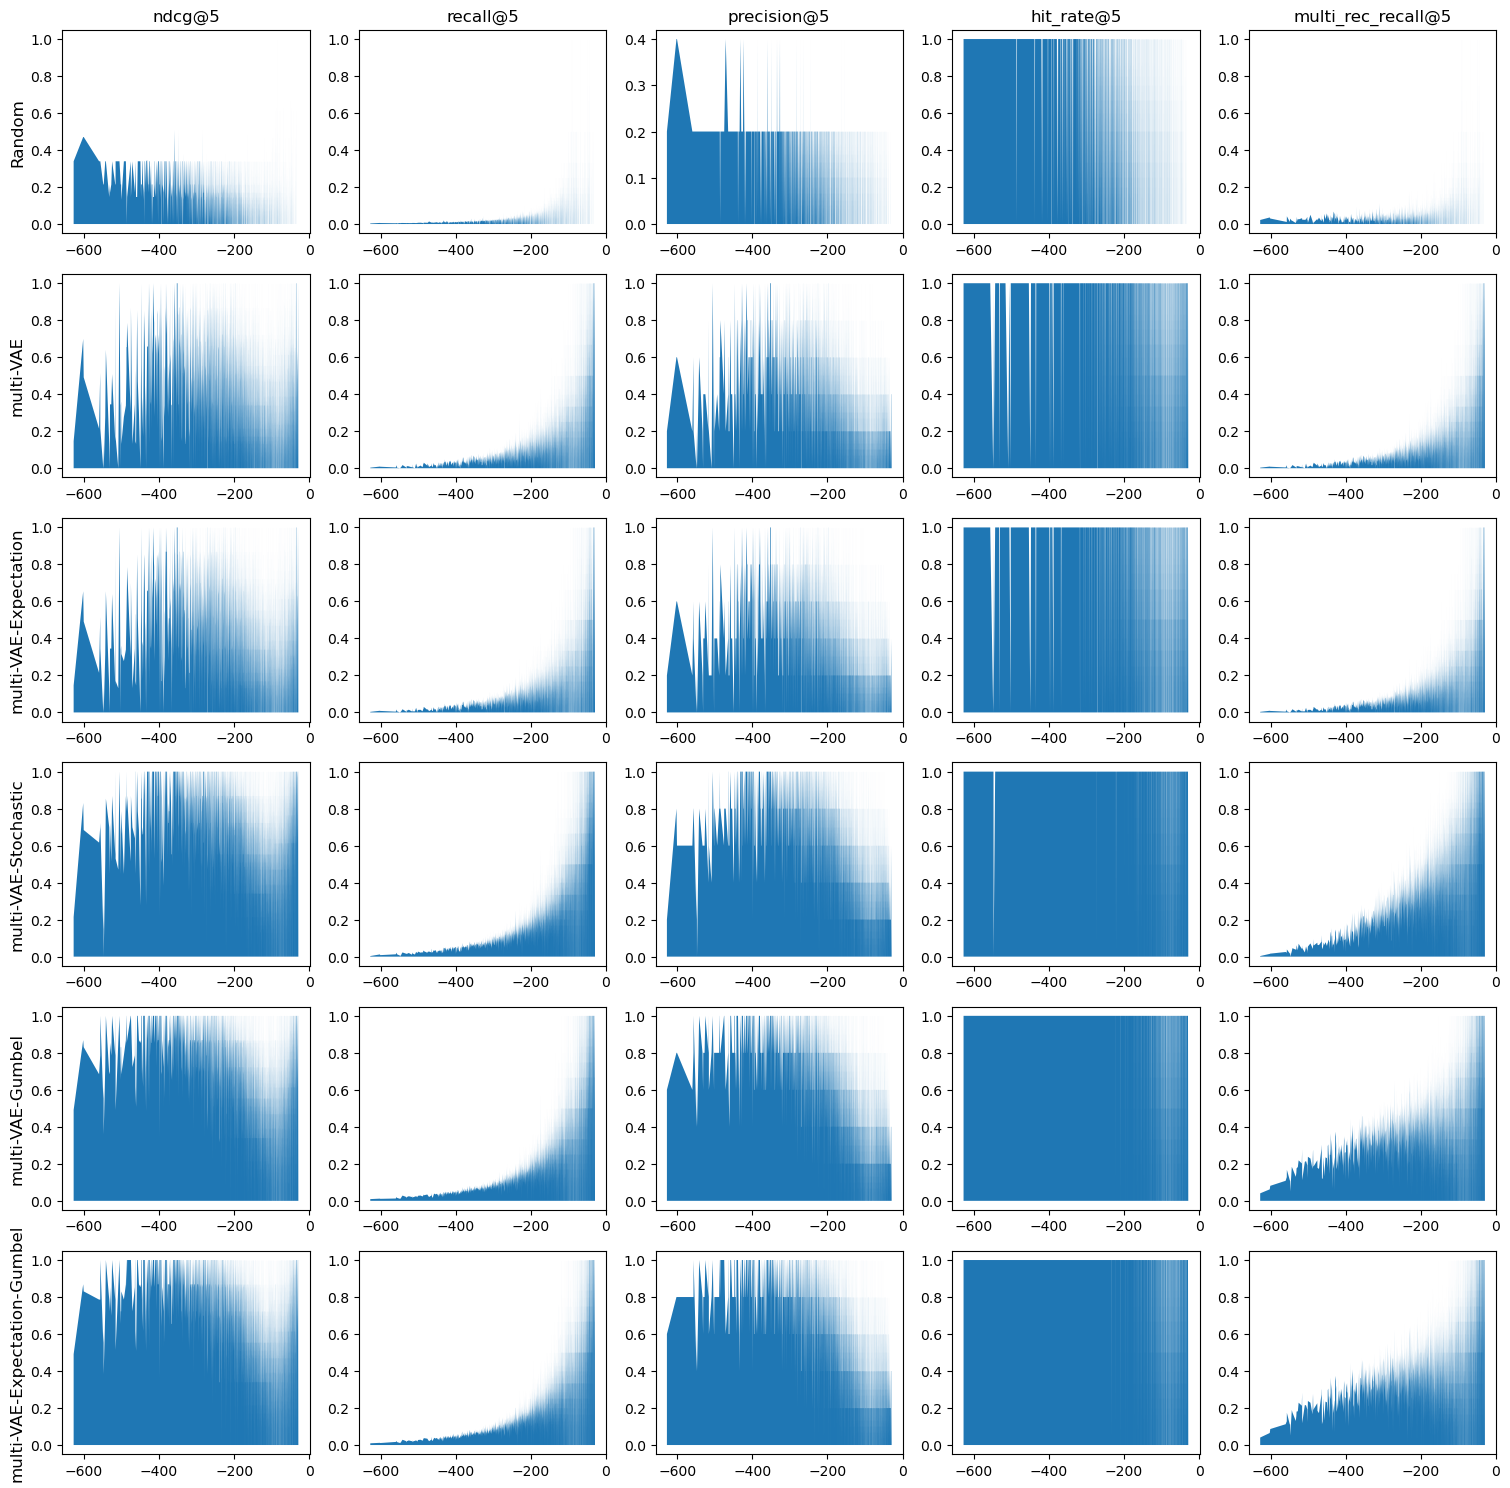

In [562]:
import matplotlib.pyplot as plt

log_var_maxes_topk = torch.topk(log_var_maxes_tensor, log_var_maxes.shape[0])
log_var_maxes = log_var_maxes_topk.values.numpy()
log_var_maxes_indices = log_var_maxes_topk.indices.numpy()

fig = plt.figure()
fig, axes = plt.subplots(len(alg_names), len(metric_names))

for alg_idx, alg_name in enumerate(alg_names):
    axes[alg_idx,0].set_ylabel(alg_name, size='large')
    metrics = algs_dic[alg_name]
    for metric_idx, metric_name in enumerate(metric_names):
        axes[0, metric_idx].set_title(metric_name, size='large')
        metric_list = metrics[metric_name]
        metric_list = np.array(metric_list)
        if metric_name == "prediction_time":
            continue
        elif metric_name == "multi_rec_recall@{}".format(K):
            # axes[alg_idx,metric_idx].fill_between(log_var_maxes, metric_list[log_var_maxes_indices], alpha=0.2)
            axes[alg_idx,metric_idx].fill_between(log_var_maxes, metric_list[log_var_maxes_indices])
        else:
            # axes[alg_idx,metric_idx].fill_between(log_var_maxes,np.mean(metric_list[:,log_var_maxes_indices],axis=0), alpha=0.2)
            axes[alg_idx,metric_idx].fill_between(log_var_maxes,np.max(metric_list[:,log_var_maxes_indices],axis=0))
fig.set_size_inches(18.5, 18.5)
fig.show()

In [54]:
from scipy.sparse import coo_matrix
from collections import Counter
import cupy as cp

def gumbel_inverse(x):
    return -beta*np.log(-np.log(x))


def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mu)


# def my_predict(alg_name, model, data_tensor, **op_dic):
#     model.eval()
#     recon_batch = None
#     match alg_name:
#         case 'multi-VAE':
#             recon_batch = op_dic.get('multi_VAE_recon_batch')
#             if recon_batch is None:
#                 recon_batch, _, _ = model(data_tensor)
#         case 'multi-VAE-Expectation':
#             recon_batch = op_dic.get('multi_VAE_EXP_recon_batch')
#             if recon_batch is None:
#                 for l in range(op_dic['n_sampling']):
#                     # torch.manual_seed(l+10000*kwargs['i_rec'])
#                     torch.manual_seed(l)
#                     mu, logvar = model.encode(data_tensor)
#                     z = reparameterize(mu, logvar)
#                     if l == 0:
#                         recon_batch = model.decode(z)
#                     else:
#                         recon_batch += model.decode(z)
#         case 'multi-VAE-Stochastic':
#             torch.manual_seed(op_dic['i_rec'])
#             mu, logvar = model.encode(data_tensor)
#             z = reparameterize(mu, logvar)
#             recon_batch = model.decode(z)
#         case 'multi-VAE-Stochastic-each-pos':
#             torch.manual_seed(op_dic['i_rec'])
#             mu, logvar = model.encode(data_tensor)
#             z = reparameterize(mu, logvar)
#             recon_batch = model.decode(z)
#         case 'multi-VAE-Gumbel':
#             recon_batch = op_dic.get('multi_VAE_recon_batch')
#             if recon_batch is None:
#                 recon_batch, mu, logvar = model(data_tensor)
#             torch.manual_seed(op_dic['i_rec'])
#             recon_batch = recon_batch - op_dic['params']['beta'] * (-torch.rand(recon_batch.shape, device=device).log()).log()
#         case 'multi-VAE-Expectation-Softmax':
#             recon_batch = op_dic.get('multi_VAE_EXP_Softmax_recon_batch')
#             if recon_batch is None:
#                 for l in range(op_dic['n_sampling']):
#                     # torch.manual_seed(l+10000*kwargs['i_rec'])
#                     torch.manual_seed(l)
#                     mu, logvar = model.encode(data_tensor)
#                     z = reparameterize(mu, logvar)
#                     if l == 0:
#                         recon_batch = F.softmax(model.decode(z),1)
#                     else:
#                         recon_batch += F.softmax(model.decode(z),1)
#         case 'multi-VAE-Expectation-Gumbel':
#             recon_batch = op_dic.get('multi_VAE_EXP_recon_batch')
#             if recon_batch is None:
#                 for l in range(op_dic['n_sampling']):
#                     # torch.manual_seed(l+10000*kwargs['i_rec'])
#                     torch.manual_seed(l)
#                     mu, logvar = model.encode(data_tensor)
#                     z = reparameterize(mu, logvar)
#                     if l == 0:
#                         recon_batch = model.decode(z)
#                     else:
#                         recon_batch += model.decode(z)
#             torch.manual_seed(op_dic['i_rec'])
#             recon_batch = recon_batch - op_dic['params']['beta'] * (-torch.rand(recon_batch.shape, device=device).log()).log() * op_dic['n_sampling']
#         case 'multi-VAE-Stochastic-Gumbel':
#             torch.manual_seed(op_dic['i_rec'])
#             mu, logvar = model.encode(data_tensor)
#             z = reparameterize(mu, logvar)
#             recon_batch = model.decode(z)
#             recon_batch = recon_batch - op_dic['params']['beta'] * (-torch.rand(recon_batch.shape, device=device).log()).log()
#         case 'MostPopular':
#             recon_batch = torch.sum(data_tensor, dim=0).repeat(data_tensor.shape[0],1)
#         case 'Random':
#             torch.manual_seed(op_dic['i_rec'])
#             recon_batch = torch.rand(data_tensor.shape, device=device)
#         case _:
#             print("undefined alg name:{}".format(alg_name))
#             return recon_batch
    
#     ## remove pre-exposed items from candidates
#     recon_batch[data_tensor.nonzero(as_tuple=True)] = -np.inf
#     if op_dic['params'].get('f_avoid_already_recommended_items', False):
#         if op_dic['i_rec'] != 0:
#             recon_batch[(torch.arange(op_dic['pre_topk'].shape[0]).repeat_interleave(op_dic['pre_topk'].shape[1]), op_dic['pre_topk'].flatten())] = -np.inf
    
#     return recon_batch

def get_topk_via_faiss(z, k):
    z_dash = torch.tanh(torch.add(torch.matmul(z,P0.T),p0_bias))
    z_dash_wi_constant = torch.column_stack((z_dash, torch.ones(z_dash.shape[0], device=device)))
    topk_scores, topk_indices = gpu_index_flat.search(z_dash_wi_constant.cpu(), k)
    return topk_indices.astype(np.int64)

def remove_interacted_items(recon_batch, data_tensor, f_avoid_already_recommended_items=False):
    recon_batch[data_tensor.nonzero(as_tuple=True)] = -np.inf
    if f_avoid_already_recommended_items:
        recon_batch[(torch.arange(op_dic['pre_topk'].shape[0]).repeat_interleave(op_dic['pre_topk'].shape[1]), op_dic['pre_topk'].flatten())] = -np.inf
    return recon_batch

def my_topk(alg_name, model, data_tensor, K, **op_dic):
    model.eval()
    recon_batch = None
    topk_indices = None
    match alg_name:
        case 'multi-VAE':
            recon_batch = op_dic.get('multi_VAE_recon_batch')
            if recon_batch is None:
                recon_batch, _, _ = model(data_tensor)
            recon_batch = remove_interacted_items(recon_batch, data_tensor, op_dic['params'].get('f_avoid_already_recommended_items',False) and op_dic.get('i_rec',0))
            topk_indices = torch.topk(recon_batch, K, dim=1).indices#.cpu().numpy()
        case 'multi-VAE-Faiss-Comp':
            mu, _ = model.encode(data_tensor)
            topk_indices = get_topk_via_faiss(mu, K*np.ones(mu.shape[0])+op_dic['max_n_already_intaracted_items'])
            recon_batch = np.ones((n_batch_user,n_items)) * (-np.inf)
            np.put_along_axis(recon_batch, topk_indices, topk_scores, axis=1)
            recon_batch_dummy[data.nonzero()] = -np.inf
            topk_indices = torch.topk(recon_batch, K, dim=1).indices.cpu().numpy()
            ## https://gist.github.com/EdisonLeeeee/df5a2427f902312bbd29151f79e728ab  (numpy.topk)
        case 'multi-VAE-Expectation':
            recon_batch = op_dic.get('multi_VAE_EXP_recon_batch')
            if recon_batch is None:
                for l in range(op_dic['n_sampling']):
                    # torch.manual_seed(l+10000*kwargs['i_rec'])
                    torch.manual_seed(l)
                    mu, logvar = model.encode(data_tensor)
                    z = reparameterize(mu, logvar)
                    if l == 0:
                        recon_batch = model.decode(z)
                    else:
                        recon_batch += model.decode(z)
            recon_batch = remove_interacted_items(recon_batch, data_tensor, op_dic['params'].get('f_avoid_already_recommended_items',False) and op_dic.get('i_rec',0))
            topk_indices = torch.topk(recon_batch, K, dim=1).indices#.cpu().numpy()
        case 'multi-VAE-MAX':
            recon_batch = op_dic.get('multi_VAE_EXP_recon_batch')
            if recon_batch is None:
                recon_batches = []
                # z_s = []
                mu, logvar = model.encode(data_tensor)
                for l in range(op_dic['n_sampling']):
                    torch.manual_seed(l)
                    z = reparameterize(mu, logvar)
                    # z_s.append(reparameterize(mu, logvar))
                    recon_batches.append(model.decode(z))
                    # if l == 0:
                    #     recon_batch = model.decode(z)
                    # else:
                    #     recon_batch = torch.stack((recon_batch,model.decode(z)), dim=2)
                recon_batches = torch.stack(recon_batches, dim=2)
                # z_s = torch.stack(z_s, dim=2)
                # recon_batch = model.decode(z_s)
                recon_batch,_ = recon_batches.max(dim=2)
            recon_batch = remove_interacted_items(recon_batch, data_tensor, op_dic['params'].get('f_avoid_already_recommended_items',False) and op_dic.get('i_rec',0))
            topk_indices = torch.topk(recon_batch, K, dim=1).indices
        case 'multi-VAE-Stochastic':
            torch.manual_seed(op_dic['i_rec'])
            mu, logvar = model.encode(data_tensor)
            z = reparameterize(mu, logvar) #- 1 * (-torch.rand(mu.shape, device=device).log()).log()
            recon_batch = model.decode(z)
            recon_batch = remove_interacted_items(recon_batch, data_tensor, op_dic['params'].get('f_avoid_already_recommended_items',False) and op_dic.get('i_rec',0))
            topk_indices = torch.topk(recon_batch, K, dim=1).indices#.cpu().numpy()
        case 'multi-VAE-Stochastic-MultiSampling':
            torch.manual_seed(op_dic['i_rec'])
            mu, logvar = model.encode(data_tensor)
            topk_indices = []
            for k in range(K):
                z = reparameterize(mu, logvar)
                recon_batch = model.decode(z)
                recon_batch = remove_interacted_items(recon_batch, data_tensor, op_dic['params'].get('f_avoid_already_recommended_items',False) and op_dic.get('i_rec',0))
                topk_indices.append(torch.topk(recon_batch, 1, dim=1).indices)
            topk_indices = torch.cat(topk_indices, dim=1)
        case 'multi-VAE-Gumbel':
            # recon_batch = op_dic.get('multi_VAE_recon_batch')
            # if recon_batch is None:
            recon_batch, _, _ = model(data_tensor)
            torch.manual_seed(op_dic['i_rec'])
            recon_batch_gs = recon_batch - op_dic['params']['beta'] * (-torch.rand(recon_batch.shape, device=device).log()).log()
            recon_batch_gs = remove_interacted_items(recon_batch_gs, data_tensor, op_dic['params'].get('f_avoid_already_recommended_items',False) and op_dic.get('i_rec',0))
            topk_indices = torch.topk(recon_batch_gs, K, dim=1).indices#.cpu().numpy()
        case 'multi-VAE-Gumbel-MultiSampling':
            # recon_batch = op_dic.get('multi_VAE_recon_batch')
            # if recon_batch is None:
            recon_batch, _, _ = model(data_tensor)
            torch.manual_seed(op_dic['i_rec'])
            topk_indices = []
            for k in range(K):
                torch.manual_seed(op_dic['i_rec']+k*10000)
                recon_batch_gs = recon_batch - op_dic['params']['beta'] * (-torch.rand(recon_batch.shape, device=device).log()).log()
                recon_batch_gs = remove_interacted_items(recon_batch_gs, data_tensor, op_dic['params'].get('f_avoid_already_recommended_items',False) and op_dic.get('i_rec',0))
                topk_indices.append(torch.topk(recon_batch_gs, 1, dim=1).indices)
            topk_indices = torch.cat(topk_indices, dim=1)
        case 'multi-VAE-Expectation-Softmax':
            recon_batch = op_dic.get('multi_VAE_EXP_Softmax_recon_batch')
            if recon_batch is None:
                for l in range(op_dic['n_sampling']):
                    # torch.manual_seed(l+10000*kwargs['i_rec'])
                    torch.manual_seed(l)
                    mu, logvar = model.encode(data_tensor)
                    z = reparameterize(mu, logvar)
                    if l == 0:
                        recon_batch = F.softmax(model.decode(z),1)
                    else:
                        recon_batch += F.softmax(model.decode(z),1)
            recon_batch = remove_interacted_items(recon_batch, data_tensor, op_dic['params'].get('f_avoid_already_recommended_items',False) and op_dic.get('i_rec',0))
            topk_indices = torch.topk(recon_batch, K, dim=1).indices#.cpu().numpy()
        case 'multi-VAE-Expectation-Gumbel':
            recon_batch = op_dic.get('multi_VAE_EXP_recon_batch')
            if recon_batch is None:
                for l in range(op_dic['n_sampling']):
                    # torch.manual_seed(l+10000*kwargs['i_rec'])
                    torch.manual_seed(l)
                    mu, logvar = model.encode(data_tensor)
                    z = reparameterize(mu, logvar)
                    if l == 0:
                        recon_batch = model.decode(z)
                    else:
                        recon_batch += model.decode(z)
            torch.manual_seed(op_dic['i_rec'])
            recon_batch = recon_batch - op_dic['params']['beta'] * (-torch.rand(recon_batch.shape, device=device).log()).log() * op_dic['n_sampling']
            recon_batch = remove_interacted_items(recon_batch, data_tensor, op_dic['params'].get('f_avoid_already_recommended_items',False) and op_dic.get('i_rec',0))
            topk_indices = torch.topk(recon_batch, K, dim=1).indices#.cpu().numpy()
        case 'multi-VAE-Stochastic-Gumbel':
            torch.manual_seed(op_dic['i_rec'])
            mu, logvar = model.encode(data_tensor)
            z = reparameterize(mu, logvar)
            recon_batch = model.decode(z)
            recon_batch = recon_batch - op_dic['params']['beta'] * (-torch.rand(recon_batch.shape, device=device).log()).log()
            recon_batch = remove_interacted_items(recon_batch, data_tensor, op_dic['params'].get('f_avoid_already_recommended_items',False) and op_dic.get('i_rec',0))
            topk_indices = torch.topk(recon_batch, K, dim=1).indices#.cpu().numpy()
        case 'MostPopular':
            recon_batch = torch.sum(data_tensor, dim=0).repeat(data_tensor.shape[0],1)
            recon_batch = remove_interacted_items(recon_batch, data_tensor, op_dic['params'].get('f_avoid_already_recommended_items',False) and op_dic.get('i_rec',0))
            topk_indices = torch.topk(recon_batch, K, dim=1).indices#.cpu().numpy()
        case 'Random':
            torch.manual_seed(op_dic['i_rec'])
            recon_batch = torch.rand(data_tensor.shape, device=device)
            recon_batch = remove_interacted_items(recon_batch, data_tensor, op_dic['params'].get('f_avoid_already_recommended_items',False) and op_dic.get('i_rec',0))
            topk_indices = torch.topk(recon_batch, K, dim=1).indices#.cpu().numpy()
        case _:
            print("undefined alg name:{}".format(alg_name))
            return topk_indices, recon_batch
    
    return topk_indices, recon_batch

        
def my_evaluate(topk_indices, heldout_batch, metric_name):
    n_batch_users = heldout_batch.shape[0]
    n_items = heldout_batch.shape[1]
    k = topk_indices.shape[1]

    binary_relevance = torch.gather(heldout_batch, 1, topk_indices, sparse_grad=True)
    
    match metric_name:
        case "ndcg":
            tp = 1 / torch.log2(torch.arange(2, k + 2).float().to('cuda'))
            DCG = (binary_relevance * tp).sum(dim=1)
            IDCG = (torch.sort(heldout_batch, dim=1, descending=True)[0][:,:k] * tp).sum(dim=1)
            return (DCG / IDCG).cpu().numpy()

        case "recall":
            true_binary = (heldout_batch > 0)#.toarray()
            recall = binary_relevance.sum(axis=1) / true_binary.sum(axis=1)
            
            return recall.cpu().numpy()
            
        case "precision":
            precision = binary_relevance.sum(axis=1) / k
            
            return precision.cpu().numpy()
            
        case "hit_rate":   
            idx_not_satisfied_users = torch.where((binary_relevance == False).all(axis=1))[0]
            hits = np.where(binary_relevance.sum(axis=1).cpu().numpy() > 0, 1 ,0)
            
            return hits
        
        case _:
            print("undefined metric name:{}".format(metric_name))
            return None
            

def evaluate_multi_rec(data_tr, data_te, n_sampling=1, n_rec=1, K=20):
    # Turn on evaluation mode
    model.eval()
    total_loss = 0.0
    global update_count
    e_idxlist = list(range(data_tr.shape[0]))
    e_N = data_tr.shape[0]
    
    metrics_dic = {
        # "ndcg@{}".format(K):[[] for _ in range(n_rec)],
        # "recall@{}".format(K):[[] for _ in range(n_rec)],
        # "precision@{}".format(K):[[] for _ in range(n_rec)],
        "hit_rate@{}".format(K): [[] for _ in range(n_rec)],
        "prediction_time": [[] for _ in range(n_rec)],
        "recall@{}_in_{}recs".format(K,n_rec): [[] for _ in range(n_rec)],
        # "recall@{}_in_{}recs".format(K,n_rec):[],
    }
    
    methods_dic = {
        "Random":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"Random","params":{}},
        "MP":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"MostPopular","params":{}},
        "multi-VAE":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE","params":{}},
        # "multi-VAE-MAX":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-MAX","params":{}},
        # "multi-VAE-NSS-Comp":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Faiss-Comp","params":{}},
        # "multi-VAE-wo-same-items":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE","params":{'f_avoid_already_recommended_items': True}},
        # "multi-VAE-Expectation":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Expectation","params":{}},
        # "multi-VAE-Expectation-wo-same-items":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Expectation","params":{'f_avoid_already_recommended_items': True}},
        # "multi-VAE-Expectation-Softmax":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Expectation-Softmax","params":{}},
        # "multi-VAE-Expectation-Softmax-wo-same-items":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Expectation-Softmax","params":{'f_avoid_already_recommended_items': True}},
        "multi-VAE-Stochastic":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Stochastic","params":{}},
        # "multi-VAE-Stochastic-MultiSampling":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Stochastic-MultiSampling","params":{}},
        # "multi-VAE-Stochastic-wo-same-items":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Stochastic","params":{'f_avoid_already_recommended_items': True}},
        "multi-VAE-Gumbel-beta1":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Gumbel","params":{'beta':1}},
        # "multi-VAE-Gumbel-beta1-MultiSampling":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Gumbel-MultiSampling","params":{'beta':1}},
        "multi-VAE-Gumbel-beta0.2":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Gumbel","params":{'beta':0.2}},
        "multi-VAE-Gumbel-beta0.1":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Gumbel","params":{'beta':0.1}},
        # "multi-VAE-Expectation-Gumbel":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Expectation-Gumbel","params":{'beta':0.2}},
        # "multi-VAE-Stochastic-Gumbel":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Stochastic-Gumbel","params":{'beta':0.2}},
        
        # "Random":copy.deepcopy(metrics_dic),
        # "multi-VAE":copy.deepcopy(metrics_dic),
        # "multi-VAE-Expectation":copy.deepcopy(metrics_dic),
        # "multi-VAE-Stochastic":copy.deepcopy(metrics_dic),
        # "multi-VAE-Gumbel":copy.deepcopy(metrics_dic),
        # "multi-VAE-Expectation-Gumbel":copy.deepcopy(metrics_dic),
        # "multi-VAE-Stochastic-Gumbel":copy.deepcopy(metrics_dic),
        # "multi-VAE-NNS-comp":copy.deepcopy(metrics),
        # "multi-VAE-Faiss-IVF":copy.deepcopy(metrics),
        # "multi-VAE-Gumbel-k":copy.deepcopy(metrics),
        # "multi-VAE-Gumbel-low-beta":copy.deepcopy(metrics),
        # "multi-VAE-Stochastic-k":copy.deepcopy(metrics),
        # "multi-VAE-Stochastic-NNS-comp":copy.deepcopy(metrics),
        # "multi-VAE-Stochastic-Faiss-k":copy.deepcopy(metrics),
        # "multi-VAE-Stochastic-Faiss-IVF":copy.deepcopy(metrics),
    }
    
    users_dic = {
        'n_users':0,
        # 'n_interacts':[],
        'log_vars':[],
               }
    
    with torch.no_grad():
        with tqdm(range(0, e_N, BATCH_SIZE)) as pbar:
        # for start_idx in tqdm(range(0, e_N, BATCH_SIZE)):
            for start_idx in pbar:
                pbar.set_description("[test]")
                  
                end_idx = min(start_idx + BATCH_SIZE, N)
                data_original = data_tr[e_idxlist[start_idx:end_idx]]
                heldout_data_original = data_te[e_idxlist[start_idx:end_idx]]
                
                # n_batch_users = data_original.shape[0]
                # n_test_users += n_batch_users
                
                n_already_intaract_items = data_original.indptr[1:] - data_original.indptr[:-1]
                max_n_already_intaracted_items = int(np.max(n_already_intaract_items))
                
                u_idxlist_wo_any_iteracts = [i for i, x in enumerate(heldout_data_original.toarray().sum(axis=1)) if x >0]
                data_original = data_original[u_idxlist_wo_any_iteracts]
                heldout_data_original = heldout_data_original[u_idxlist_wo_any_iteracts]
                
                # update users-info to save
                # recon_batch, _, log_var = model(data_tensor)
                n_batch_users = data_original.shape[0]
                users_dic['n_users'] += n_batch_users
                # users_dic['log_vars'].append(log_var)
                
                op_dic = {
                    'n_sampling':n_sampling,
                    'i_rec':0,
                    'params':{},
                    "pre_topk":torch.Tensor().to(device),
                    "max_n_already_intaracted_items":max_n_already_intaracted_items,
                    # "pre_topk":torch.zeros(n_batch_users, n_items).to(device),
                    'multi_VAE_recon_batch':None, 
                    'multi_VAE_EXP_recon_batch':None,
                    'multi_VAE_EXP_Softmax_recon_batch':None,
                }
                
                for method_name in methods_dic.keys():                    
                    data = data_original.copy()
                    heldout_data = heldout_data_original.copy()
                    
                    # u_idxlist_wo_any_iteracts = [i for i, x in enumerate(heldout_data.toarray().sum(axis=1)) if x >0]
                    # data = data[u_idxlist_wo_any_iteracts]
                    # heldout_data = heldout_data[u_idxlist_wo_any_iteracts]

                    data_tensor = naive_sparse2tensor(data).to(device)
                    heldout_data_tensor = naive_sparse2tensor(heldout_data).to(device)
                    
                    # add dammy item for updating data_tensor
                    # data_tensor = torch.cat((torch.zeros((data_tensor.shape[0],1)).to(device),data_tensor),dim=1)
                    # heldout_data_tensor = torch.cat((torch.zeros((heldout_data_tensor.shape[0],1)).to(device),heldout_data_tensor),dim=1)
                    
                    all_topk_indices = []
                    op_dic["pre_topk"] = torch.Tensor().to(device)
                    op_dic["params"] = methods_dic[method_name]['params']
                    alg_name = methods_dic[method_name]['alg_name']
                    clicked_indices = None
                    
                    for p in range(n_rec):
                        op_dic['i_rec'] = p
                        
                        if p != 0:
                            new_indices = torch.tensor(cp.array([cp.arange(n_batch_users), clicked_indices])).to(device)
                            new_values = torch.tensor(cp.ones_like(clicked_indices, dtype=cp.float32), dtype=torch.float32).to(device)
                            data_tensor = data_tensor + torch.sparse_coo_tensor(new_indices, new_values, data_tensor.shape)
                        
                        start = time.perf_counter()
                        topk_indices, recon_batch = my_topk(alg_name, model, data_tensor, K, **op_dic)
                        # recon_batch = my_predict(alg_name, model, data_tensor, **op_dic)
                        # topk = torch.topk(recon_batch, K, dim=1) ## quick sort (to check)
                        t_predict = time.perf_counter() - start
                        
                        # topk_indices = torch.Tensor(topk_indices).to(torch.int64).to(device)
                        op_dic["pre_topk"] = torch.cat([op_dic["pre_topk"],topk_indices], dim=1).to(torch.int64)
                        
                        # methods_dic[method_name]["metrics"]["ndcg@{}".format(K)][p].append(my_evaluate(topk.indices, heldout_data_tensor, "ndcg"))
                        # methods_dic[method_name]["metrics"]["recall@{}".format(K)][p].append(my_evaluate(topk.indices, heldout_data_tensor, "recall"))
                        # methods_dic[method_name]["metrics"]["precision@{}".format(K)][p].append(my_evaluate(topk.indices, heldout_data_tensor, "precision"))
                        methods_dic[method_name]["metrics"]["hit_rate@{}".format(K)][p].append(my_evaluate(topk_indices, heldout_data_tensor, "hit_rate"))
                        
                        # get clicked-item indices and position(for viewed-item indices)
                        binaries = torch.gather(heldout_data_tensor, 1, topk_indices, sparse_grad=True)
                        clicked_indices = cp.asarray(topk_indices[torch.arange(n_batch_users), binaries.argmax(dim=1)])
                        # TODO: クリックされたアイテムがない場合、clicked indicesを0にしているが、本来はそのユーザーだけclicked_indicesの追加を無しにしたい。
                        # ユーザーごとにすでにinteractしているアイテムのidを一つとっておき、それを加えるようにする！
                        
                        # calc recall for all predictions
                        all_topk_indices.append(topk_indices)
                        # # all_topk_indices = torch.unique(torch.cat(all_topk_indices, dim=1), dim=1) ## 列数が行によって変化してしまうため、できない
                        all_pred_binary = np.zeros((n_batch_users, n_items), dtype=bool)
                        all_pred_binary[np.arange(n_batch_users)[:, np.newaxis], torch.cat(all_topk_indices, dim=1).cpu().numpy()] = True
                        all_true_binary = (heldout_data > 0).toarray()
                        methods_dic[method_name]["metrics"]["recall@{}_in_{}recs".format(K,n_rec)][p].append((np.logical_and(all_true_binary, all_pred_binary).sum(axis=1)).astype(
            np.float32)/ all_true_binary.sum(axis=1))
                        
                        if "prediction_time" in metrics_dic:
                            methods_dic[method_name]["metrics"]["prediction_time"][p].append(t_predict)
                        else:
                            match method_name:
                                case "multi-VAE":
                                    op_dic['multi_VAE_recon_batch'] = recon_batch
                                case "multi-VAE-Expectation":
                                    op_dic['multi_VAE_EXP_recon_batch'] = recon_batch
                                case "multi-VAE-Expectation-Softmax":
                                    op_dic['multi_VAE_EXP_Softmax_recon_batch'] = recon_batch
    
                    # calc recall for all predictions
        #             all_topk_indices = torch.cat(all_topk_indices, dim=1)
        #             all_pred_binary = np.zeros((n_batch_users, n_items), dtype=bool)
        #             all_pred_binary[np.arange(n_batch_users)[:, np.newaxis], all_topk_indices.cpu().numpy()] = True
        #             all_true_binary = (heldout_data > 0).toarray()
        #             methods_dic[method_name]["metrics"]["recall@{}_in_{}recs".format(K,n_rec)].append((np.logical_and(all_true_binary, all_pred_binary).sum(axis=1)).astype(
        # np.float32)/ all_true_binary.sum(axis=1))
                

    for method_name, method_dic in methods_dic.items():
        for metric_name, metric_list in method_dic["metrics"].items():
                if metric_name == "prediction_time":
                    methods_dic[method_name]["metrics"][metric_name] = np.array(metric_list)
                # elif metric_name == "recall@{}_in_{}recs".format(K,n_rec):
                #     methods_dic[method_name]["metrics"][metric_name] = np.concatenate(metric_list)
                else:
                    for l in range(n_rec):
                        methods_dic[method_name]["metrics"][metric_name][l] = np.array(np.concatenate(metric_list[l]))

    return methods_dic, users_dic

In [55]:
Nrec=10
K = 5
Nsampling = 100
methods_dic, users_dic = evaluate_multi_rec(test_data_tr, test_data_te, n_sampling=Nsampling, n_rec=Nrec, K=K)

n_test_users = users_dic['n_users']

method_names = list(methods_dic.keys())
metric_names = list(methods_dic[method_names[0]]["metrics"].keys())

results_all = []
for method_name, method_dic in methods_dic.items():
    results = []
    for metric_name, metric_list in method_dic["metrics"].items():
        if metric_name == "prediction_time":
            results.append("{:8f}({:8f})".format(np.sum(metric_list)/(n_test_users*Nrec), 0))
        elif metric_name == "recall@{}_in_{}recs".format(K,Nrec):
            metric_list = metric_list[-1]
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        elif metric_name == "hit_rate@{}".format(K):
            recall_in_multi_recs_list = np.array(method_dic["metrics"]["recall@{}_in_{}recs".format(K,Nrec)]).copy()
            
            first_one_indices = (recall_in_multi_recs_list == 1).argmax(axis=0)
            # print(first_one_indices.nonzero())
            # print(recall_in_multi_recs_list[9][first_one_indices.nonzero()])
            for col in range(recall_in_multi_recs_list.shape[1]):
                recall_in_multi_recs_list[(recall_in_multi_recs_list[:, col] == 1) & (np.arange(recall_in_multi_recs_list.shape[0]) != first_one_indices[col]), col] = np.nan
            metric_list = np.nanmean(metric_list*recall_in_multi_recs_list, axis=0)
            # print(recall_in_multi_recs_list[9][first_one_indices.nonzero()])
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        else:
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
print("All")
print("n_test_users:{}".format(n_test_users))
results_all.to_csv('results/run_{}recs_k{}_{}sampling'.format(Nrec, K, Nsampling))
results_all

[test]: 100%|██████████| 20/20 [06:24<00:00, 19.22s/it]


All
n_test_users:9782


,hit_rate@5,prediction_time,recall@5_in_10recs
Random,0.000191(0.000018),0.000003(0.000000),0.001882(0.000181)
MP,0.025962(0.000855),0.000003(0.000000),0.116896(0.001737)
multi-VAE,0.095395(0.001695),0.000012(0.000000),0.296970(0.002620)
multi-VAE-MAX,0.088603(0.001594),0.003490(0.000000),0.291988(0.002647)
multi-VAE-Stochastic,0.115792(0.001662),0.000011(0.000000),0.353859(0.002783)
multi-VAE-Gumbel-beta1,0.072765(0.001166),0.000015(0.000000),0.300173(0.002786)
multi-VAE-Gumbel-beta0.2,0.119481(0.001737),0.000015(0.000000),0.353528(0.002707)
multi-VAE-Gumbel-beta0.1,0.107102(0.001707),0.000015(0.000000),0.323776(0.002654)


In [ ]:
Nrec=100
K = 5
Nsampling = 100

methods_dic, users_dic = evaluate_multi_rec(test_data_tr, test_data_te, n_sampling=Nsampling, n_rec=Nrec, K=K)

n_test_users = users_dic['n_users']

method_names = list(methods_dic.keys())
metric_names = list(methods_dic[method_names[0]]["metrics"].keys())

results_all = []
for method_name, method_dic in methods_dic.items():
    results = []
    for metric_name, metric_list in method_dic["metrics"].items():
        if metric_name == "prediction_time":
            results.append("{:8f}({:8f})".format(np.sum(metric_list)/(n_test_users*Nrec), 0))
        elif metric_name == "multi_rec_recall@{}".format(K):
            recall_in_multi_recs_list = np.array(method_dic["metrics"]["recall@{}_in_{}recs".format(K,Nrec)]).copy()
            first_one_indices = (recall_in_multi_recs_list == 1).argmax(axis=0)
            for col in range(recall_in_multi_recs_list.shape[1]):
                recall_in_multi_recs_list[(recall_in_multi_recs_list[:, col] == 1) & (np.arange(recall_in_multi_recs_list.shape[0]) != first_one_indices[col]), col] = np.nan
            metric_list = np.nanmean(metric_list*recall_in_multi_recs_list, axis=0)
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        elif metric_name == "hit_rate@{}".format(K):
            metric_list = np.mean(metric_list, axis=0)
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        else:
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
print("All")
print("n_test_users:{}".format(n_test_users))
results_all.to_csv('results/run_{}recs_k{}_{}sampling'.format(Nrec, K, Nsampling))

results_all = pd.read_csv('results/run_{}recs_k{}_{}sampling'.format(Nrec, K, Nsampling))
results_all

[test]:  30%|███       | 6/20 [18:53<44:06, 189.01s/it]  

In [57]:
results_all

,Unnamed: 0,hit_rate@5,prediction_time,recall@5_in_100recs
0,Random,0.003534(0.000079),0.000003(0.000000),0.011944(0.004890)
1,MP,0.040061(0.000472),0.000003(0.000000),0.233817(0.023950)
2,multi-VAE,0.072128(0.000745),0.000017(0.000000),0.478181(0.030154)
3,multi-VAE-MAX,0.070291(0.000723),0.003490(0.000000),0.470511(0.030312)
4,multi-VAE-Stochastic,0.076928(0.000785),0.000011(0.000000),0.528013(0.030228)
5,multi-VAE-Gumbel-beta1,0.088220(0.000917),0.000016(0.000000),0.561787(0.031636)
6,multi-VAE-Gumbel-beta0.2,0.081883(0.000895),0.000016(0.000000),0.533083(0.029688)
7,multi-VAE-Gumbel-beta0.1,0.077037(0.000824),0.000016(0.000000),0.503759(0.029890)


In [97]:
Nrec=10
K = 20
Nsampling = 100

methods_dic, users_dic = evaluate_multi_rec(test_data_tr, test_data_te, n_sampling=Nsampling, n_rec=Nrec, K=K)

n_test_users = users_dic['n_users']

method_names = list(methods_dic.keys())
metric_names = list(methods_dic[method_names[0]]["metrics"].keys())

results_all = []
for method_name, method_dic in methods_dic.items():
    results = []
    for metric_name, metric_list in method_dic["metrics"].items():
        if metric_name == "prediction_time":
            results.append("{:8f}({:8f})".format(np.sum(metric_list)/(n_test_users*Nrec), 0))
        elif metric_name == "multi_rec_recall@{}".format(K):
            recall_in_multi_recs_list = np.array(method_dic["metrics"]["recall@{}_in_{}recs".format(K,Nrec)]).copy()
            first_one_indices = (recall_in_multi_recs_list == 1).argmax(axis=0)
            for col in range(recall_in_multi_recs_list.shape[1]):
                recall_in_multi_recs_list[(recall_in_multi_recs_list[:, col] == 1) & (np.arange(recall_in_multi_recs_list.shape[0]) != first_one_indices[col]), col] = np.nan
            metric_list = np.nanmean(metric_list*recall_in_multi_recs_list, axis=0)
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        elif metric_name == "hit_rate@{}".format(K):
            metric_list = np.mean(metric_list, axis=0)
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        else:
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
print("All")
print("n_test_users:{}".format(n_test_users))
results_all.to_csv('results/run_{}recs_k{}_{}sampling'.format(Nrec, K, Nsampling))

results_all = pd.read_csv('results/run_{}recs_k{}_{}sampling'.format(Nrec, K, Nsampling))
results_all

[test]: 100%|██████████| 20/20 [01:28<00:00,  4.42s/it]

All
n_test_users:9782


,Unnamed: 0,hit_rate@20,prediction_time,recall@20_in_10recs
0,Random,0.013576(0.000419),0.000003(0.000000),0.005577(0.011356)
1,MP,0.194285(0.002313),0.000002(0.000000),0.163875(0.063448)
2,multi-VAE,0.401390(0.003107),0.000011(0.000000),0.401601(0.090058)
3,multi-VAE-Stochastic,0.450000(0.003162),0.000012(0.000000),0.456876(0.091962)
4,multi-VAE-Stochastic-MultiSampling,0.319587(0.002413),0.000204(0.000000),0.293647(0.085486)
5,multi-VAE-Gumbel-beta1,0.453639(0.002982),0.000015(0.000000),0.427999(0.098312)
6,multi-VAE-Gumbel-beta1-MultiSampling,0.445584(0.002954),0.000164(0.000000),0.413328(0.096455)
7,multi-VAE-Gumbel-beta0.2,0.449223(0.003257),0.000015(0.000000),0.449683(0.089946)
8,multi-VAE-Gumbel-beta0.1,0.424617(0.003197),0.000015(0.000000),0.423623(0.089657)


In [98]:
Nrec=100
K = 20
Nsampling = 10

methods_dic, users_dic = evaluate_multi_rec(test_data_tr, test_data_te, n_sampling=Nsampling, n_rec=Nrec, K=K)

n_test_users = users_dic['n_users']

method_names = list(methods_dic.keys())
metric_names = list(methods_dic[method_names[0]]["metrics"].keys())

results_all = []
for method_name, method_dic in methods_dic.items():
    results = []
    for metric_name, metric_list in method_dic["metrics"].items():
        if metric_name == "prediction_time":
            results.append("{:8f}({:8f})".format(np.sum(metric_list)/(n_test_users*Nrec), 0))
        elif metric_name == "multi_rec_recall@{}".format(K):
            recall_in_multi_recs_list = np.array(method_dic["metrics"]["recall@{}_in_{}recs".format(K,Nrec)]).copy()
            first_one_indices = (recall_in_multi_recs_list == 1).argmax(axis=0)
            for col in range(recall_in_multi_recs_list.shape[1]):
                recall_in_multi_recs_list[(recall_in_multi_recs_list[:, col] == 1) & (np.arange(recall_in_multi_recs_list.shape[0]) != first_one_indices[col]), col] = np.nan
            metric_list = np.nanmean(metric_list*recall_in_multi_recs_list, axis=0)
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        elif metric_name == "hit_rate@{}".format(K):
            metric_list = np.mean(metric_list, axis=0)
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        else:
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
print("All")
print("n_test_users:{}".format(n_test_users))
results_all.to_csv('results/run_{}recs_k{}_{}sampling'.format(Nrec, K, Nsampling))

results_all = pd.read_csv('results/run_{}recs_k{}_{}sampling'.format(Nrec, K, Nsampling))
results_all

[test]: 100%|██████████| 20/20 [13:13<00:00, 39.70s/it]

All
n_test_users:9782


,Unnamed: 0,hit_rate@20,prediction_time,recall@20_in_100recs
0,Random,0.013413(0.000223),0.000003(0.000000),0.048187(0.010114)
1,MP,0.043175(0.000509),0.000003(0.000000),0.269312(0.024702)
2,multi-VAE,0.077572(0.000805),0.000017(0.000000),0.555578(0.029293)
3,multi-VAE-Stochastic,0.085604(0.000888),0.000017(0.000000),0.629604(0.028364)
4,multi-VAE-Stochastic-MultiSampling,0.078337(0.000800),0.000199(0.000000),0.543889(0.030219)
5,multi-VAE-Gumbel-beta1,0.116425(0.001375),0.000015(0.000000),0.770679(0.026082)
6,multi-VAE-Gumbel-beta1-MultiSampling,0.115985(0.001371),0.000163(0.000000),0.763957(0.026388)
7,multi-VAE-Gumbel-beta0.2,0.092376(0.001059),0.000015(0.000000),0.629941(0.027850)
8,multi-VAE-Gumbel-beta0.1,0.084687(0.000931),0.000016(0.000000),0.587351(0.028634)


In [ ]:
Nrec=1000
K = 20
Nsampling = 1000

methods_dic, users_dic = evaluate_multi_rec(test_data_tr, test_data_te, n_sampling=Nsampling, n_rec=Nrec, K=K)

n_test_users = users_dic['n_users']

method_names = list(methods_dic.keys())
metric_names = list(methods_dic[method_names[0]]["metrics"].keys())

results_all = []
for method_name, method_dic in methods_dic.items():
    results = []
    for metric_name, metric_list in method_dic["metrics"].items():
        if metric_name == "prediction_time":
            results.append("{:8f}({:8f})".format(np.sum(metric_list)/(n_test_users*Nrec), 0))
        elif metric_name == "multi_rec_recall@{}".format(K):
            recall_in_multi_recs_list = np.array(method_dic["metrics"]["recall@{}_in_{}recs".format(K,Nrec)]).copy()
            first_one_indices = (recall_in_multi_recs_list == 1).argmax(axis=0)
            for col in range(recall_in_multi_recs_list.shape[1]):
                recall_in_multi_recs_list[(recall_in_multi_recs_list[:, col] == 1) & (np.arange(recall_in_multi_recs_list.shape[0]) != first_one_indices[col]), col] = np.nan
            metric_list = np.nanmean(metric_list*recall_in_multi_recs_list, axis=0)
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        elif metric_name == "hit_rate@{}".format(K):
            metric_list = np.mean(metric_list, axis=0)
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        else:
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
print("All")
print("n_test_users:{}".format(n_test_users))
results_all.to_csv('results/run_{}recs_k{}_{}sampling'.format(Nrec, K, Nsampling))

results_all = pd.read_csv('results/run_{}recs_k{}_{}sampling'.format(Nrec, K, Nsampling))
results_all

[test]:  30%|███       | 6/20 [1:09:51<2:42:54, 698.19s/it]

In [37]:
a = torch.Tensor([[1,0,0,0,1],[0,1,0,0,0]])
a.nonzero()

tensor([[0, 0],
        [0, 4],
        [1, 1]])

In [99]:
results_all = []
for method_name, method_dic in methods_dic.items():
    results = []
    for metric_name, metric_list in method_dic["metrics"].items():
        if metric_name == "prediction_time":
            results.append("{:8f}({:8f})".format(np.sum(metric_list)/(n_test_users*Nrec), 0))
        elif metric_name == "recall@{}_in_{}recs".format(K,Nrec):
            metric_list = metric_list[-1]
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        elif metric_name == "hit_rate@{}".format(K):
            # mask = (method_dic["metrics"]["recall@{}_in_{}recs".format(K,Nrec)]==1)
            # metric_list = np.nanmean(np.where(mask, np.nan, metric_list), axis=0)
            metric_list = np.mean(np.where(mask, np.nan, metric_list), axis=0)
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        else:
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
results_all

,hit_rate@5,prediction_time,recall@5_in_10recs
Random,0.003098(0.000183),0.000003(0.000000),0.001882(0.000181)
MP,0.123553(0.001624),0.000002(0.000000),0.116896(0.001737)
multi-VAE,0.271724(0.002337),0.000013(0.000000),0.296970(0.002620)
multi-VAE-Expectation,0.270906(0.002347),0.000126(0.000000),0.293615(0.002595)
multi-VAE-Stochastic,0.313474(0.002485),0.000011(0.000000),0.353859(0.002783)
multi-VAE-Gumbel-beta0.2,0.323134(0.002636),0.000015(0.000000),0.353528(0.002707)
multi-VAE-Gumbel-beta1,0.234778(0.001867),0.000015(0.000000),0.300173(0.002786)
multi-VAE-Gumbel-beta0.1,0.300112(0.002522),0.000015(0.000000),0.323776(0.002654)


# multi-clicked

In [29]:
# def reparameterize(mu, logvar):
#     return torch.normal(mu, torch.sqrt(torch.exp(logvar)))

def remove_interacted_items(recon_batch, data_tensor, f_avoid_already_recommended_items=False):
    recon_batch[data_tensor.nonzero(as_tuple=True)] = -np.inf
    if f_avoid_already_recommended_items:
        recon_batch[(torch.arange(op_dic['pre_topk'].shape[0]).repeat_interleave(op_dic['pre_topk'].shape[1]), op_dic['pre_topk'].flatten())] = -np.inf
    return recon_batch

def get_topk_via_faiss(index, data, z, k, extra_k, device):
    # z_dash = torch.tanh(torch.add(torch.matmul(z,P0.T),p0_bias))
    z_wi_constant = torch.column_stack((z, torch.ones(z.shape[0], device=device)))
    topk_scores, topk_indices = index.search(z_wi_constant.cpu(), k+extra_k)
    topk_indices = topk_indices.astype(np.int64)
    mask = data[np.arange(topk_indices.shape[0]).reshape(-1, 1), topk_indices] == 0
    topk_indices  = np.array([row[mask_row][:k] for row, mask_row in zip(topk_indices, mask)])
    return topk_indices

def my_topk(alg_name, model, data_tensor, K, device, **op_dic):
    model.eval()
    recon_batch = None
    topk_indices = None
    match alg_name:
        case 'original':
            recon_batch = model(data_tensor, dropout_rate = 0, calculate_loss=False)
            recon_batch = remove_interacted_items(recon_batch, data_tensor, op_dic['params'].get('f_avoid_already_recommended_items',False) and op_dic.get('i_rec',0))
            topk_indices = torch.topk(recon_batch, K, dim=1).indices#.cpu().numpy()
        case 'original-faiss':
            mu, _ = model.encoder(data_tensor, dropout_rate = 0)
            # topk_indices = get_topk_via_faiss(mu, K*np.ones(mu.shape[0])+op_dic['max_n_already_intaracted_items'])
            topk_indices = get_topk_via_faiss(op_dic["params"]["faiss_index"], data_tensor.cpu().numpy(), mu, K, op_dic['max_n_already_intaracted_items'], device)
            topk_indices = torch.from_numpy(topk_indices).to(device)
        case 'stochastic':
            torch.manual_seed(op_dic['i_rec'])
            model.train()
            recon_batch = model(data_tensor, dropout_rate = 0, calculate_loss=False)
            model.eval()
            recon_batch = remove_interacted_items(recon_batch, data_tensor, op_dic['params'].get('f_avoid_already_recommended_items',False) and op_dic.get('i_rec',0))
            topk_indices = torch.topk(recon_batch, K, dim=1).indices#.cpu().numpy()
        case 'stochastic-faiss':
            torch.manual_seed(op_dic['i_rec'])
            model.train()
            mu, logvar = model.encoder(data_tensor, dropout_rate = 0)
            z = model.reparameterize(mu, logvar)
            model.eval()
            # z = torch.normal(mu, torch.sqrt(torch.exp(logvar)))
            topk_indices = get_topk_via_faiss(op_dic["params"]["faiss_index"], data_tensor.cpu().numpy(), z, K, op_dic['max_n_already_intaracted_items'], device)
            topk_indices = torch.from_numpy(topk_indices).to(device)
        case 'gumbel':
            # recon_batch = op_dic.get('multi_VAE_recon_batch')
            # if recon_batch is None:
            recon_batch = model(data_tensor, dropout_rate = 0, calculate_loss=False)
            torch.manual_seed(op_dic['i_rec'])
            recon_batch_gs = F.gumbel_softmax(recon_batch, tau=op_dic['params']['beta'],dim=1)
            # recon_batch_gs = recon_batch - op_dic['params']['beta'] * (-torch.rand(recon_batch.shape, device=device).log()).log()
            recon_batch_gs = remove_interacted_items(recon_batch_gs, data_tensor, op_dic['params'].get('f_avoid_already_recommended_items',False) and op_dic.get('i_rec',0))
            topk_indices = torch.topk(recon_batch_gs, K, dim=1).indices#.cpu().numpy()
        case 'most-popular':
            recon_batch = torch.sum(data_tensor, dim=0).repeat(data_tensor.shape[0],1)
            recon_batch = remove_interacted_items(recon_batch, data_tensor, op_dic['params'].get('f_avoid_already_recommended_items',False) and op_dic.get('i_rec',0))
            topk_indices = torch.topk(recon_batch, K, dim=1).indices#.cpu().numpy()
        case 'random':
            torch.manual_seed(op_dic['i_rec'])
            recon_batch = torch.rand(data_tensor.shape, device=device)
            recon_batch = remove_interacted_items(recon_batch, data_tensor, op_dic['params'].get('f_avoid_already_recommended_items',False) and op_dic.get('i_rec',0))
            topk_indices = torch.topk(recon_batch, K, dim=1).indices#.cpu().numpy()
        case _:
            print("undefined alg name:{}".format(alg_name))
            return topk_indices, recon_batch
    
    return topk_indices, recon_batch

In [30]:
def my_evaluate(topk_indices, heldout_batch, device, metric_name):
    n_batch_users = heldout_batch.shape[0]
    n_items = heldout_batch.shape[1]
    k = topk_indices.shape[1]

    binary_relevance = torch.gather(heldout_batch, 1, topk_indices, sparse_grad=True)
    
    match metric_name:
        case "ndcg":
            tp = 1 / torch.log2(torch.arange(2, k + 2).float().to(device))
            DCG = (binary_relevance * tp).sum(dim=1)
            IDCG = (torch.sort(heldout_batch, dim=1, descending=True)[0][:,:k] * tp).sum(dim=1)
            return (DCG / IDCG).cpu().numpy()

        case "recall":
            true_binary = (heldout_batch > 0)#.toarray()
            recall = binary_relevance.sum(axis=1) / true_binary.sum(axis=1)
            
            return recall.cpu().numpy()
            
        case "precision":
            precision = binary_relevance.sum(axis=1) / k
            
            return precision.cpu().numpy()
            
        case "hit_rate":   
            idx_not_satisfied_users = torch.where((binary_relevance == False).all(axis=1))[0]
            hits = np.where(binary_relevance.sum(axis=1).cpu().numpy() > 0, 1 ,0)
            
            return hits
        
        case _:
            print("undefined metric name:{}".format(metric_name))
            return None

In [31]:
def evaluate_multi_rec(model, methods_dic, data_tr, data_te, n_sampling=1, n_rec=1, K=20, batch_size = 500, is_cpu=False):
    # Turn on evaluation mode
    model.eval()
    total_loss = 0.0
    global update_count
    e_idxlist = list(range(data_tr.shape[0]))
    e_N = data_tr.shape[0]
    
    users_dic = {
        'n_batch_users':[],
        # 'n_interacts':[],
        'log_vars':[],
               }
    
    if "prediction_time" in metrics_dic or is_cpu:
        device = torch.device("cpu")
        model = model.to(device)
    else:
        device = torch.device("cuda")
        model = model.to(device)
    
    with torch.no_grad():
        with tqdm(range(0, e_N, batch_size)) as pbar:
        # for start_idx in tqdm(range(0, e_N, BATCH_SIZE)):
            for start_idx in pbar:
                pbar.set_description("[test]")
                  
                # get batch data
                end_idx = min(start_idx + BATCH_SIZE, N)
                data = data_tr[e_idxlist[start_idx:end_idx]]
                heldout_data = data_te[e_idxlist[start_idx:end_idx]]
                
                # avoid users who has no interacts
                u_idxlist_wo_any_iteracts = [i for i, x in enumerate(heldout_data.toarray().sum(axis=1)) if x >0]
                data = data[u_idxlist_wo_any_iteracts]
                heldout_data = heldout_data[u_idxlist_wo_any_iteracts]
                
                # save information about already interected items for each user
                n_already_intaract_items = data.indptr[1:] - data.indptr[:-1]
                max_n_already_intaracted_items = int(cp.max(n_already_intaract_items))
                already_intaracted_idx = cp.squeeze(cp.asarray(data.argmax(axis=1)))
                
                # update experiment information to save
                n_batch_users = data.shape[0]
                users_dic['n_batch_users'].append(n_batch_users)
                
                op_dic = {
                    'n_sampling':n_sampling,
                    'i_rec':0,
                    'params':{},
                    "pre_topk":torch.Tensor().to(device),
                    "max_n_already_intaracted_items":max_n_already_intaracted_items,
                    # "pre_topk":torch.zeros(n_batch_users, n_items).to(device),
                    'multi_VAE_recon_batch':None, 
                    'multi_VAE_EXP_recon_batch':None,
                    'multi_VAE_EXP_Softmax_recon_batch':None,
                }
                
                for method_name in methods_dic.keys():    
                    # u_idxlist_wo_any_iteracts = [i for i, x in enumerate(heldout_data.toarray().sum(axis=1)) if x >0]
                    # data = data[u_idxlist_wo_any_iteracts]
                    # heldout_data = heldout_data[u_idxlist_wo_any_iteracts]

                    data_tensor = naive_sparse2tensor(data).to(device)
                    heldout_data_tensor = naive_sparse2tensor(heldout_data).to(device)
                    
                    all_topk_indices = []
                    # op_dic["pre_topk"] = torch.Tensor().to(device)
                    op_dic["params"] = methods_dic[method_name]['params']
                    alg_name = methods_dic[method_name]['alg_name']
                    clicked_indices = None
                    
                    for p in range(n_rec):
                        op_dic['i_rec'] = p
                        
                        start = time.perf_counter()
                        topk_indices, recon_batch = my_topk(alg_name, model, data_tensor, K, device, **op_dic)
                        # recon_batch = my_predict(alg_name, model, data_tensor, **op_dic)
                        # topk = torch.topk(recon_batch, K, dim=1) ## quick sort (to check)
                        t_predict = time.perf_counter() - start
                        
                        #  if topk_indice = -1, map it to already-clicked item-id
                        already_intaracted_idx_tensor_expanded = torch.tensor(already_intaracted_idx).to(device).view(-1, 1).expand_as(topk_indices)
                        topk_indices = torch.where(topk_indices==-1, already_intaracted_idx_tensor_expanded, topk_indices)
                        
                        # topk_indices = torch.Tensor(topk_indices).to(torch.int64).to(device)
                        op_dic["pre_topk"] = torch.cat([op_dic["pre_topk"],topk_indices], dim=1).to(torch.int64)
                        
                        if "ndcg@{}".format(K) in metrics_dic:
                            methods_dic[method_name]["metrics"]["ndcg@{}".format(K)][p].append(my_evaluate(topk_indices, heldout_data_tensor, device, "ndcg"))
                        if "recall@{}".format(K) in metrics_dic:    
                            methods_dic[method_name]["metrics"]["recall@{}".format(K)][p].append(my_evaluate(topk_indices, heldout_data_tensor, device, "recall"))
                        if "precision@{}".format(K) in metrics_dic:    
                            methods_dic[method_name]["metrics"]["precision@{}".format(K)][p].append(my_evaluate(topk_indices, heldout_data_tensor, device, "precision"))
                        if "hit_rate@{}".format(K) in metrics_dic:    
                            methods_dic[method_name]["metrics"]["hit_rate@{}".format(K)][p].append(my_evaluate(topk_indices, heldout_data_tensor, device, "hit_rate"))
                        # get clicked-item indices and position(for viewed-item indices)
                        
                        binaries = torch.gather(heldout_data_tensor, 1, topk_indices, sparse_grad=True)
                        clicked_indices_tensor = torch.zeros_like(heldout_data_tensor).scatter_(1, topk_indices, binaries)
                        # clicked_indices = cp.asarray(topk_indices[torch.arange(n_batch_users), binaries.argmax(dim=1)])
                        # clicked_indices[binaries.max(dim=1) == 0] = already_intaracted_idx[binaries.max(dim=1) == 0]
                                                
                        
                        # calc recall for all predictions
                        if "cumulative_recall@{}".format(K) in metrics_dic: 
                            all_topk_indices.append(topk_indices)
                            # # all_topk_indices = torch.unique(torch.cat(all_topk_indices, dim=1), dim=1) ## 列数が行によって変化してしまうため、できない
                            all_pred_binary = np.zeros((n_batch_users, n_items), dtype=bool)
                            all_pred_binary[np.arange(n_batch_users)[:, np.newaxis], torch.cat(all_topk_indices, dim=1).cpu().numpy()] = True
                            all_true_binary = (heldout_data > 0).toarray()
                            methods_dic[method_name]["metrics"]["cumulative_recall@{}".format(K)][p].append((np.logical_and(all_true_binary, all_pred_binary).sum(axis=1)).astype(
                np.float32)/ all_true_binary.sum(axis=1))
                        
                        if "prediction_time" in metrics_dic:
                            methods_dic[method_name]["metrics"]["prediction_time"][p].append(t_predict)
    
                        # update already-clicked items
                        data_tensor = data_tensor + clicked_indices_tensor
                

    for method_name, method_dic in methods_dic.items():
        for metric_name, metric_list in method_dic["metrics"].items():
                if metric_name == "prediction_time":
                    # print(metric_list)
                    methods_dic[method_name]["metrics"][metric_name] = np.array(metric_list)
                # elif metric_name == "recall@{}_in_{}recs".format(K,n_rec):
                #     methods_dic[method_name]["metrics"][metric_name] = np.concatenate(metric_list)
                else:
                    for l in range(n_rec):
                        methods_dic[method_name]["metrics"][metric_name][l] = np.array(np.concatenate(metric_list[l]))

    return methods_dic, users_dic

[test]: 100%|██████████| 220/220 [2:59:40<00:00, 49.00s/it]  


All
n_test_users:10650


,ndcg@20,recall@20,precision@20,hit_rate@20,cumulative_recall@20
Random,0.000066(0.000035),0.000207(0.000117),0.000019(0.000009),0.000376(0.000188),0.007808(0.000688)
Most Popular,0.012809(0.000683),0.027172(0.001336),0.002610(0.000113),0.049859(0.002109),0.027642(0.001350)
RecVAE,0.072464(0.001636),0.140084(0.002895),0.013577(0.000264),0.229202(0.004073),0.142437(0.002927)
RecVAE(HNSW),0.063077(0.001525),0.122775(0.002737),0.012061(0.000251),0.204413(0.003908),0.124780(0.002767)
RecVAE(Gumbel),0.020169(0.000813),0.045024(0.001700),0.004620(0.000157),0.083192(0.002676),0.312400(0.003794)
RecVAE(Stochastic),0.056076(0.001433),0.108759(0.002580),0.010854(0.000238),0.186197(0.003772),0.287622(0.003735)
"RecVAE(Stochastic,HNSW)",0.049799(0.001335),0.098612(0.002471),0.009859(0.000228),0.169484(0.003635),0.296630(0.003743)


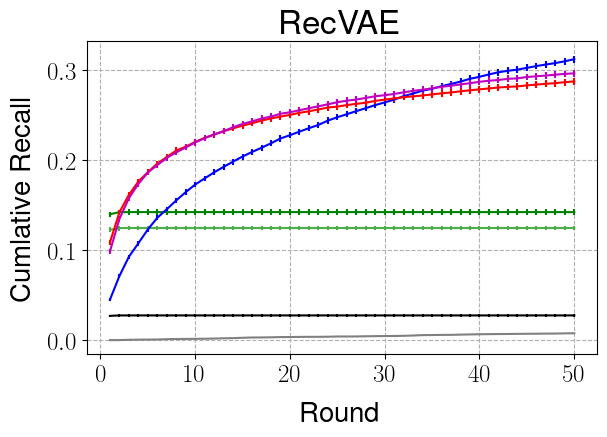

In [ ]:
f_do_eval = False
# f_do_eval = True

Nrec= 50
K = 20
Nsampling = 10
BatchSize = 500

# RESULT_SAVE_PATH = 'results/{}/multi-clicked-K{}-NRec{}'.format('ml-20m', K , Nrec)
RESULT_SAVE_PATH = 'results/{}/{}/multi-clicked-K{}-NRec{}-BatchSize{}'.format(ALGO_NAME,DATASET_NAME, K , Nrec, BatchSize)

if not os.path.exists(RESULT_SAVE_PATH):s
    os.makedirs(RESULT_SAVE_PATH)

metrics_dic = {
    "ndcg@{}".format(K):[[] for _ in range(Nrec)],
    "recall@{}".format(K):[[] for _ in range(Nrec)],
    "precision@{}".format(K):[[] for _ in range(Nrec)],
    "hit_rate@{}".format(K): [[] for _ in range(Nrec)],
    # "prediction_time": [[] for _ in range(Nrec)],
    "cumulative_recall@{}".format(K): [[] for _ in range(Nrec)],
}

methods_dic = {
    "Random":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"random","params":{}},
    "Most Popular":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"most-popular","params":{}},
    "RecVAE":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"original","params":{}},
    "RecVAE(HNSW)":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"original-faiss","params":{'beta':1, "faiss_index":index_hnsw}},
    "RecVAE(Gumbel)":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"gumbel","params":{'beta':1}},
    "RecVAE(Stochastic)":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"stochastic","params":{}},
    "RecVAE(Stochastic,HNSW)":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"stochastic-faiss","params":{"faiss_index":index_hnsw}},
}

if f_do_eval:
    results_dic, users_dic = evaluate_multi_rec(model,methods_dic, test_data_tr, test_data_te, n_sampling=Nsampling, n_rec=Nrec, K=K, batch_size=BatchSize, is_cpu=True)

    with open('{}/results_dic.pkl'.format(RESULT_SAVE_PATH), 'wb') as f:
        pickle.dump(results_dic, f)
    with open('{}/users_dic.pkl'.format(RESULT_SAVE_PATH), 'wb') as f:
        pickle.dump(users_dic, f)
else:
    with open('{}/results_dic.pkl'.format(RESULT_SAVE_PATH), 'rb') as f:
        results_dic = pickle.load(f)
    with open('{}/users_dic.pkl'.format(RESULT_SAVE_PATH), 'rb') as f:
        users_dic = pickle.load(f)
    
n_test_users = np.sum(users_dic['n_batch_users'])

method_names = list(methods_dic.keys())
metric_names = list(methods_dic[method_names[0]]["metrics"].keys())


results_all = []
for method_name, method_dic in results_dic.items():
    results = []
    for metric_name, metric_list in method_dic["metrics"].items():
        if metric_name == "prediction_time":
            metric_list = np.array(metric_list)
            results.append("{:8f}({:8f})".format(np.sum(metric_list)/(n_test_users*Nrec), np.std(np.dot(metric_list, np.diag(1/np.array(users_dic['n_batch_users']))))/np.sqrt(metric_list.shape[0]*metric_list.shape[1])))
        elif metric_name == "cumulative_recall@{}".format(K):
            metric_list = metric_list[-1]
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        # elif metric_name == "hit_rate@{}".format(K):
        # else:
        #     recall_in_multi_recs_list = np.array(method_dic["metrics"]["cumulative_recall@{}".format(K)]).copy()
        #     first_one_indices = (recall_in_multi_recs_list == 1).argmax(axis=0)
        #     for col in range(recall_in_multi_recs_list.shape[1]):
        #         recall_in_multi_recs_list[(recall_in_multi_recs_list[:, col] == 1) & (np.arange(recall_in_multi_recs_list.shape[0]) != first_one_indices[col]), col] = np.nan
        #     metric_list = np.nanmean(metric_list*recall_in_multi_recs_list, axis=0)
        #     results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        else:
            results.append("{:4f}({:4f})".format(np.mean(metric_list[0]), np.std(metric_list[0])/np.sqrt(len(metric_list[0]))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
print("All")
print("n_test_users:{}".format(n_test_users))
results_all.to_csv('{}/metrics.csv'.format(RESULT_SAVE_PATH))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_ylabel("Cumlative Recall", fontsize=20)
ax.set_xlabel("Round", fontsize=20)

colors =  {
    "Random" : "gray",
    "Most Popular" : "black",
    "RecVAE" : "g",
    "RecVAE(HNSW)" : '#4daf4a',
    "RecVAE(Gumbel)" : "b",
    "RecVAE(Gumbel,HNSW)" : "c",
    "RecVAE(Stochastic)" : "r",
    "RecVAE(Stochastic,HNSW)" : "m",
}
markers =  {
    "Random" : ",",
    "Most Popular" : ".",
    "multi-VAE" : "s",
    "multi-VAE(HNSW)" : 'p',
    "multi-VAE(Gumbel)" : "^",
    "multi-VAE(Gumbel,HNSW)" : "v",
    "multi-VAE(Stochastic)" : "x",
    "multi-VAE(Stochastic,HNSW)" : "X",
}

for method_name, method_dic in results_dic.items():
    cumulative_recalls = method_dic["metrics"]["cumulative_recall@{}".format(K)]
    ax.errorbar(np.arange(1,Nrec+1), np.mean(cumulative_recalls, axis=1), yerr = np.std(cumulative_recalls, axis=1)/np.sqrt(len(cumulative_recalls[0])),
                label=method_name,
                color = colors[method_name],
                # marker = markers[method_name],
               )
    # ax.legend()
ax.set_title(ALGO_NAME, fontsize=24)
ax.xaxis.set_label_coords(0.5,-0.15)
ax.yaxis.set_label_coords(-0.1,0.5)
ax.grid(linestyle="--")
fig.tight_layout()
fig.savefig("{}/{}-{}-cum_rec-k{}.eps".format(RESULT_SAVE_PATH, ALGO_NAME, DATASET_NAME, K),format="eps", bbox_inches='tight')
fig.savefig("{}/{}-{}-cum_rec-k{}.png".format(RESULT_SAVE_PATH, ALGO_NAME, DATASET_NAME, K),format="png", bbox_inches='tight')
fig.show()


results_all

In [33]:
f_do_eval = False
# f_do_eval = True

Nrec= 50
K = 20
Nsampling = 10
BatchSize = 500

# RESULT_SAVE_PATH = 'results/{}/multi-clicked-K{}-NRec{}'.format('ml-20m', K , Nrec)
RESULT_SAVE_PATH = 'results/{}/{}/multi-clicked-K{}-NRec{}-BatchSize{}'.format(ALGO_NAME,DATASET_NAME, K , Nrec, BatchSize)

if not os.path.exists(RESULT_SAVE_PATH):
    os.makedirs(RESULT_SAVE_PATH)

metrics_dic = {
    # "ndcg@{}".format(K):[[] for _ in range(Nrec)],
    # "recall@{}".format(K):[[] for _ in range(Nrec)],
    # "precision@{}".format(K):[[] for _ in range(Nrec)],
    # "hit_rate@{}".format(K): [[] for _ in range(Nrec)],
    "prediction_time": [[] for _ in range(Nrec)],
    # "cumulative_recall@{}".format(K): [[] for _ in range(Nrec)],
}

methods_dic = {
    "Random":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"random","params":{}},
    "Most Popular":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"most-popular","params":{}},
    "RecVAE":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"original","params":{}},
    "RecVAE(HNSW)":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"original-faiss","params":{'beta':1, "faiss_index":index_hnsw}},
    "RecVAE(Gumbel)":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"gumbel","params":{'beta':1}},
    "RecVAE(Stochastic)":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"stochastic","params":{}},
    "RecVAE(Stochastic,HNSW)":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"stochastic-faiss","params":{"faiss_index":index_hnsw}},
}

if f_do_eval:
    results_dic, users_dic = evaluate_multi_rec(model,methods_dic, test_data_tr, test_data_te, n_sampling=Nsampling, n_rec=Nrec, K=K, batch_size=BatchSize, is_cpu=True)

    with open('{}/time_results_dic.pkl'.format(RESULT_SAVE_PATH), 'wb') as f:
        pickle.dump(results_dic, f)
    with open('{}/time_users_dic.pkl'.format(RESULT_SAVE_PATH), 'wb') as f:
        pickle.dump(users_dic, f)
else:
    with open('{}/time_results_dic.pkl'.format(RESULT_SAVE_PATH), 'rb') as f:
        results_dic = pickle.load(f)
    with open('{}/time_users_dic.pkl'.format(RESULT_SAVE_PATH), 'rb') as f:
        users_dic = pickle.load(f)
    
n_test_users = np.sum(users_dic['n_batch_users'])

method_names = list(methods_dic.keys())
metric_names = list(methods_dic[method_names[0]]["metrics"].keys())


results_all = []
for method_name, method_dic in results_dic.items():
    results = []
    for metric_name, metric_list in method_dic["metrics"].items():
        if metric_name == "prediction_time":
            metric_list = np.array(metric_list)
            metric_list = np.sum(metric_list, axis=1)
            results.append("{:3f}({:3f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        elif metric_name == "cumulative_recall@{}".format(K):
            metric_list = metric_list[-1]
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        # elif metric_name == "hit_rate@{}".format(K):
        # else:
        #     recall_in_multi_recs_list = np.array(method_dic["metrics"]["cumulative_recall@{}".format(K)]).copy()
        #     first_one_indices = (recall_in_multi_recs_list == 1).argmax(axis=0)
        #     for col in range(recall_in_multi_recs_list.shape[1]):
        #         recall_in_multi_recs_list[(recall_in_multi_recs_list[:, col] == 1) & (np.arange(recall_in_multi_recs_list.shape[0]) != first_one_indices[col]), col] = np.nan
        #     metric_list = np.nanmean(metric_list*recall_in_multi_recs_list, axis=0)
        #     results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        else:
            results.append("{:4f}({:4f})".format(np.mean(metric_list[0]), np.std(metric_list[0])/np.sqrt(len(metric_list[0]))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
print("All")
print("n_test_users:{}".format(n_test_users))
# results_all.to_csv('{}/metrics.csv'.format(RESULT_SAVE_PATH))

results_all

All
n_test_users:10650


,prediction_time
Random,10.142486(0.010813)
Most Popular,2.957281(0.002169)
RecVAE,17.401916(0.031405)
RecVAE(HNSW),11.638120(0.016182)
RecVAE(Gumbel),19.816342(0.021286)
RecVAE(Stochastic),17.340276(0.013223)
"RecVAE(Stochastic,HNSW)",11.789721(0.005751)


In [57]:
results_all = []
for method_name, method_dic in results_dic.items():
    results = []
    for metric_name, metric_list in method_dic["metrics"].items():
        if metric_name == "prediction_time":
            metric_list = np.array(metric_list)
            results.append("{:8f}({:8f})".format(np.sum(metric_list)/(n_test_users*Nrec), np.std(np.dot(metric_list, np.diag(1/np.array(users_dic['n_batch_users']))))/np.sqrt(metric_list.shape[0]*metric_list.shape[1])))
        elif metric_name == "cumulative_recall@{}".format(K):
            metric_list = metric_list[-1]
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        else:
            results.append("{:4f}({:4f})".format(np.mean(metric_list[0]), np.std(metric_list[0])/np.sqrt(len(metric_list[0]))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
results_all

,ndcg@20,hit_rate@20,prediction_time,cumulative_recall@20
Random,0.000946(0.000121),0.012370(0.001118),0.000183(0.000001),0.019165(0.000666)
Most Popular,0.139747(0.001658),0.628399(0.004886),0.000079(0.000000),0.156251(0.001996)
multi-VAE,0.328309(0.002224),0.874668(0.003348),0.000460(0.000003),0.392252(0.002867)
multi-VAE(HNSW),0.311475(0.002236),0.852893(0.003581),0.000253(0.000001),0.364052(0.002877)
multi-VAE(Gumbel),0.120601(0.001348),0.679922(0.004717),0.000597(0.000004),0.699578(0.002559)
multi-VAE(Stochastic),0.305138(0.002154),0.860560(0.003502),0.000463(0.000003),0.548021(0.002890)
"multi-VAE(Stochastic,HNSW)",0.290249(0.002165),0.837457(0.003730),0.000261(0.000002),0.534387(0.002871)


In [ ]:
Nrec= 50
K = 20
Nsampling = 10

metrics_dic = {
    # "ndcg@{}".format(K):[[] for _ in range(n_rec)],
    # "recall@{}".format(K):[[] for _ in range(n_rec)],
    # "precision@{}".format(K):[[] for _ in range(n_rec)],
    # "hit_rate@{}".format(K): [[] for _ in range(n_rec)],
    "prediction_time": [[] for _ in range(Nrec)],
    # "cumulative_recall@{}".format(K): [[] for _ in range(Nrec)],
}

methods_dic = {
    "Random":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"Random","params":{}},
    "Most Popular":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"MostPopular","params":{}},
    "multi-VAE":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE","params":{}},
    "multi-VAE(Gumbel)":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Gumbel","params":{'beta':1}},
    "multi-VAE(Stochastic)":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Stochastic","params":{}},
}

methods_dic, users_dic = evaluate_multi_rec(methods_dic, test_data_tr, test_data_te, n_sampling=Nsampling, n_rec=Nrec, K=K)

n_test_users = users_dic['n_users']

method_names = list(methods_dic.keys())
metric_names = list(methods_dic[method_names[0]]["metrics"].keys())

print(metric_names)

results_all = []
for method_name, method_dic in methods_dic.items():
    results = []
    for metric_name, metric_list in method_dic["metrics"].items():
        if metric_name == "prediction_time":
            metric_list = np.array(metric_list)
            metric_list = np.sum(metric_list, axis=1)
            results.append("{:8f}({:8f})".format(np.sum(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
            # results.append("{:8f}({:8f})".format(np.sum(metric_list)/(n_test_users*Nrec), np.std(np.dot(np.diag(1/user_dic['n_batch_users']), metric_list))/np.sqrt(metric_list.shape[0]*metric_list.shape[1])))
        elif metric_name == "cumulative_recall@{}".format(K):
            metric_list = metric_list[-1]
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        elif metric_name == "hit_rate@{}".format(K):
            recall_in_multi_recs_list = np.array(method_dic["metrics"]["cumulative_recall@{}".format(K)]).copy()
            first_one_indices = (recall_in_multi_recs_list == 1).argmax(axis=0)
            for col in range(recall_in_multi_recs_list.shape[1]):
                recall_in_multi_recs_list[(recall_in_multi_recs_list[:, col] == 1) & (np.arange(recall_in_multi_recs_list.shape[0]) != first_one_indices[col]), col] = np.nan
            metric_list = np.nanmean(metric_list*recall_in_multi_recs_list, axis=0)
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        else:
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
print("All")
print("n_test_users:{}".format(n_test_users))
results_all.to_csv('results/run_{}recs_k{}_{}sampling_multiclicked'.format(Nrec, K, Nsampling))


fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_ylabel("Cumlative Recall")
ax.set_xlabel("Session")

colors =  {
    "Random" : "gray",
    "Most Popular" : "black",
    "multi-VAE" : "g",
    "multi-VAE(Gumbel)" : "b",
    "multi-VAE(Stochastic)" : "r",
}
for method_name, method_dic in methods_dic.items():
    cumulative_recalls = method_dic["metrics"]["cumulative_recall@{}".format(K)]
    # print(len(cumulative_recalls))
    # print(len(cumulative_recalls[0]))
    ax.errorbar(np.arange(1,Nrec+1), np.mean(cumulative_recalls, axis=1), yerr = np.std(cumulative_recalls, axis=1)/np.sqrt(len(cumulative_recalls[0])), label=method_name, color = colors[method_name])
    ax.legend()
fig.savefig("resultfig_cum_rec.eps",format="eps")
fig.show()

# results_all = pd.read_csv('results/run_{}recs_k{}_{}sampling'.format(Nrec, K, Nsampling))
results_all

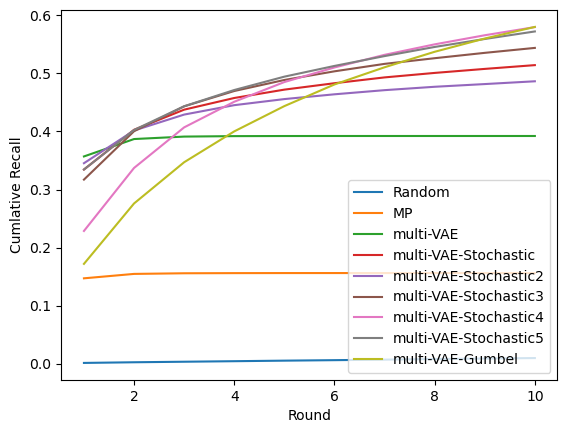

In [78]:
Nrec= 50
K = 20
Nsampling = 10

plt.rcParams['text.usetex'] = True

metrics_dic2 = {
    # "ndcg@{}".format(K):[[] for _ in range(n_rec)],
    # "recall@{}".format(K):[[] for _ in range(n_rec)],
    # "precision@{}".format(K):[[] for _ in range(n_rec)],
    # "hit_rate@{}".format(K): [[] for _ in range(n_rec)],
    "prediction_time": [[] for _ in range(Nrec)],
    "cumulative_recall@{}".format(K): [[] for _ in range(Nrec)],
}

methods_dic2 = {
    r"\tau=1":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Stochastic","params":{}},
    r"\tau=1/2)":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Stochastic-active","params":{"tau":0.5}},
    r"\tau=2":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Stochastic-active","params":{"tau":2}},
    r"\tau=10":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Stochastic-active","params":{"tau":10}},
    r"\mathrm{Annealing }\tau(2)":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Stochastic-active","params":{"tau_init":2}},
    r"\mathrm{Annealing }\tau(1.5)":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Stochastic-active","params":{"tau_init":1.5}},
}

methods_dic, users_dic = evaluate_multi_rec(methods_dic, test_data_tr, test_data_te, n_sampling=Nsampling, n_rec=Nrec, K=K)

n_test_users = users_dic['n_users']

method_names = list(methods_dic.keys())
metric_names = list(methods_dic[method_names[0]]["metrics"].keys())

print(metric_names)

results_all = []
for method_name, method_dic in methods_dic.items():
    results = []
    for metric_name, metric_list in method_dic["metrics"].items():
        if metric_name == "prediction_time":
            metric_list = np.sum(metric_list, axis=1)
            results.append("{:8f}({:8f})".format(np.sum(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        elif metric_name == "cumulative_recall@{}".format(K):
            metric_list = metric_list[-1]
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        elif metric_name == "hit_rate@{}".format(K):
            recall_in_multi_recs_list = np.array(method_dic["metrics"]["cumulative_recall@{}".format(K)]).copy()
            first_one_indices = (recall_in_multi_recs_list == 1).argmax(axis=0)
            for col in range(recall_in_multi_recs_list.shape[1]):
                recall_in_multi_recs_list[(recall_in_multi_recs_list[:, col] == 1) & (np.arange(recall_in_multi_recs_list.shape[0]) != first_one_indices[col]), col] = np.nan
            metric_list = np.nanmean(metric_list*recall_in_multi_recs_list, axis=0)
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        else:
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
print("All")
print("n_test_users:{}".format(n_test_users))
results_all.to_csv('results/run_{}recs_k{}_{}sampling_multiclicked'.format(Nrec, K, Nsampling))


fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_ylabel("Cumlative Recall")
ax.set_xlabel("Session")

colors =  {
    "Random" : "gray",
    "Most Popular" : "black",
    "multi-VAE" : "g",
    "multi-VAE(Gumbel)" : "b",
    "multi-VAE(Stochastic)" : "r",
}
for method_name, method_dic in methods_dic.items():
    cumulative_recalls = method_dic["metrics"]["cumulative_recall@{}".format(K)]
    # print(len(cumulative_recalls))
    # print(len(cumulative_recalls[0]))
    ax.errorbar(np.arange(1,Nrec+1), np.mean(cumulative_recalls, axis=1), yerr = np.std(cumulative_recalls, axis=1)/np.sqrt(len(cumulative_recalls[0])), label=method_name, color = colors[method_name])
    ax.legend()
fig.savefig("resultfig_cum_rec.eps",format="eps")
fig.show()

# results_all = pd.read_csv('results/run_{}recs_k{}_{}sampling'.format(Nrec, K, Nsampling))
results_all

In [39]:
results_all = []
for method_name, method_dic in methods_dic.items():
    results = []
    for metric_name, metric_list in method_dic["metrics"].items():
        if metric_name == "prediction_time":
            results.append("{:8f}({:8f})".format(np.sum(metric_list)/(n_test_users*Nrec), 0))
        elif metric_name == "cumulative_recall@{}".format(K):
            metric_list = metric_list[-1]
            results.append("{:4f}({:4f})".format(np.quantile(metric_list, 0.8, axis=0), 0))
        elif metric_name == "hit_rate@{}".format(K):
            recall_in_multi_recs_list = np.array(method_dic["metrics"]["cumulative_recall@{}".format(K)]).copy()
            first_one_indices = (recall_in_multi_recs_list == 1).argmax(axis=0)
            for col in range(recall_in_multi_recs_list.shape[1]):
                recall_in_multi_recs_list[(recall_in_multi_recs_list[:, col] == 1) & (np.arange(recall_in_multi_recs_list.shape[0]) != first_one_indices[col]), col] = np.nan
            metric_list = np.nanmean(metric_list*recall_in_multi_recs_list, axis=0)
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        else:
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
results_all

,hit_rate@20,prediction_time,cumulative_recall@20
Random,0.001329(0.000155),0.000004(0.000000),0.011737(0.000000)
MP,0.024938(0.001286),0.000003(0.000000),0.272727(0.000000)
multi-VAE,0.108610(0.002768),0.000015(0.000000),0.610101(0.000000)
multi-VAE-NSS-HNSW,0.100013(0.002677),0.000087(0.000000),0.588235(0.000000)
multi-VAE-Stochastic,0.159837(0.002723),0.000019(0.000000),0.831373(0.000000)
multi-VAE-Stochastic-NSS-HNSW,0.151638(0.002649),0.000087(0.000000),0.800000(0.000000)
multi-VAE-Gumbel,0.208105(0.002181),0.000020(0.000000),1.000000(0.000000)


[test]: 100%|██████████| 20/20 [08:39<00:00, 25.98s/it]


['hit_rate@20', 'prediction_time', 'cumulative_recall@20']
All
n_test_users:9782


,hit_rate@20,prediction_time,cumulative_recall@20
Random,0.001230(0.000113),0.000169(0.000000),0.019165(0.000666)
MP,0.024850(0.001282),0.000072(0.000000),0.156251(0.001996)
multi-VAE,0.108610(0.002768),0.000421(0.000000),0.392252(0.002867)
multi-VAE-NSS-HNSW,0.100307(0.002681),0.000231(0.000000),0.364901(0.002878)
multi-VAE-Stochastic,0.158757(0.002703),0.000419(0.000000),0.548021(0.002890)
multi-VAE-Stochastic-NSS-HNSW,0.150958(0.002630),0.000235(0.000000),0.534140(0.002876)
multi-VAE-Gumbel,0.206521(0.002176),0.000618(0.000000),0.701850(0.002561)


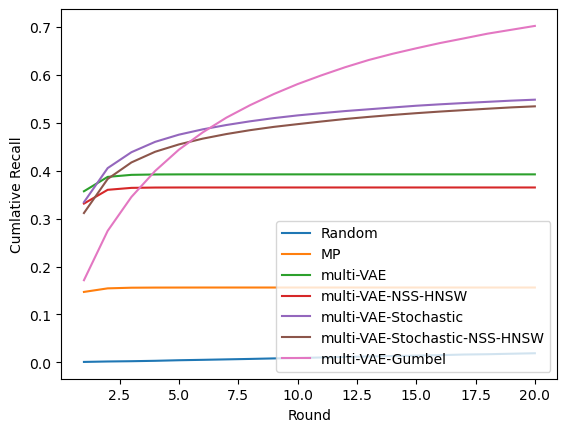

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

Nrec= 20
K = 20
Nsampling = 10

methods_dic, users_dic = evaluate_multi_rec(test_data_tr, test_data_te, n_sampling=Nsampling, n_rec=Nrec, K=K)

n_test_users = users_dic['n_users']

method_names = list(methods_dic.keys())
metric_names = list(methods_dic[method_names[0]]["metrics"].keys())

results_all = []
for method_name, method_dic in methods_dic.items():
    results = []
    for metric_name, metric_list in method_dic["metrics"].items():
        if metric_name == "prediction_time":
            results.append("{:8f}({:8f})".format(np.sum(metric_list)/(n_test_users*Nrec), np.std(np.dot(np.diag(1/user_dic['n_batch_users']), metric_list))/np.sqrt(metric_list.shape[0]*metric_list.shape[1])))
        elif metric_name == "cumulative_recall@{}".format(K):
            metric_list = metric_list[-1]
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        elif metric_name == "hit_rate@{}".format(K):
            recall_in_multi_recs_list = np.array(method_dic["metrics"]["cumulative_recall@{}".format(K)]).copy()
            first_one_indices = (recall_in_multi_recs_list == 1).argmax(axis=0)
            for col in range(recall_in_multi_recs_list.shape[1]):
                recall_in_multi_recs_list[(recall_in_multi_recs_list[:, col] == 1) & (np.arange(recall_in_multi_recs_list.shape[0]) != first_one_indices[col]), col] = np.nan
            metric_list = np.nanmean(metric_list*recall_in_multi_recs_list, axis=0)
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        else:
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
print("All")
print("n_test_users:{}".format(n_test_users))
results_all.to_csv('results/run_{}recs_k{}_{}sampling_multiclicked'.format(Nrec, K, Nsampling))


fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_ylabel("Cumlative Recall")
ax.set_xlabel("Round")
for method_name, method_dic in methods_dic.items():
    cumulative_recalls = method_dic["metrics"]["cumulative_recall@{}".format(K)]
    ax.plot(np.arange(1,Nrec+1), np.mean(cumulative_recalls, axis=1), label=method_name)
    ax.legend()
fig.show()

# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)
# ax.set_ylabel("Hit Rate")
# ax.set_xlabel("Round")
# for method_name, method_dic in methods_dic.items():
#     hit_rates = method_dic["metrics"]["hit_rate@{}".format(K)]
#     ax.plot(np.arange(1,Nrec+1), np.mean(hit_rates, axis=1), label=method_name)
#     ax.legend()
# fig.show()

# results_all = pd.read_csv('results/run_{}recs_k{}_{}sampling'.format(Nrec, K, Nsampling))
results_all

In [ ]:
# multi-click recommend-unique-items

In [87]:
def evaluate_multi_rec(data_tr, data_te, n_sampling=1, n_rec=1, K=20):
    # Turn on evaluation mode
    model.eval()
    total_loss = 0.0
    global update_count
    e_idxlist = list(range(data_tr.shape[0]))
    e_N = data_tr.shape[0]
    
    metrics_dic = {
        # "ndcg@{}".format(K):[[] for _ in range(n_rec)],
        # "recall@{}".format(K):[[] for _ in range(n_rec)],
        # "precision@{}".format(K):[[] for _ in range(n_rec)],
        "hit_rate@{}".format(K): [[] for _ in range(n_rec)],
        "prediction_time": [[] for _ in range(n_rec)],
        "cumulative_recall@{}".format(K): [[] for _ in range(n_rec)],
        # "recall@{}_in_{}recs".format(K,n_rec):[],
    }
    
    methods_dic = {
        "Random":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"Random","params":{}},
        "MP":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"MostPopular","params":{}},
        "multi-VAE":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE","params":{}},
        # "multi-VAE-MAX":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-MAX","params":{}},
        # "multi-VAE-NSS-Comp":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Faiss","params":{"faiss_index":index_flat}},
        "multi-VAE-NSS-HNSW":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Faiss","params":{"faiss_index":index_hnsw}},
        # "multi-VAE-wo-same-items":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE","params":{'f_avoid_already_recommended_items': True}},
        # "multi-VAE-Expectation":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Expectation","params":{}},
        # "multi-VAE-Expectation-wo-same-items":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Expectation","params":{'f_avoid_already_recommended_items': True}},
        # "multi-VAE-Expectation-Softmax":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Expectation-Softmax","params":{}},
        # "multi-VAE-Expectation-Softmax-wo-same-items":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Expectation-Softmax","params":{'f_avoid_already_recommended_items': True}},
        "multi-VAE-Stochastic":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Stochastic","params":{}},
        "multi-VAE-Stochastic-NSS-HNSW":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Stochastic-Faiss","params":{"faiss_index":index_hnsw}},
        "multi-VAE-Stochastic-MultiSampling":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Stochastic-MultiSampling","params":{}},
        # "multi-VAE-Stochastic-wo-same-items":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Stochastic","params":{'f_avoid_already_recommended_items': True}},
        "multi-VAE-Gumbel":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Gumbel","params":{'beta':1}},
        # "multi-VAE-Gumbel-MultiSampling":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Gumbel-MultiSampling","params":{'beta':1}},
        # "multi-VAE-Gumbel-beta0.2":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Gumbel","params":{'beta':0.2}},
        # "multi-VAE-Gumbel-beta0.1":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Gumbel","params":{'beta':0.1}},
        # "multi-VAE-Expectation-Gumbel":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Expectation-Gumbel","params":{'beta':0.2}},
        # "multi-VAE-Stochastic-Gumbel":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Stochastic-Gumbel","params":{'beta':1}},
    }
    
    users_dic = {
        'n_users':0,
        # 'n_interacts':[],
        'log_vars':[],
               }
    
    with torch.no_grad():
        with tqdm(range(0, e_N, BATCH_SIZE)) as pbar:
        # for start_idx in tqdm(range(0, e_N, BATCH_SIZE)):
            for start_idx in pbar:
                pbar.set_description("[test]")
                  
                # get batch data
                end_idx = min(start_idx + BATCH_SIZE, N)
                data = data_tr[e_idxlist[start_idx:end_idx]]
                heldout_data = data_te[e_idxlist[start_idx:end_idx]]
                
                # avoid users who has no interacts
                u_idxlist_wo_any_iteracts = [i for i, x in enumerate(heldout_data.toarray().sum(axis=1)) if x >0]
                data = data[u_idxlist_wo_any_iteracts]
                heldout_data = heldout_data[u_idxlist_wo_any_iteracts]
                
                # save information about already interected items for each user
                n_already_intaract_items = data.indptr[1:] - data.indptr[:-1]
                max_n_already_intaracted_items = int(cp.max(n_already_intaract_items))
                already_intaracted_idx = cp.squeeze(cp.asarray(data.argmax(axis=1)))
                
                # update experiment information to save
                n_batch_users = data.shape[0]
                users_dic['n_users'] += n_batch_users
                
                op_dic = {
                    'n_sampling':n_sampling,
                    'i_rec':0,
                    'params':{},
                    "pre_topk":torch.Tensor().to(device),
                    "max_n_already_intaracted_items":max_n_already_intaracted_items,
                    # "pre_topk":torch.zeros(n_batch_users, n_items).to(device),
                    'multi_VAE_recon_batch':None, 
                    'multi_VAE_EXP_recon_batch':None,
                    'multi_VAE_EXP_Softmax_recon_batch':None,
                }
                
                for method_name in methods_dic.keys():                    
                    # u_idxlist_wo_any_iteracts = [i for i, x in enumerate(heldout_data.toarray().sum(axis=1)) if x >0]
                    # data = data[u_idxlist_wo_any_iteracts]
                    # heldout_data = heldout_data[u_idxlist_wo_any_iteracts]

                    data_tensor = naive_sparse2tensor(data).to(device)
                    heldout_data_tensor = naive_sparse2tensor(heldout_data).to(device)
                    
                    all_topk_indices = []
                    op_dic["pre_topk"] = torch.Tensor().to(device)
                    op_dic["params"] = methods_dic[method_name]['params']
                    alg_name = methods_dic[method_name]['alg_name']
                    clicked_indices = None
                    
                    for p in range(n_rec):
                        op_dic['i_rec'] = p
                        
                        start = time.perf_counter()
                        topk_indices, recon_batch = my_topk(alg_name, model, data_tensor, K, **op_dic)
                        # recon_batch = my_predict(alg_name, model, data_tensor, **op_dic)
                        # topk = torch.topk(recon_batch, K, dim=1) ## quick sort (to check)
                        t_predict = time.perf_counter() - start
                        
                        # topk_indices = torch.Tensor(topk_indices).to(torch.int64).to(device)
                        op_dic["pre_topk"] = torch.cat([op_dic["pre_topk"],topk_indices], dim=1).to(torch.int64)
                        
                        # methods_dic[method_name]["metrics"]["ndcg@{}".format(K)][p].append(my_evaluate(topk.indices, heldout_data_tensor, "ndcg"))
                        # methods_dic[method_name]["metrics"]["recall@{}".format(K)][p].append(my_evaluate(topk.indices, heldout_data_tensor, "recall"))
                        # methods_dic[method_name]["metrics"]["precision@{}".format(K)][p].append(my_evaluate(topk.indices, heldout_data_tensor, "precision"))
                        methods_dic[method_name]["metrics"]["hit_rate@{}".format(K)][p].append(my_evaluate(topk_indices, heldout_data_tensor, "hit_rate"))
                        
                        # get clicked-item indices and position(for viewed-item indices)
                        
                        binaries = torch.gather(heldout_data_tensor, 1, topk_indices, sparse_grad=True)
                        clicked_indices_tensor = torch.zeros_like(heldout_data_tensor).scatter_(1, topk_indices, binaries)
                        viewed_indices_tensor = torch.zeros_like(heldout_data_tensor).scatter_(1, topk_indices, 1)
                        
                        # calc recall for all predictions
                        all_topk_indices.append(topk_indices)
                        # # all_topk_indices = torch.unique(torch.cat(all_topk_indices, dim=1), dim=1) ## 列数が行によって変化してしまうため、できない
                        all_pred_binary = np.zeros((n_batch_users, n_items), dtype=bool)
                        all_pred_binary[np.arange(n_batch_users)[:, np.newaxis], torch.cat(all_topk_indices, dim=1).cpu().numpy()] = True
                        all_true_binary = (heldout_data > 0).toarray()
                        methods_dic[method_name]["metrics"]["cumulative_recall@{}".format(K)][p].append((np.logical_and(all_true_binary, all_pred_binary).sum(axis=1)).astype(
            np.float32)/ all_true_binary.sum(axis=1))
                        
                        if "prediction_time" in metrics_dic:
                            methods_dic[method_name]["metrics"]["prediction_time"][p].append(t_predict)
                        else:
                            match method_name:
                                case "multi-VAE":
                                    op_dic['multi_VAE_recon_batch'] = recon_batch
                                case "multi-VAE-Expectation":
                                    op_dic['multi_VAE_EXP_recon_batch'] = recon_batch
                                case "multi-VAE-Expectation-Softmax":
                                    op_dic['multi_VAE_EXP_Softmax_recon_batch'] = recon_batch
    
                        # update already-clicked items
                        data_tensor = data_tensor + clicked_indices_tensor
                

    for method_name, method_dic in methods_dic.items():
        for metric_name, metric_list in method_dic["metrics"].items():
                if metric_name == "prediction_time":
                    methods_dic[method_name]["metrics"][metric_name] = np.array(metric_list)
                # elif metric_name == "recall@{}_in_{}recs".format(K,n_rec):
                #     methods_dic[method_name]["metrics"][metric_name] = np.concatenate(metric_list)
                else:
                    for l in range(n_rec):
                        methods_dic[method_name]["metrics"][metric_name][l] = np.array(np.concatenate(metric_list[l]))

[[4 5 0 3]
 [3 0 1 4]
 [5 2 4 0]
 [0 4 2 1]
 [0 1 5 2]]
[[False  True  True  True]
 [ True False  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True False  True]]
[[0 0 0 0 1 0]
 [1 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 1]]
[[5 0 3]
 [3 1 4]
 [5 2 4]
 [0 4 2]
 [0 1 2]]
[array([5, 0, 3]), array([3, 1, 4]), array([5, 2, 4, 0]), array([0, 4, 2, 1]), array([0, 1, 2])]
[array([5, 0, 3]), array([3, 1, 4]), array([5, 2, 4]), array([0, 4, 2]), array([0, 1, 2])]
3
3
3
3
3


[None, None, None, None, None]

In [93]:
A = np.array([[1,2,3],[2,3,4]])
b = np.array([10,100])

np.dot(np.diag(1/b),A)

array([[0.1 , 0.2 , 0.3 ],
       [0.02, 0.03, 0.04]])